In [ ]:
from __future__ import annotations

# Standard library
from pathlib import Path
from typing import TYPE_CHECKING

import networkx as nx

# Third-party libraries
import numpy as np
from rich.console import Console

# Local libraries

if TYPE_CHECKING:
    from collections.abc import Generator

# Global constants
# SCRIPT_NAME = __file__.split("/")[-1][:-3]
SCRIPT_NAME = "canical_test"
CWD = Path.cwd()
DATA = Path(CWD / "__data__" / SCRIPT_NAME)
DATA.mkdir(exist_ok=True)
SEED = 42

# Global functions
console = Console()
console.is_jupyter = False
RNG = np.random.default_rng(SEED)


from builtins import type as create_class
from enum import Enum
from typing import Any

from ariel.body_phenotypes.robogen_lite.config import (
    ALLOWED_FACES,
    ModuleFaces,
    ModuleInstance,
    ModuleRotationsIdx,
    ALLOWED_ROTATIONS,
    ModuleType,
)

# * IT IS SUPER VERY IMPORTANT THAT MODULEFACES ORDER NEVER CHANGES<3


class DIRECTION(Enum):
    CLOCKWISE = -1
    COUNTERCLOCKWISE = 1  # RIGHT TOP LEFT BOTTOM | FRONT RIGHT BACK LEFT

ROTATION_DIRECTION = DIRECTION.CLOCKWISE.value #TODO: broken...




class SymmetryPlane(Enum):
    """Symmetry plane determines how many unique rotations a module has."""

    NONE = 1
    TWO_FOLD = 2
    FOUR_FOLD = 4


ATTACHMENT_FACE = {
    ModuleType.BRICK: ModuleFaces.BACK,
    ModuleType.HINGE: ModuleFaces.BACK,
    ModuleType.NONE: ModuleFaces.BACK,
}

SYMMETRY_PLANE: dict[ModuleType, SymmetryPlane] = {
    ModuleType.CORE: SymmetryPlane.FOUR_FOLD,
    ModuleType.BRICK: SymmetryPlane.FOUR_FOLD,
    ModuleType.HINGE: SymmetryPlane.TWO_FOLD,
    ModuleType.NONE: SymmetryPlane.NONE,
}


class Priority(Enum):
    FIRST = 3
    SECOND = 2
    THIRD = 1
    FOURTH = 0


PRIORITIES: dict[ModuleType, Priority] = {
    ModuleType.CORE: Priority.FIRST,
    ModuleType.BRICK: Priority.SECOND,
    ModuleType.HINGE: Priority.THIRD,
    ModuleType.NONE: Priority.FOURTH,
}




class CanonicalNode:
    def __init__(
        self,
        id: int,
        type: ModuleType,
        rotation: int = 0,
        *,
        parent: int | None = None,
        symmetry_plane: int | None = None,
        attachment_face: ModuleFaces | None = None,
        allowed_rotations: list[ModuleRotationsIdx] | None = None,
        priority: int | None = None,
    ) -> None:
        """
        This class assumes the rotation axis is the attachment point!
        Therefore knowing the attachment point is important
        if there is no attachment point, the rotation axis will default to top and bottom
        this can be true while rotation being not able to happen.

        the class makes dynamic properties (methods) based on the configuration,
        to acces the children quickly:
        @property
        def TOP(self):
            return self.axial_side[0]

        @TOP.setter
        def TOP(self, value):
            self.axial_side[0] = value

        """
        
        # Compute attachment_face if not provided
        if attachment_face is None:
            attachment_face = ATTACHMENT_FACE.get(type)

        # with xor, the oppposite face may get detected
        axial_pair = (
            {attachment_face, ModuleFaces(attachment_face.value ^ 1)}
            if attachment_face
            else {ModuleFaces.TOP, ModuleFaces.BOTTOM}
        )
        reduced_axial = axial_pair & set(ALLOWED_FACES[type])

        axial_idx = sorted(reduced_axial, key=lambda f: f.value)
        radial_side = set(ALLOWED_FACES[type]).difference(axial_pair)

        radial_idx = (lambda s: s[:1] + s[2:3] + s[1:2] + s[3:])(
            sorted(radial_side, key=lambda f: f.value),
        )[::ROTATION_DIRECTION]

        if symmetry_plane is None:
            symmetry_plane = SYMMETRY_PLANE.get(
                type,
                SymmetryPlane.NONE,
            ).value

        if allowed_rotations is None:
            allowed_rotations = ALLOWED_ROTATIONS.get(
                type, [ModuleRotationsIdx.DEG_0]
            )

        if priority is None:
            priority = PRIORITIES.get(type, Priority.FOURTH).value

        # if it becomes a fraction, have symmetry plane prioritize.
        # This is the case for the core, not theoretically allowed to rotate but it can..
        # Calculate max_allowed_rotatations, fallback to symmetry_plane if division is zero
        max_allowed_rotatations = (
            len(allowed_rotations) // symmetry_plane
            if len(allowed_rotations) // symmetry_plane != 0
            else symmetry_plane
        )

        # Store basic attributes
        self.id: int = id
        self.type: ModuleType = type  # frozen TODO
        self.rotation: int = rotation
        self.parent: CanonicalNode | None = parent

        # TODO: do i remove the thing entirely if empty list?
        self.axial_side: list[None | CanonicalNode] = [None] * len(axial_idx)
        self.radial_side: list[None | CanonicalNode] = [None] * len(radial_idx)

        self._max_allowed_rotatations = max_allowed_rotatations
        self._face_parent_attached: ModuleFaces | None
        self._priority = priority
        self._full_priority = priority
        self._is_new_root: bool = False # Used for canonicalisation and axis rotation order..

        self._axial_faces: list[ModuleFaces] = axial_idx
        self._radial_faces: list[ModuleFaces] = radial_idx

        properties_dict = {}

        def make_property(index: int, side_list: str, face: ModuleFaces):
            """Factory to create a property for a face (axial or radial)."""

            def getter(self: CanonicalNode):
                return getattr(self, side_list)[index]

            def setter(self: CanonicalNode, value: CanonicalNode) -> None:
                value.parent = self
                value._face_parent_attached = face
                getattr(self, side_list)[index] = value

                def ancestors(node: CanonicalNode):
                    while node:
                        yield node
                        node = node.parent

                for ancestor in ancestors(self):
                    ancestor._full_priority += value._priority

            return property(getter, setter)

         # Example usage of the local function
        properties_dict = {}
        for idx, face in enumerate(axial_idx):
            properties_dict[face.name] = make_property(idx, "axial_side", face)

        for idx, face in enumerate(radial_idx):
            properties_dict[face.name] = make_property(idx, "radial_side", face)

        # Dynamically create the class
        NewClass = create_class(
            f"Canonical{type.name}",
            (self.__class__,),
            properties_dict,
        )
        self.__class__ = NewClass

    # TODO: make use of the rich tree print thing
    def __str__(self, level: int = 0) -> str:
        """
        Return a formatted string representation of the CanonicalNode object.

        Parameters
        ----------
        level : int, default 0
            Indentation level for nested string formatting.

        Returns
        -------
        str
            Multi-line formatted string showing node attributes and children.

        Notes
        -----
        - Creates hierarchical indentation using 2 spaces per level
        - Shows axial_side children only for faces in ALLOWED_FACES[self.type]
        - Shows radial_side children for all faces in ALLOWED_FACES[self.type]
        - Displays 'None' for missing child nodes at each face position
        """
        indent = "    " * level

        # Start with basic attributes
        attributes = [
            f"{indent}id={self.id}",
            f"{indent}type={self.type.name}",
            f"{indent}rotation={self.rotation}",
            # f"{indent}symmetry_plane={self._symmetry_plane}",
        ]

        # Add axial children
        axial_children = ",\n".join(
            f"{indent}  {face.name}: {getattr(self, face.name).__str__(level + 1)}"
            if getattr(self, face.name) is not None
            else f"{indent}  {face.name}: None"
            for face in ALLOWED_FACES[self.type]
            if face in self.axial_side #TODO: check type of axial/radial
        )
        attributes.append(
            f"{indent}axial_side=[\n{axial_children or f'{indent}  None'}\n{indent}]",
        )

        # Add radial children
        radial_children = ",\n".join(
            f"{indent}  {face.name}: {getattr(self, face.name).__str__(level + 1)}"
            if getattr(self, face.name) is not None
            else f"{indent}  {face.name}: None"
            for face in ALLOWED_FACES[self.type]
        )
        attributes.append(
            f"{indent}radial_side=[\n{radial_children or f'{indent}  None'}\n{indent}]",
        )

        # Format the final string iteratively
        formatted_attributes = "\n".join(attributes)
        return f"{indent}CanonicalNode(\n{formatted_attributes}\n{indent})"

    def __repr__(self) -> str:
        """
        Return a string representation of the object.

        Returns
        -------
        str
            A compact string representation showing type, rotation, and children.

        Notes
        -----
        - Format: "{type_initial}{rotation}[{face_children}]"
        - Type initial is first character of self.type.name
        - Rotation only included if non-zero
        - Face children shown as "{face_initial}:{child_repr}"
        - Empty brackets omitted if no children exist
        """
        # Start with the node's type and conditionally include rotation if it's not 0
        repr_str = f"{self.type.name[0]}"
        if self.rotation != 0:
            repr_str += f"{self.rotation}"
        repr_str += "{"

        # Collect children dynamically based on ALLOWED_FACES
        children_repr = []
        for face in ALLOWED_FACES[self.type]:
            child = getattr(self, face.name)
            if child:
                children_repr.append(f"{face.name.lower()[0]}:{child!r}")

        # Join children without trailing commas
        repr_str += "".join(children_repr)

        # Close the representation
        repr_str += "}"  # if children_repr else ""
        return repr_str

    @property
    def child(self):
        class ChildAccessor:
            def __init__(self, parent) -> None:
                self.parent = parent

            def __getitem__(self, face: ModuleFaces):
                return getattr(self.parent, face.name)

            def __setitem__(self, face: ModuleFaces, child: CanonicalNode) -> None:
                setattr(self.parent, face.name, child)

        return ChildAccessor(self)

    @property
    def children(self):
        for idx, face in enumerate(self._axial_faces):
            child = self.axial_side[idx]
            if child is not None:
                yield (face, child)

        for idx, face in enumerate(self._radial_faces):
            child = self.radial_side[idx]
            if child is not None:
                yield (face, child)

    @property
    def axial_children(self):
        for child in self.axial_side:
            if child is not None:
                yield child

    @property
    def radial_children(self):
        for child in self.radial_side:
            if child is not None:
                yield child

    @property
    def children_nodes(self) -> Generator[CanonicalNode, None, None]:
        yield from (c for c in self.axial_side if c is not None)
        yield from (c for c in self.radial_side if c is not None)

    @classmethod
    def build_tree_from_dict(
        cls,
        data: dict[int, ModuleInstance],
        omit_none: bool = False,
    ) -> CanonicalNode:
        root = CanonicalNode(id=0, type=ModuleType.CORE, rotation=0)

        def fill_in(data: dict[int, ModuleType], parent: CanonicalNode) -> None:
            for face, id in data[parent.id].links.items():
                if omit_none and data[id].type == ModuleType.NONE:
                    continue
                child = CanonicalNode(
                    id=id,
                    type=data[id].type,
                    # parent_id=parent.id,
                    rotation=data[id].rotation,
                )
                parent.child[face] = child
                fill_in(data, child)

        fill_in(data, root)
        return root

    def to_dict(self, omit_none: bool = False) -> dict[int, ModuleInstance]:
        result = {}

        def collect_node(node: CanonicalNode) -> None:
            if omit_none and node.type == ModuleType.NONE:
                return

            links = {}
            for face, child in node.children:
                if not omit_none or child.type != ModuleType.NONE:
                    links[face] = child.id

            result[node.id] = ModuleInstance(
                type=node.type,
                rotation=ModuleRotationsIdx(node.rotation),
                links=links,
            )

            for child in node.children_nodes:
                collect_node(child)

        collect_node(self)
        return result

    @classmethod
    def from_graph(
        cls,
        graph: nx.DiGraph[Any],
        skip_type: ModuleType = ModuleType.NONE,
    ) -> CanonicalNode:
        """Build a CanonicalNode tree from a NetworkX graph."""

        # TODO: check typing
        def get_rotation_value(rotation_attr): 
            return (
                ModuleRotationsIdx[rotation_attr].value
                if isinstance(rotation_attr, str)
                else rotation_attr
            )

        def create_node(
            node_id: int,
        ) -> CanonicalNode:
            attrs = graph.nodes[node_id]
            return CanonicalNode(
                id=node_id,
                type=ModuleType[attrs["type"]],
                rotation=get_rotation_value(attrs["rotation"]),
                # parent_id=parent.id,
            )

        def fill_in(parent: CanonicalNode) -> None:
            for _, child_id, edge_data in graph.out_edges(parent.id, data=True):
                child_type = ModuleType[graph.nodes[child_id]["type"]]

                if child_type == skip_type:
                    continue

                child = create_node(child_id)
                parent.child[ModuleFaces[edge_data["face"]]] = child
                fill_in(child)

        root_id = next(
            node for node in graph.nodes() if graph.in_degree(node) == 0
        )
        root = create_node(root_id)
        fill_in(root)

        return root

    # TODO; is this cursed to have in the arguments?
    def to_graph(self, skip_type: ModuleType = ModuleType.NONE) -> nx.DiGraph[Any]:
        """Generate a NetworkX graph from the CanonicalNode tree."""
        graph = nx.DiGraph()

        def traverse_node(node: CanonicalNode) -> None:
            graph.add_node(
                node.id,
                type=node.type.name,
                rotation=ModuleRotationsIdx(node.rotation).name,
            )

            for face, child in node.children:
                if child.type == skip_type:
                    print("found skyptype") # Todo: check if this works well?
                    continue

                graph.add_node(
                    child.id,
                    type=child.type.name,
                    rotation=ModuleRotationsIdx(child.rotation).name,
                )
                graph.add_edge(
                    node.id,
                    child.id,
                    face=face.name,
                )
                traverse_node(child)

        traverse_node(self)
        return graph


    # TODO: need to fix this........ and think
    def is_connected_to_axial_root(self) -> bool:
        if not hasattr(self, '_face_parent_attached'):
            return False
        
        # Must be attached via FRONT to start the chain
        if self._face_parent_attached != ModuleFaces.FRONT:
            return False
        
        console.print('parent has face attached atribute ')
        # Check if parent exists and is attached via TOP/BOTTOM, and grandparent has _is_new_root
        if (self.parent and 
            hasattr(self.parent, '_face_parent_attached') and
            self.parent._face_parent_attached in (ModuleFaces.TOP, ModuleFaces.BOTTOM) and 
            self.parent.parent and 
            self.parent.parent._is_new_root):
            return True
        
        # If not directly matching, recurse up the chain if parent exists
        if self.parent:
            return self.parent.is_connected_to_axial_root()
        
        return False


    #TODO might add this if i want to account for symmetry in the hashing?..
    def invert_symmetry(self) -> None:
        pass

    def canonicalize_child_order(self) -> None:
        """
        uses the full priority to determine the child order
        always sets the max at first
        rotatation always in 1 direction
        """
        side_amt = len(self.radial_side)
        if side_amt == 0:
            return

        priority_list = []
        for child in self.radial_side:
            if child is None:
                priority_list.append(0)
            else:
                priority_list.append(child._full_priority)

        max_index = priority_list.index(max(priority_list))
        num_rotations = (side_amt - max_index) % side_amt
        for _ in range(num_rotations):
            self.rotate()

    def rotate(self):
        self.rotation = self.rotation - self._max_allowed_rotatations
        self.radial_side[:] = self.radial_side[-1:] + self.radial_side[:-1]
        
        # account for axial child rotation
        for child in self.axial_children:            
            child.rotation += self._max_allowed_rotatations
        

        console.print(self.is_connected_to_axial_root(), self.id)
        if self.is_connected_to_axial_root():
            # this means this is either the top or the bottom
            # right, bottom, left, top
            SHIFTS_PER_PLACE = {0: 1, 1: 1, 2: -1, 3: -1}          
            
            for i, child in enumerate(self.radial_side):
                if child and len(child.radial_side) > 0:  # Add check for non-empty list
                    shift = SHIFTS_PER_PLACE.get(i, 0)
                    child.radial_side[:] = child.radial_side[shift:] + child.radial_side[:shift]
                    console.print(i, repr(child))
                    console.print('changed child: ', child.id)

            
        
        
        
        # if self.parent and self.parent._is_new_root:
        #     for i, child in enumerate(self.radial_side):
        #         if child:
        #             # place 0 (rn right) -> shift with 1
                    
        #             # place 1 (rn bottom) -> shift with -3
                    
        #             # place 3 (rn left) -> shift with -1 
                    
        #             # place 4 (rn top) -> shift with 3
                    
        #             # LEFT
        #             console.print(i, repr(child))
        #             child.radial_side[:] = child.radial_side[3:] + child.radial_side[:3]
        
        # if a piece is the new root and the 
                    
            
        # account for top/bottom for the root            
        # if self._is_new_root:
        #     if self.TOP:
        #         console.print('found a top')
        #         # recurse everything to front?
        #         top_child = self.TOP
        #         for child in top_child.radial_children:
        #             console.print('rotated child ,', repr(child))
        #             child.radial_side[:] = child.radial_side[1:] + child.radial_side[:1]
                    
        #     if self.BOTTOM:
        #         bottom_child = self.BOTTOM
        #         console.print('found a bottom')
        #         for child in bottom_child.radial_children:
        #             console.print('rotated child ', repr(child))
        #             child.radial_side[:] = child.radial_side[1:] + child.radial_side[:1]
                
                
            # for grand_child in child.radial_children:
            #     console.print('found the radial child of the axial child')
            #     grand_child.radial_side[:] = grand_child.radial_side[-1:] + grand_child.radial_side[:-1]

    def normalize_rotations(self) -> None:
        swap_amt = self.rotation // self._max_allowed_rotatations
        
        for _ in range(swap_amt):
            self.rotate()

        for _, child in self.children:
            child.normalize_rotations()
            
    # def fix_new_root(self):
    #     for child in self.axial_children:
    #         console.print('found axial children:', repr(child))
    #         # for grand_child in child.radial_children:
    #         # child.LEFT:
    #         child.LEFT.radial_side[:] = child.LEFT.radial_side[-1:] + child.LEFT.radial_side[:-1]
    #         console.print('decreased the ggrand child rotaion')
    #         # child.RIGHT:
    #         child.RIGHT.radial_side[:] =  child.RIGHT.radial_side[-2:] + child.RIGHT.radial_side[:-2]

            

            
    def re_add_id(self, start_id: int = 0) -> int:
        self.id = start_id
        current_id = start_id + 1
        for child in self.children_nodes:
            current_id = child.re_add_id(current_id)
        return current_id

    def depth_first_collect(self) -> list[nx.DiGraph[Any]]:
        list_graph = []

        self._is_new_root = True
        # self.canonicalize_child_order()
        self.rotation = 0
        self.normalize_rotations()
        self.re_add_id()
        self._is_new_root = False
        
        list_graph.append(self.to_graph())

        for child in self.children_nodes:
            list_graph.extend(child.depth_first_collect())

        return list_graph

In [27]:
from ariel_experiments.gui_vis.visualize_tree import (
    visualize_tree_from_graph,
)
from ariel_experiments.utils.initialize import generate_random_individual
from ariel_experiments.gui_vis.view_mujoco import view
# from ariel.body_phenotypes.robogen_lite.constructor import (
#     construct_mjspec_from_graph,
# )
# from IPython.display import display

console.is_jupyter = False
%matplotlib inline


Testing

In [28]:
def give_brick(i: int) -> CanonicalNode:
    brick1 = CanonicalNode(i, ModuleType.BRICK, 1)
    brick2 = CanonicalNode(i + 1, ModuleType.BRICK, 3)
    brick3 = CanonicalNode(i + 2, ModuleType.BRICK, 0)
    brick4 = CanonicalNode(i + 3, ModuleType.BRICK, 1)

    hinge1 = CanonicalNode(i + 4, ModuleType.HINGE, 3)
    hinge2 = CanonicalNode(i + 5, ModuleType.HINGE, 1)

    brick5 = CanonicalNode(i + 6, ModuleType.BRICK, 1)
    brick6 = CanonicalNode(i + 7, ModuleType.BRICK, 1)

    hinge3 = CanonicalNode(i + 8, ModuleType.HINGE, 7)
    hinge4 = CanonicalNode(i + 9, ModuleType.HINGE, 1)

    brick1.FRONT = brick2
    brick1.TOP = hinge4
    brick2.LEFT = brick3
    brick2.BOTTOM = brick4
    brick2.TOP = hinge1

    brick2.FRONT = brick5
    brick5.TOP = hinge2

    brick5.FRONT = brick6
    brick6.TOP = hinge3

    return brick1

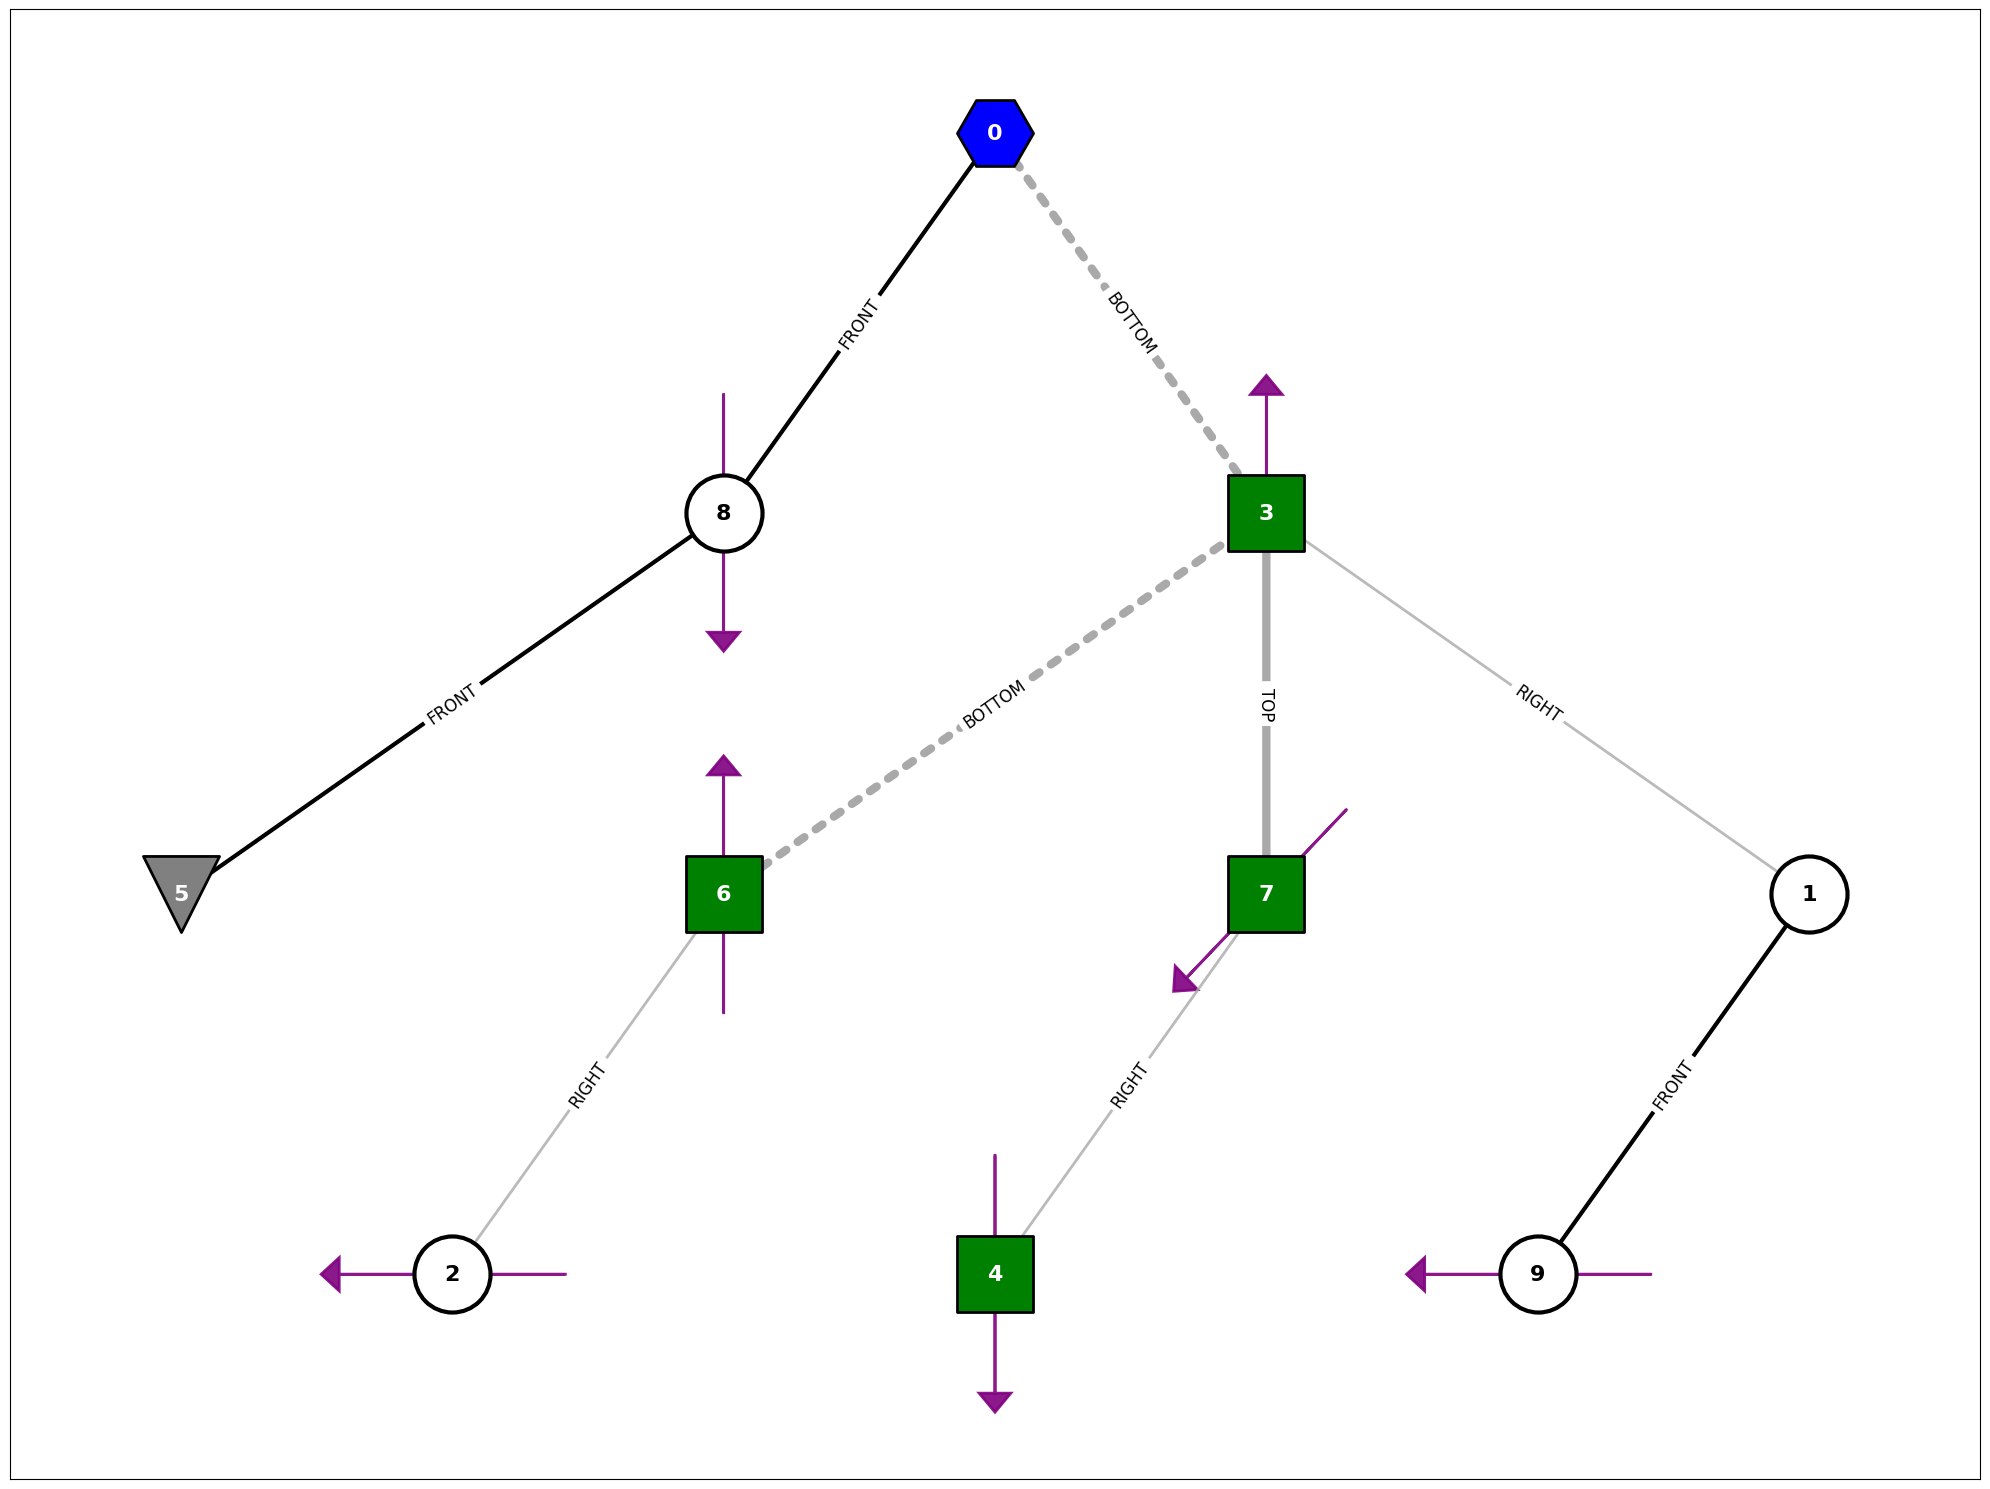

[00:23:47] DoF (model.nv): 10, Actuators (model.nu): 4                                           ]8;id=5796;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=352811;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

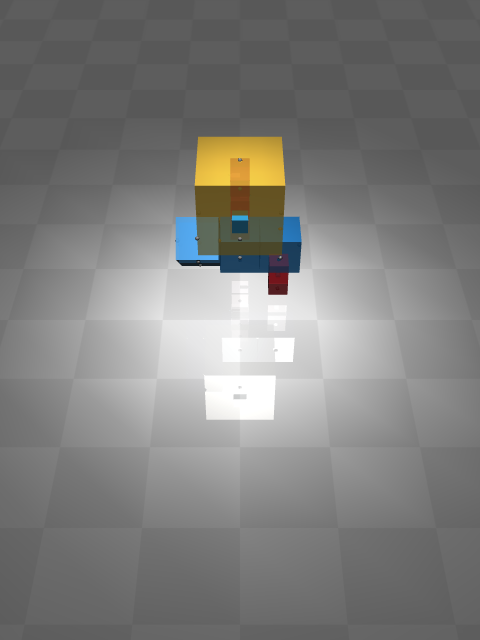

False 3
False 9
False 6
False 2
False 7
False 7
False 4
False 4
False 4
False 8


In [29]:


# root = CanonicalNode(0, ModuleType.CORE)
# Attach brick1 to FRONT as before
# root.LEFT = give_brick(1)

# console.print(root.to_dict())

# print(root.LEFT.FRONT.radial_side)
# print(root.LEFT.FRONT.LEFT)

# root.LEFT = CanonicalNode(1, ModuleType.BRICK, 3)


# root.RIGHT = give_brick(5)
# root.BACK = give_brick(9)
# root.LEFT = give_brick(13)
# graph = root.to_graph()

#! if i want random
graph = generate_random_individual(10)
visualize_tree_from_graph(graph)
root = CanonicalNode.from_graph(graph)

# console.rule("random individual")

# visualize_tree_from_graph(graph, title="first")
view(graph)

non_non = root.to_graph()

# console.rule("removed nones")
# visualize_tree_from_graph(non_non, title="removed ones")
# view(non_non, with_viewer=True)
# display(img)

# root.normalize_rotations()
# console.print(root.to_dict())
# print(root.LEFT.FRONT.radial_side)


# graph = root.to_graph()
# visualize_tree_from_graph(graph, save_file="real.png")
# img = view(graph)
# graph_list = []

graph_list = root.depth_first_collect()

# print(repr(root))
# root.re_add_id()
# graph2 = root.to_graph()
# img = view(construct_mjspec_from_graph(graph2))
# display(img)

# console.rule("STARTING SUBTREES")
# for i, graph1 in enumerate(graph_list):
#     canonical = CanonicalNode.from_graph(graph1)
#     canonical.re_add_id()
#     # print(canonical.to_graph())

#     # visualize_tree_from_graph(graph1, save_file="real.png")
#     if i == 0:
#         view(graph1, with_viewer=True)
    
    # view(graph1)

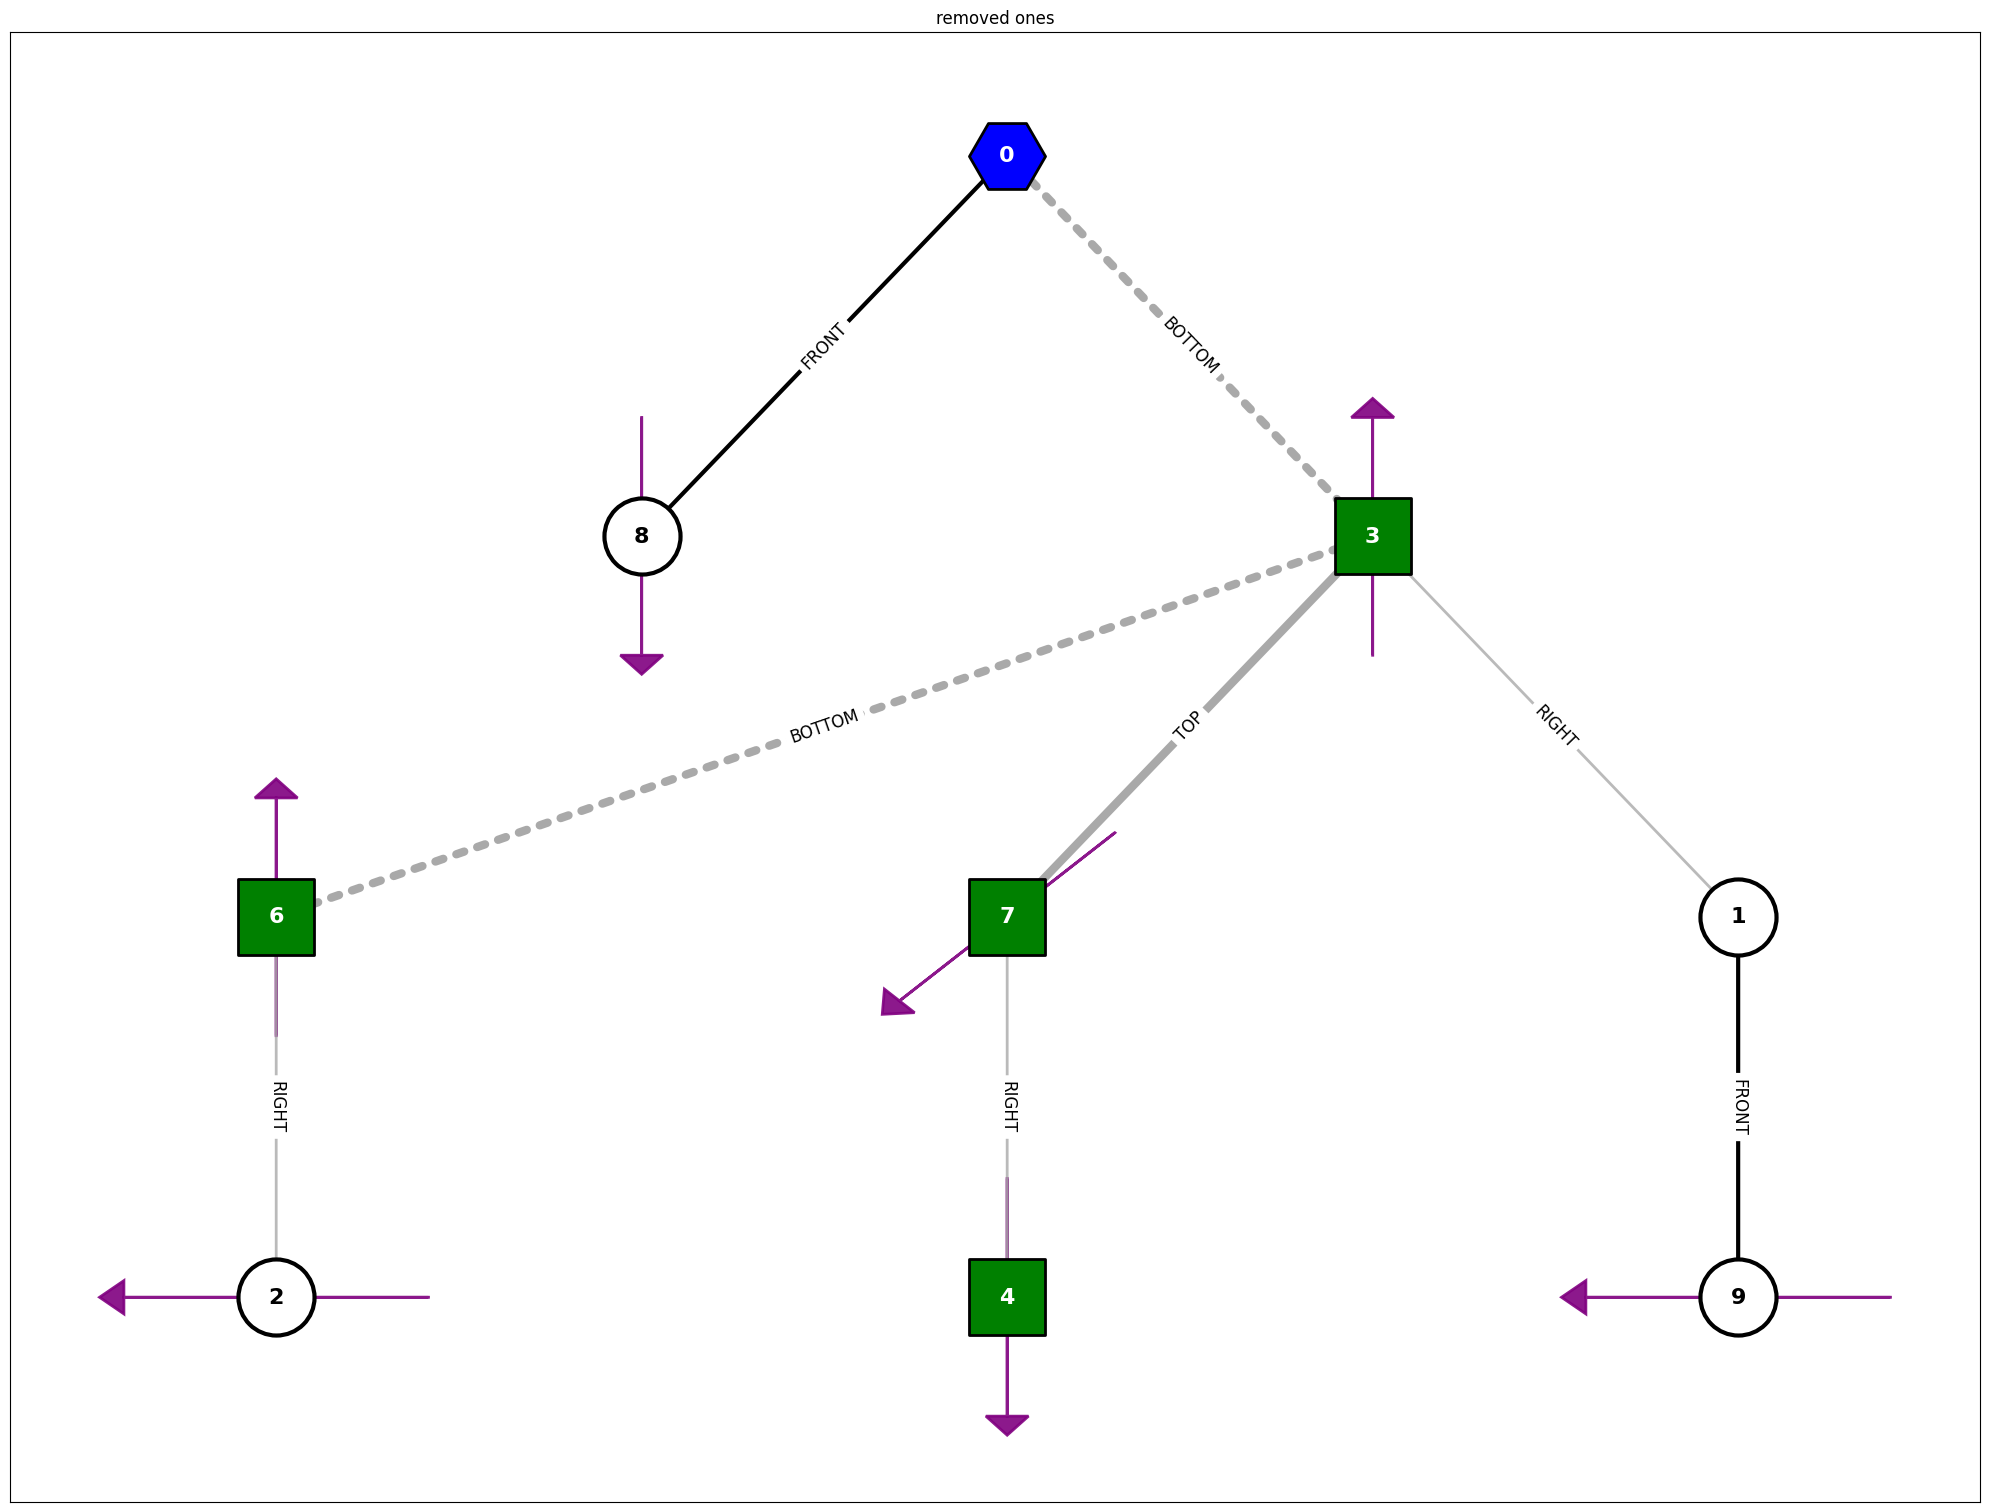

[00:23:48] DoF (model.nv): 10, Actuators (model.nu): 4                                           ]8;id=302560;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=733874;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

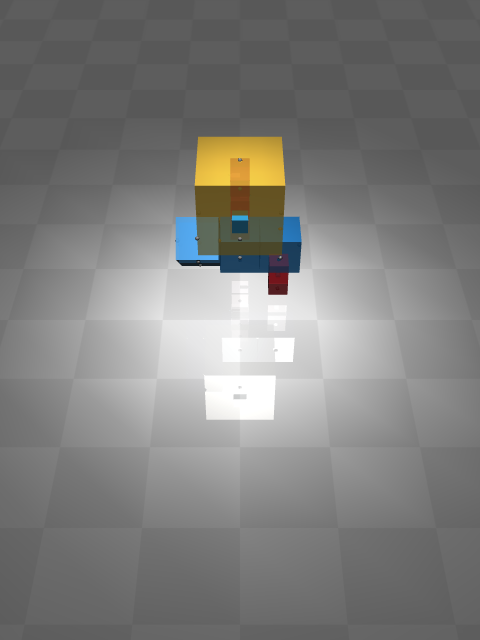

In [30]:
visualize_tree_from_graph(non_non, title="removed ones")
view(non_non, with_viewer=True)

──────────────────────────────────────────────── STARTING SUBTREES ────────────────────────────────────────────────


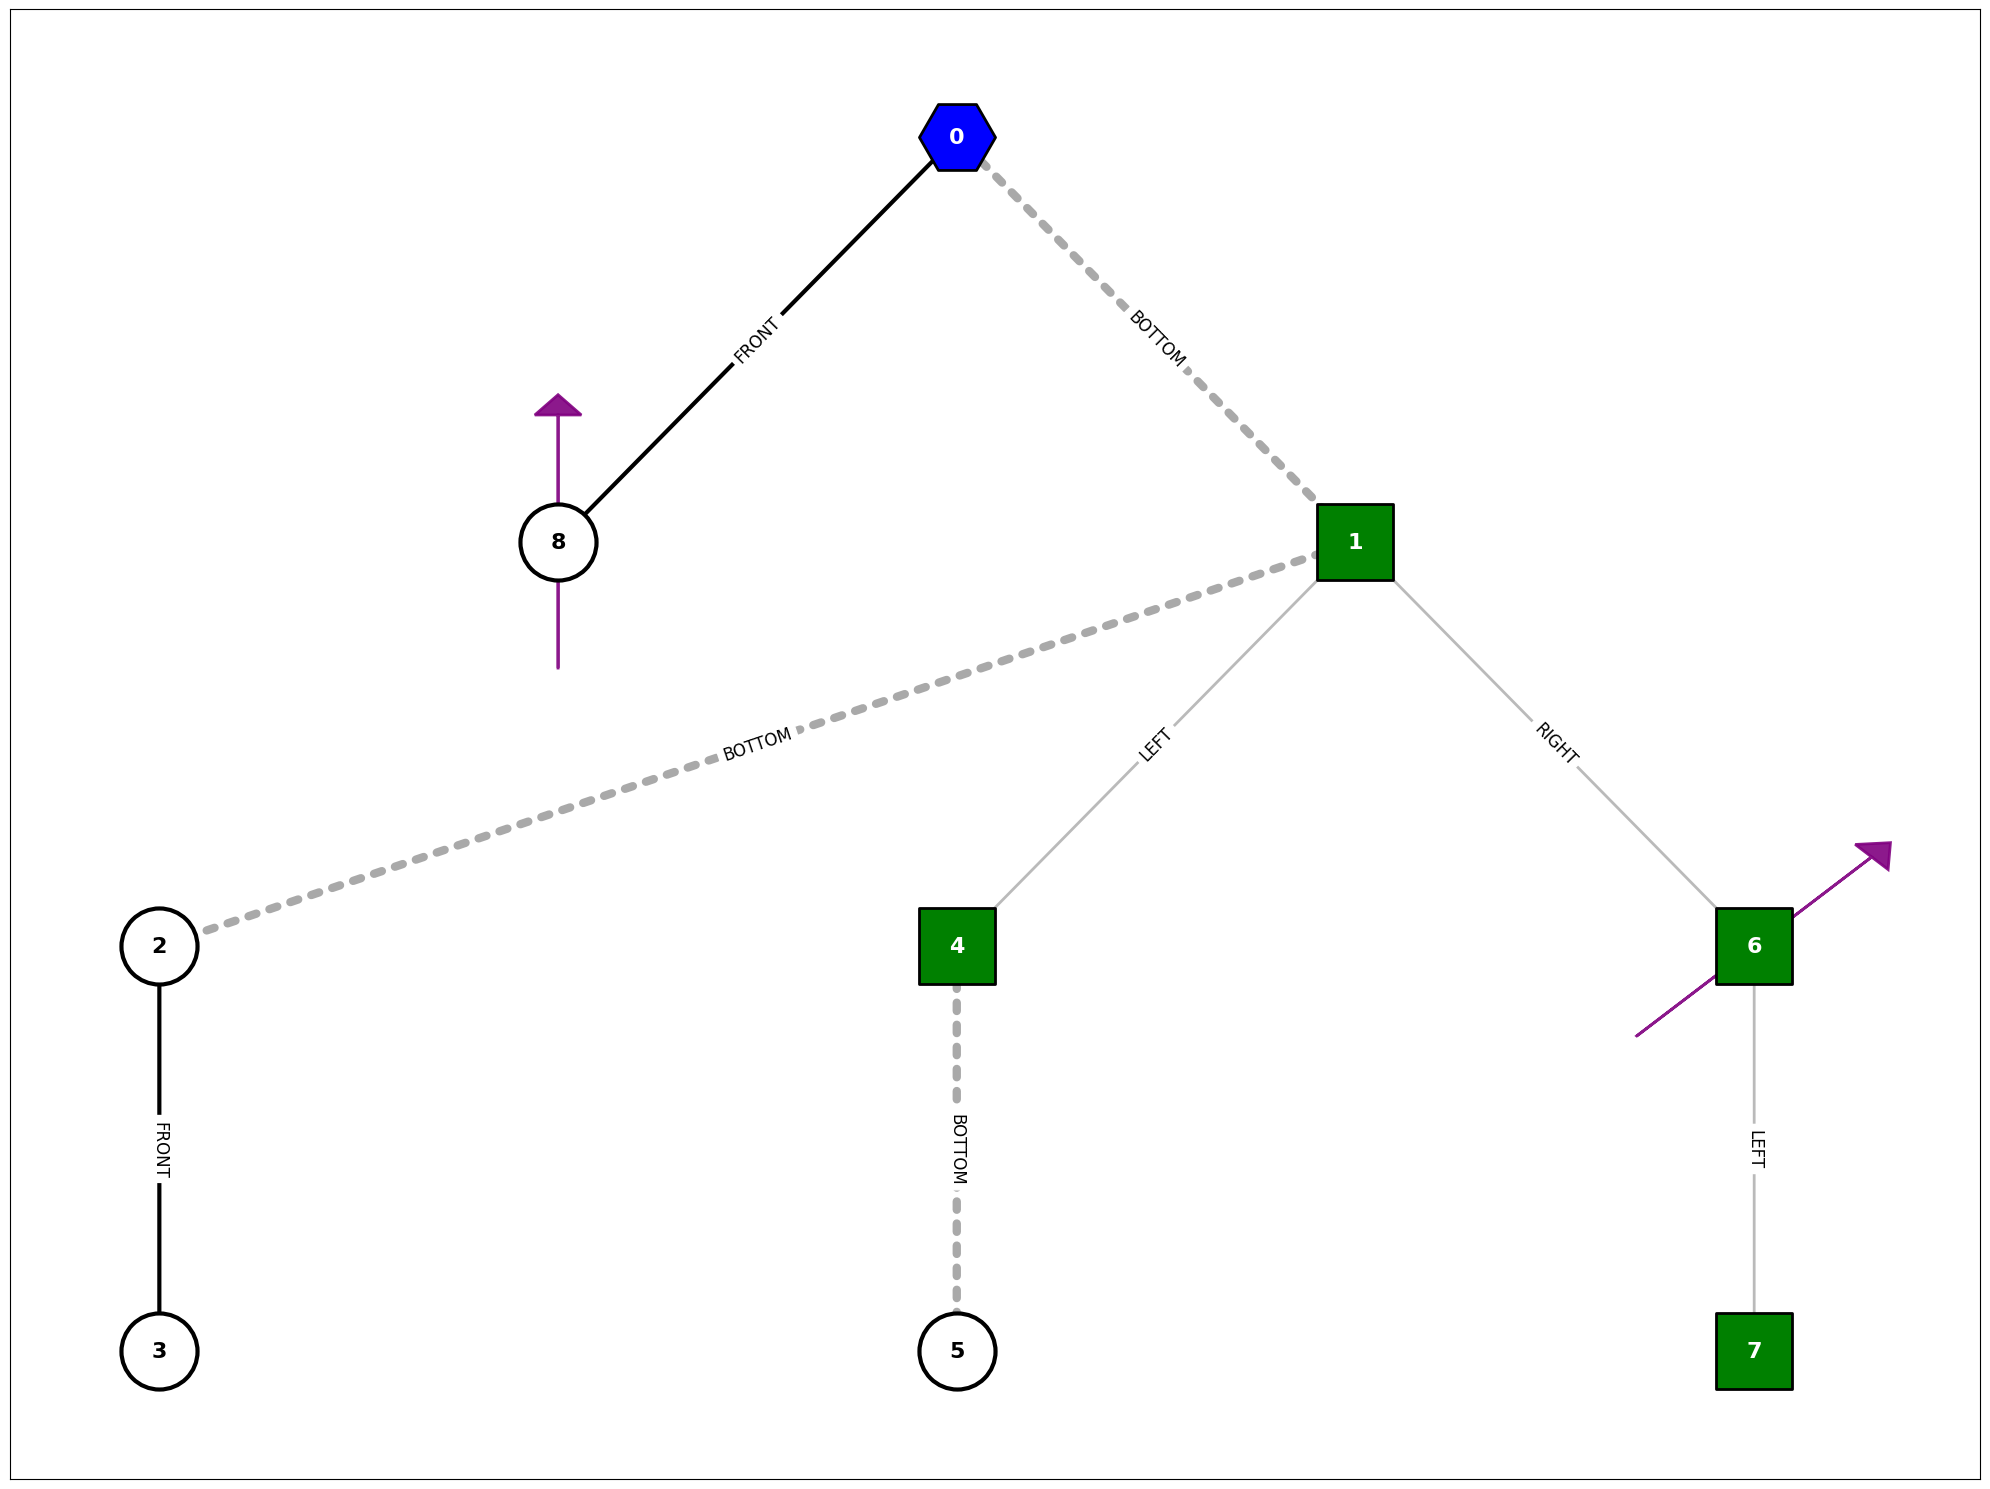

[00:23:51] DoF (model.nv): 10, Actuators (model.nu): 4                                           ]8;id=264173;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=350144;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

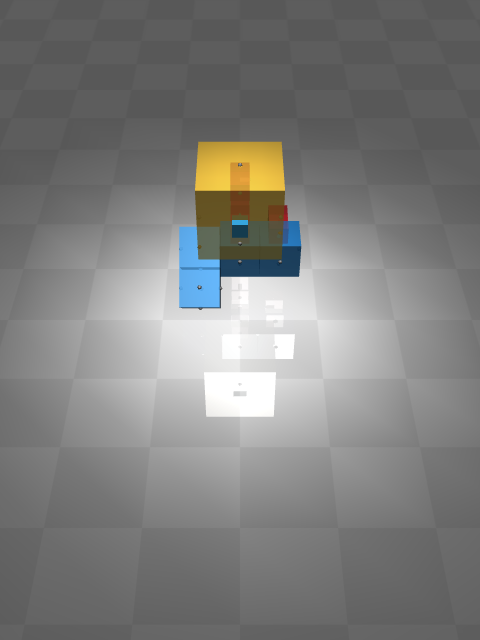

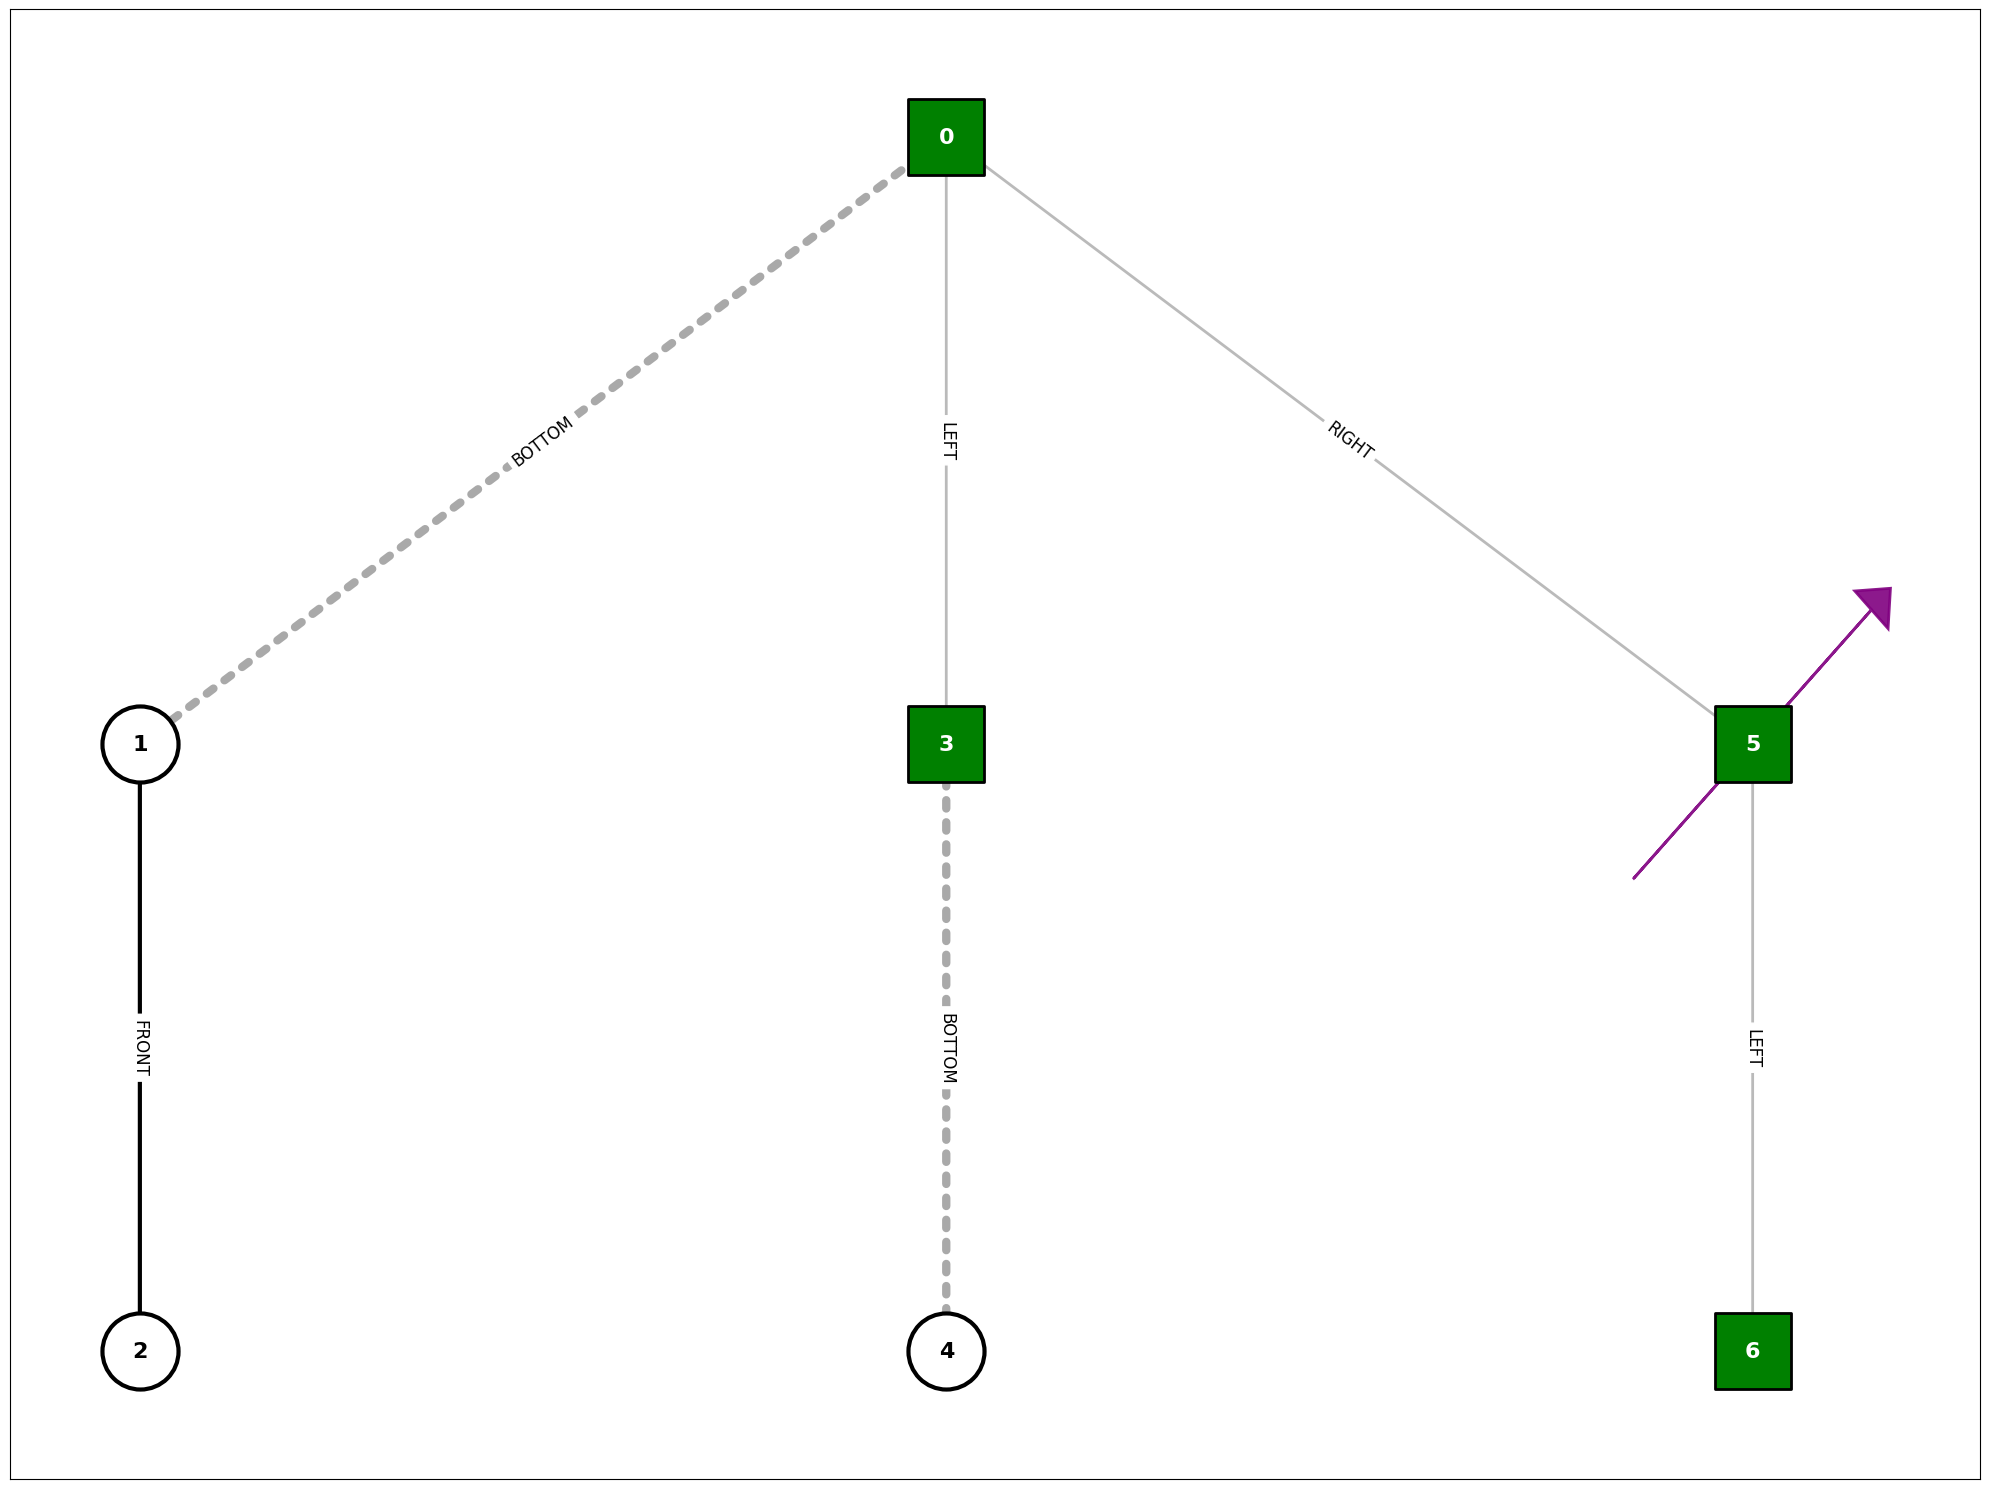

           DoF (model.nv): 9, Actuators (model.nu): 3                                            ]8;id=727339;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=938128;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

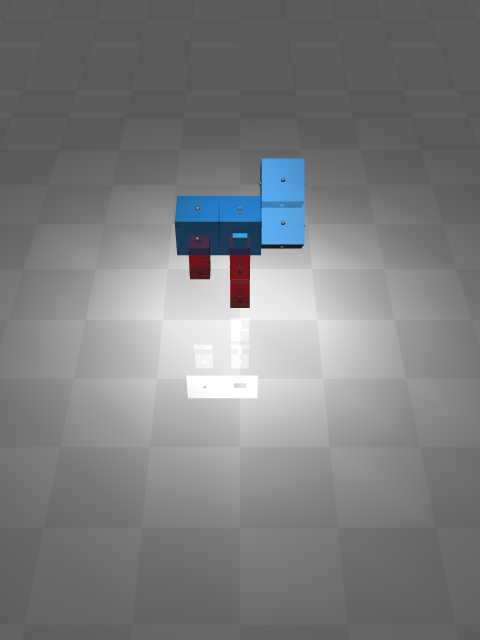

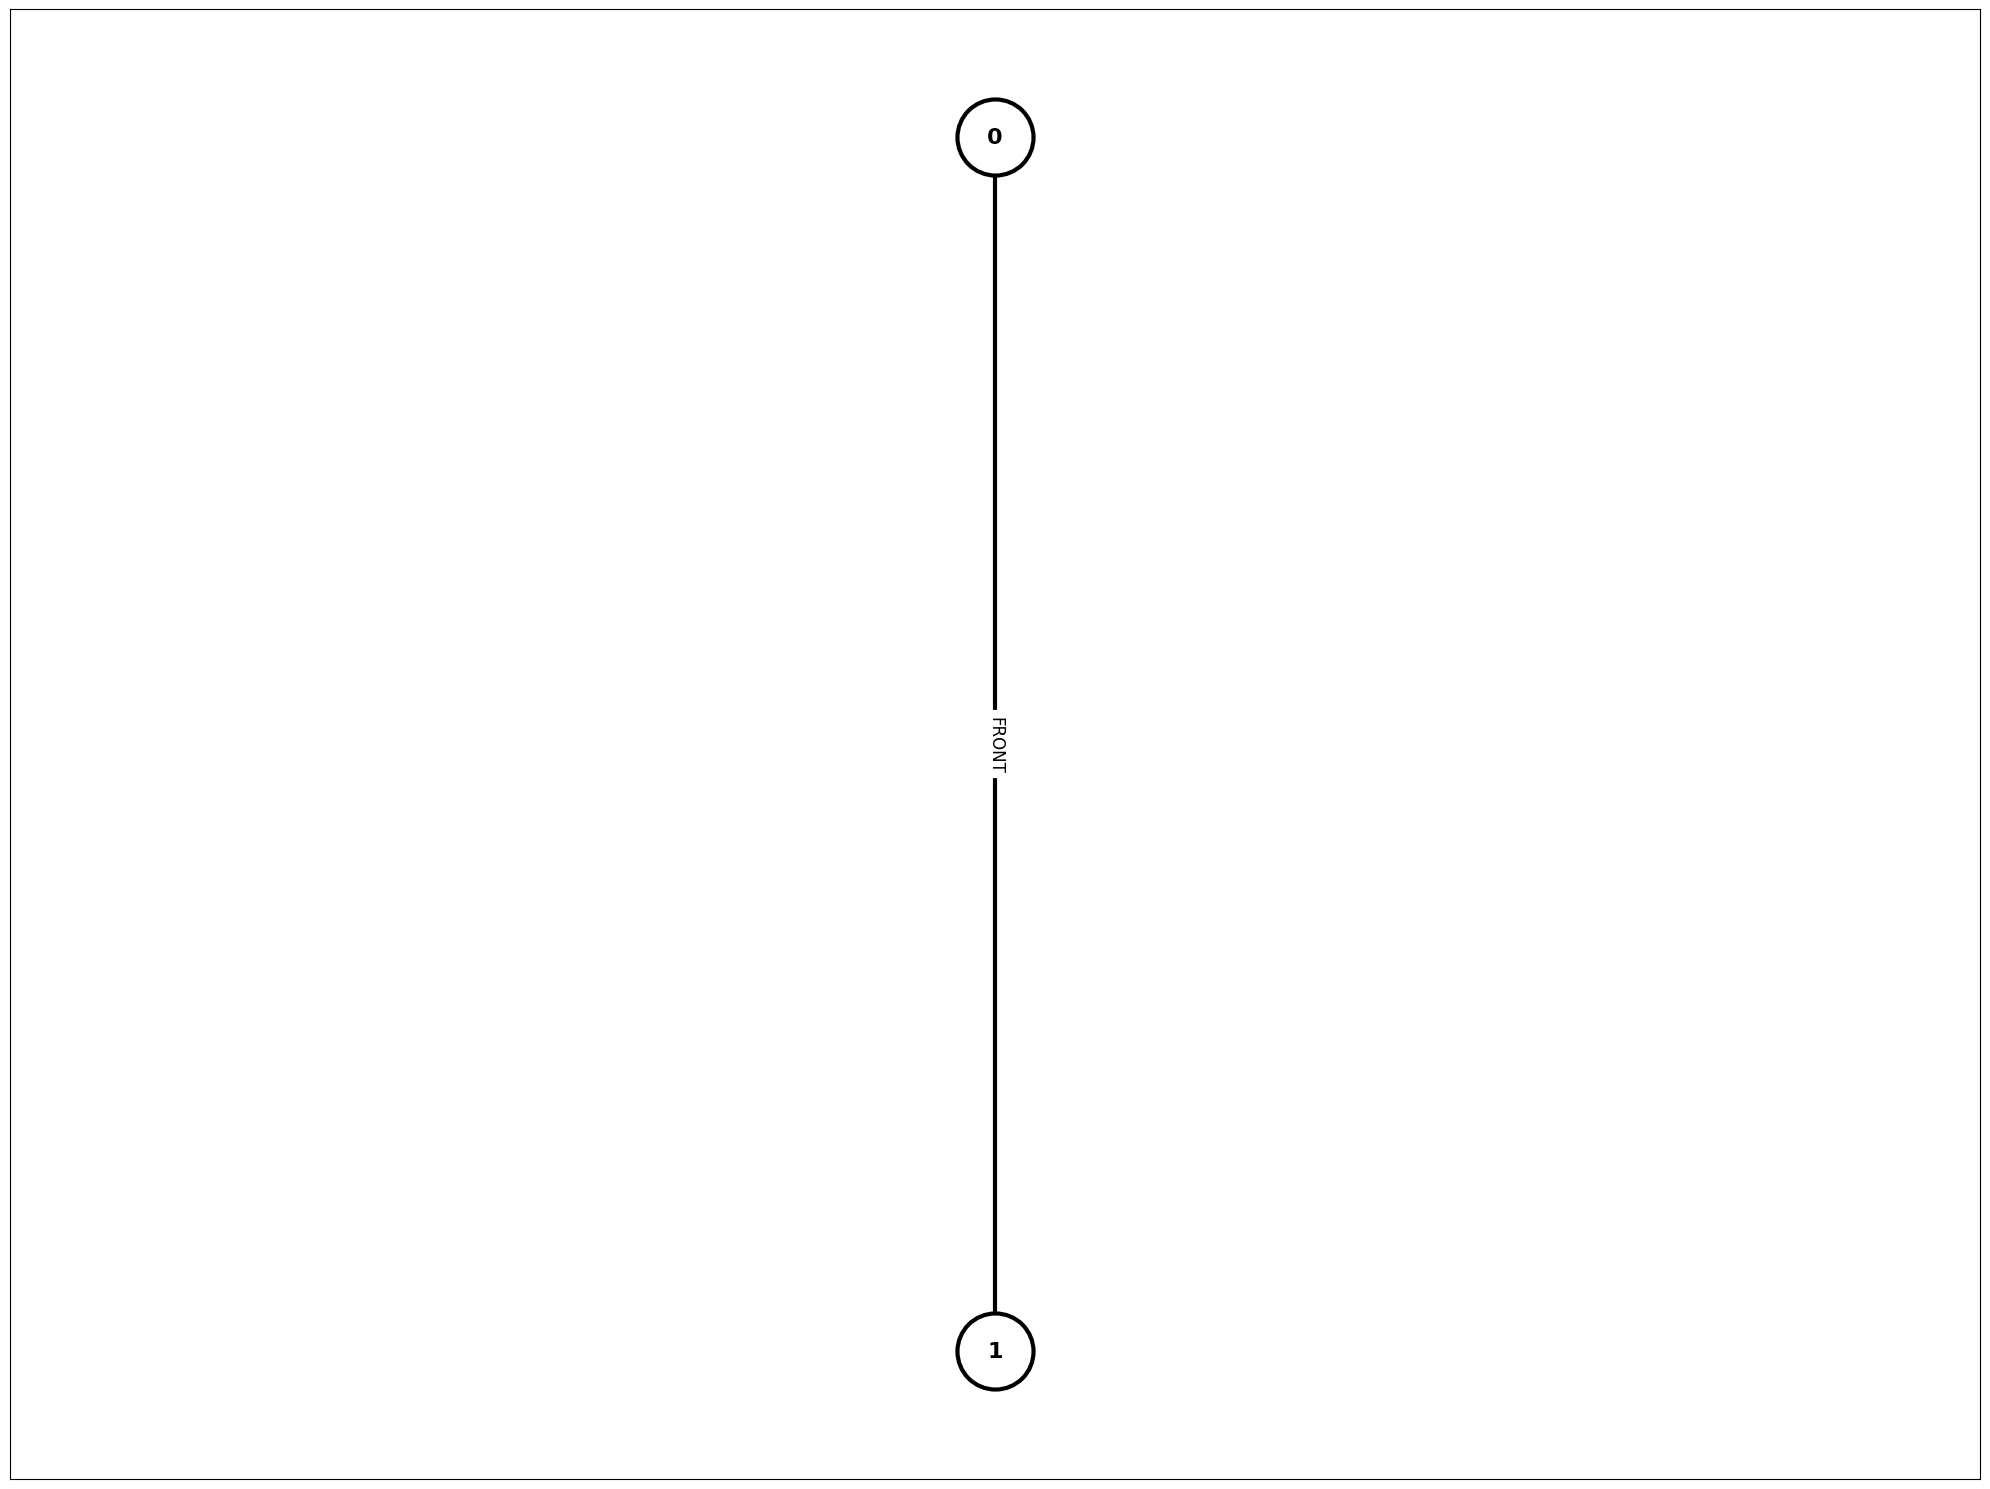

[00:23:52] DoF (model.nv): 8, Actuators (model.nu): 2                                            ]8;id=603614;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=855062;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

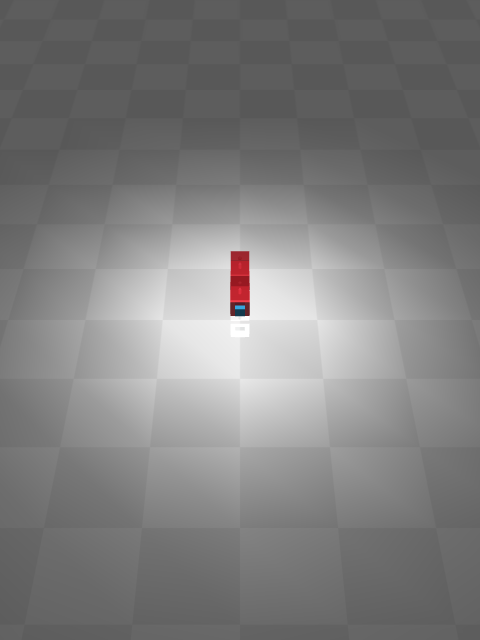

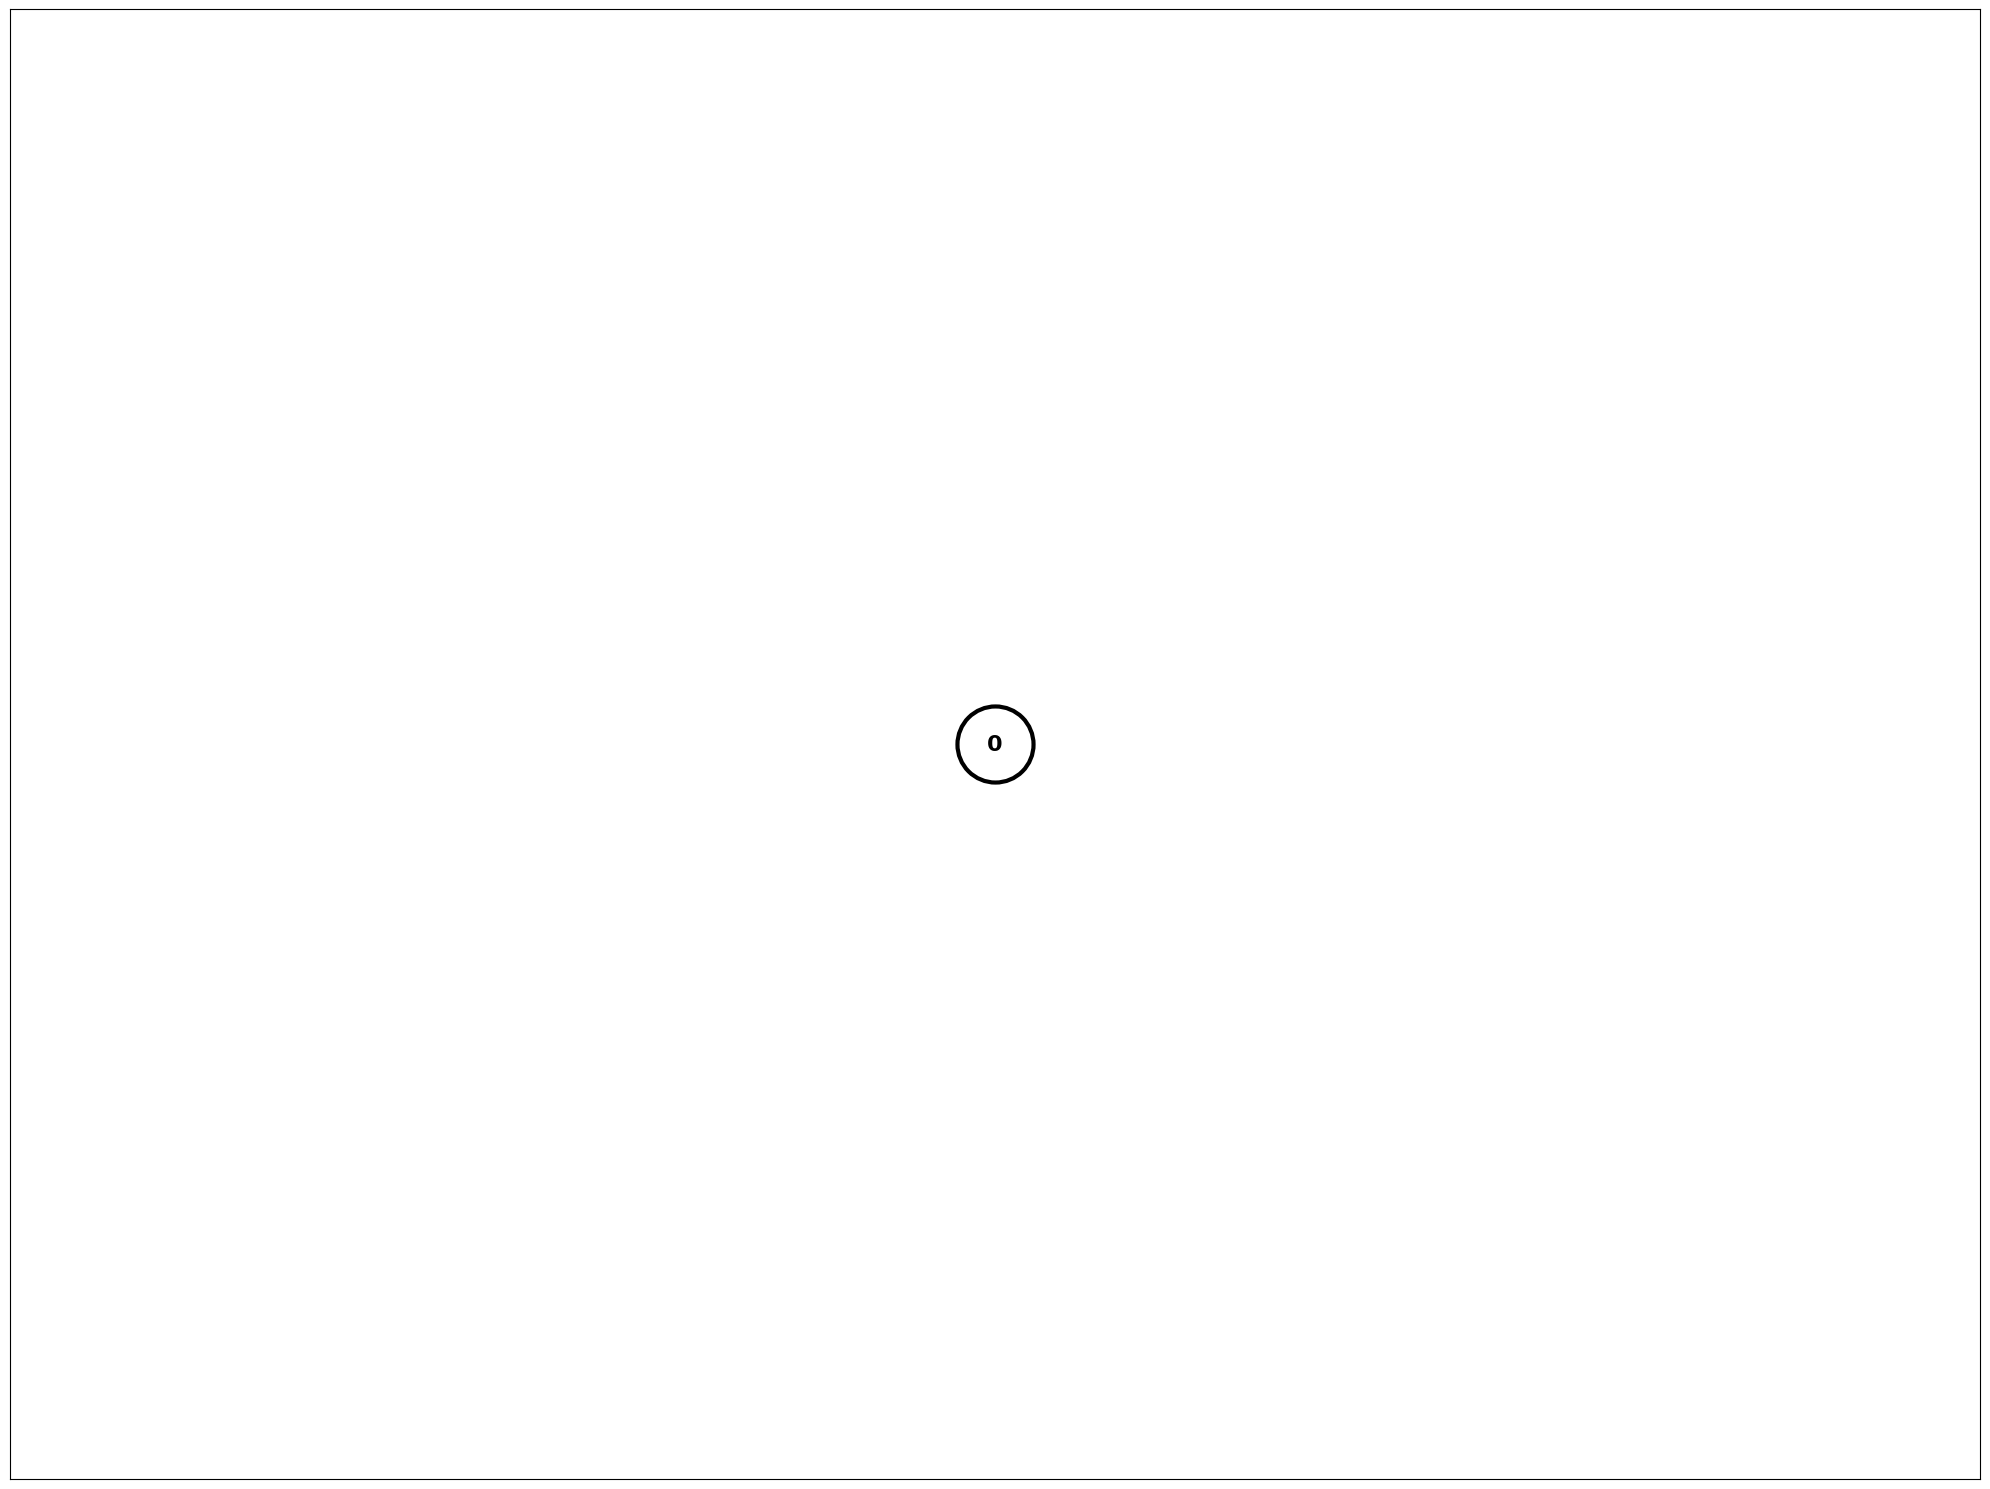

           DoF (model.nv): 7, Actuators (model.nu): 1                                            ]8;id=540631;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=483454;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

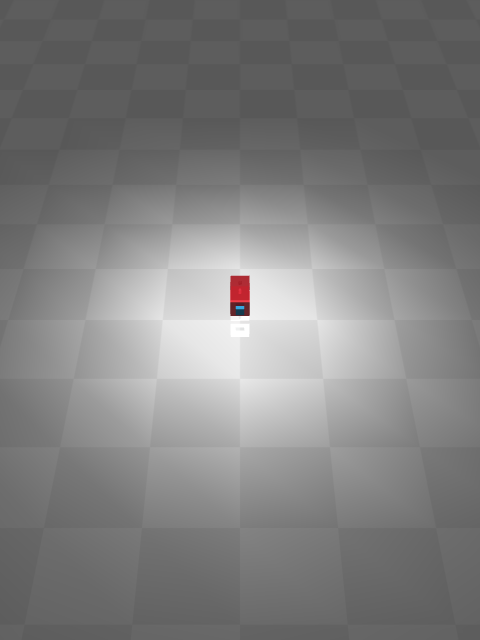

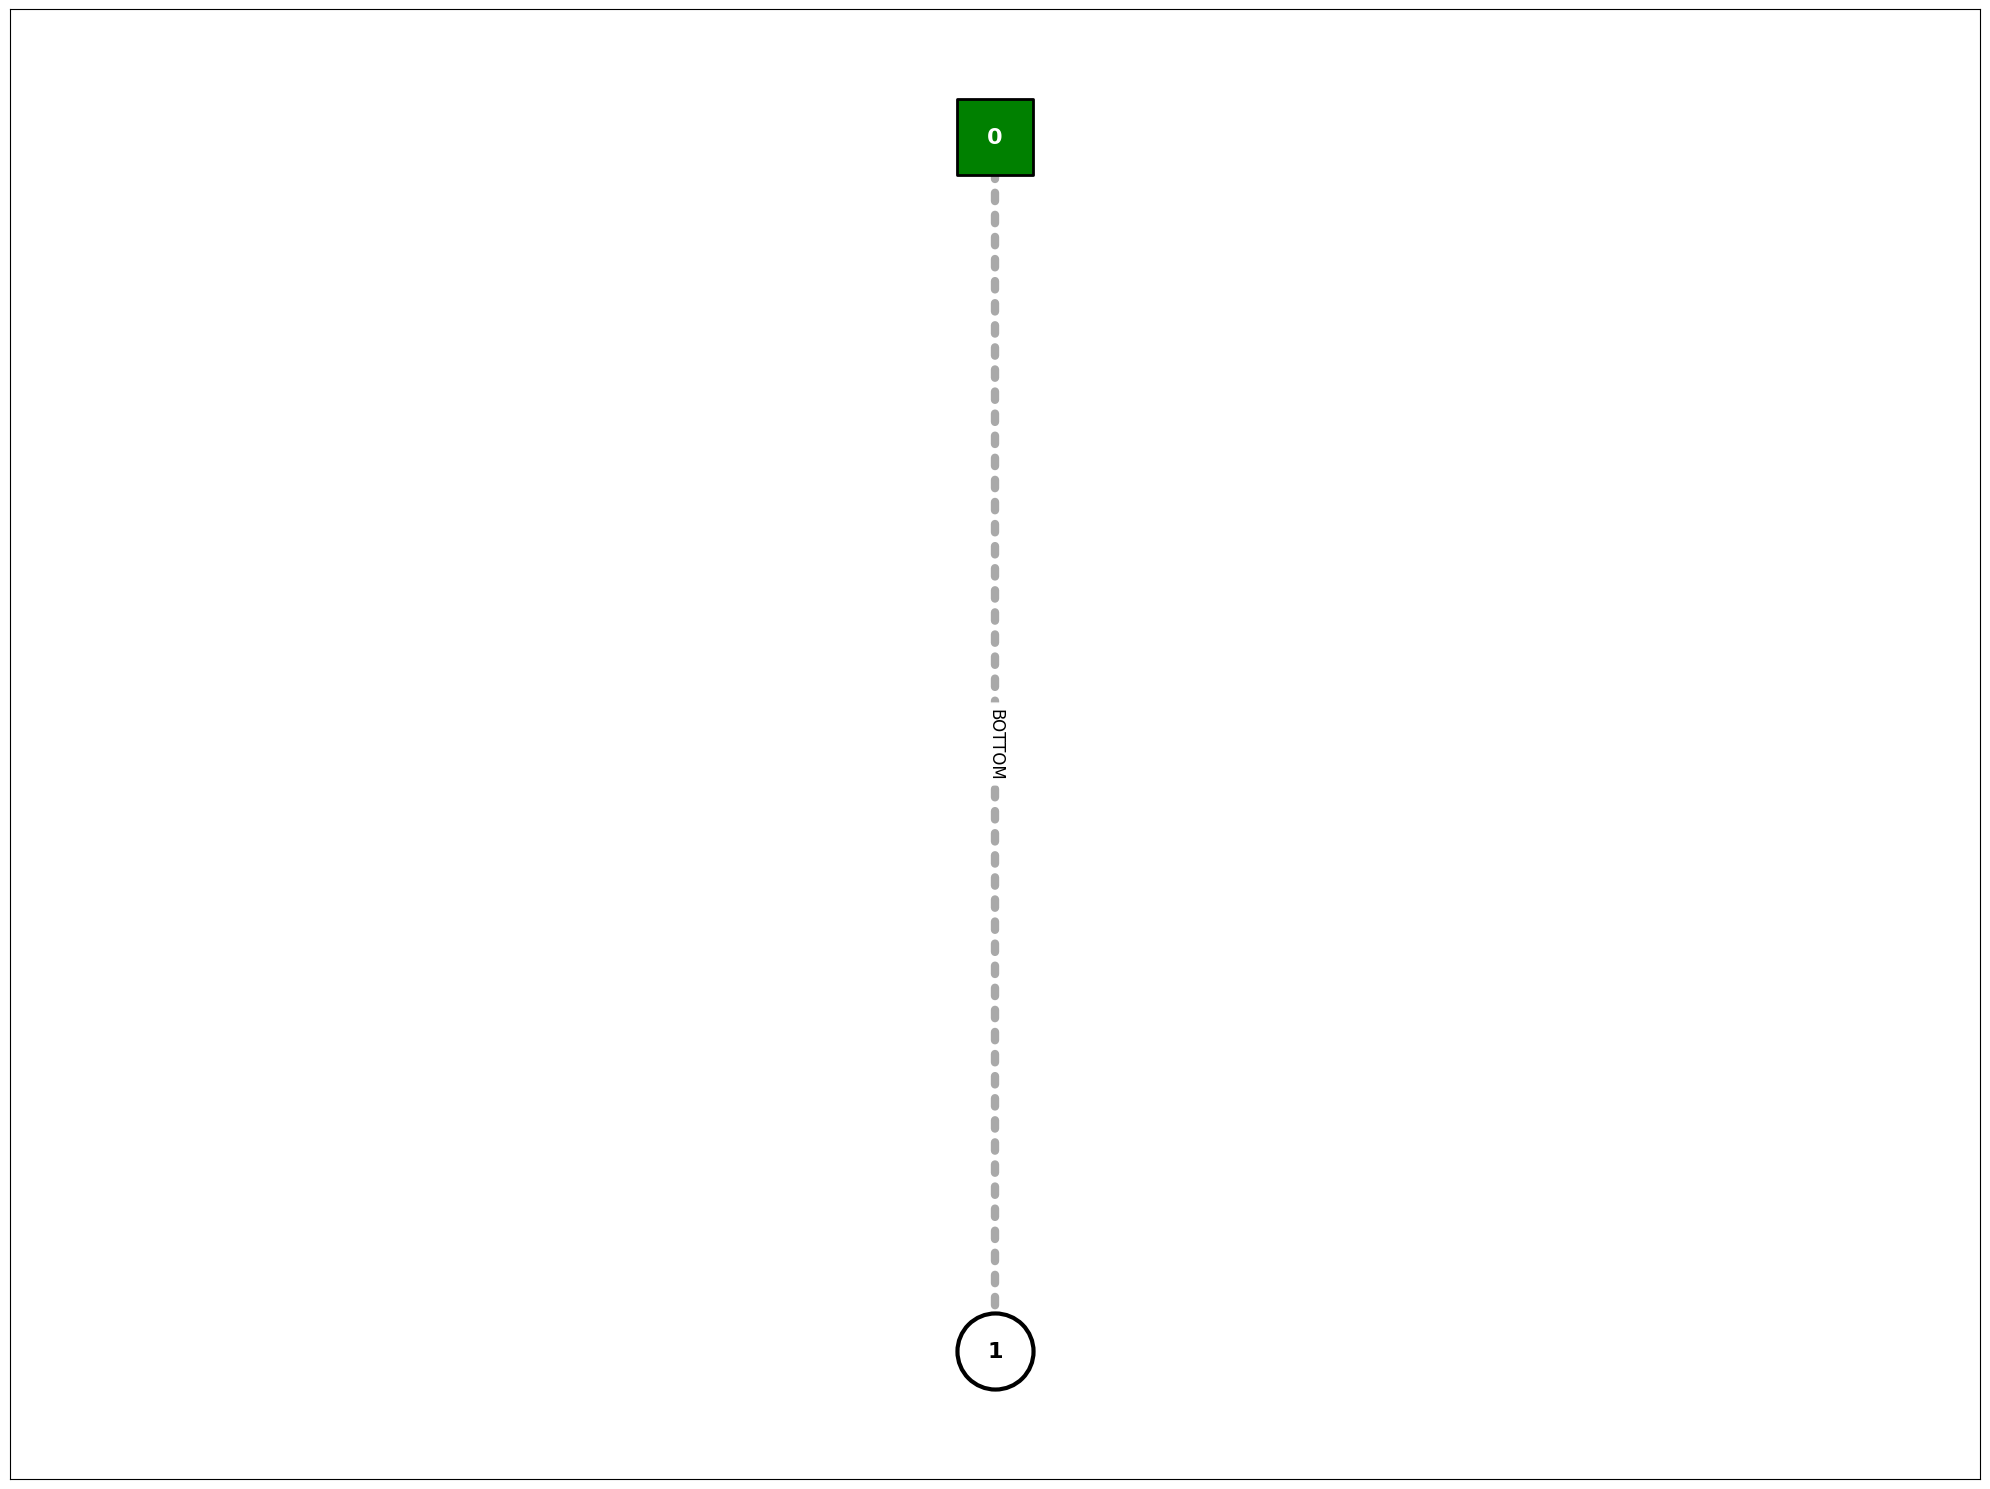

[00:23:53] DoF (model.nv): 7, Actuators (model.nu): 1                                            ]8;id=787289;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=395810;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

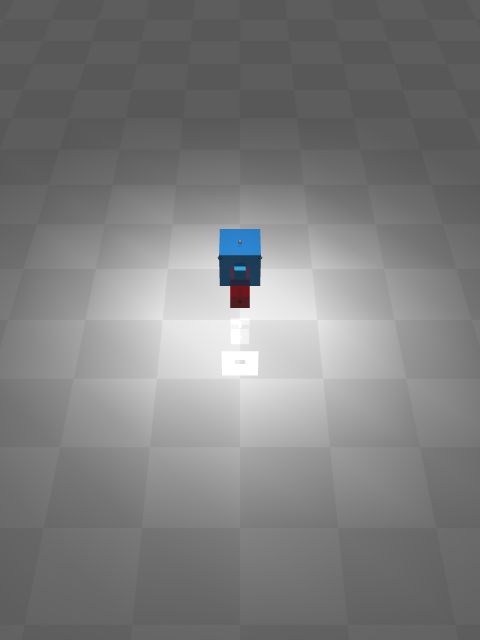

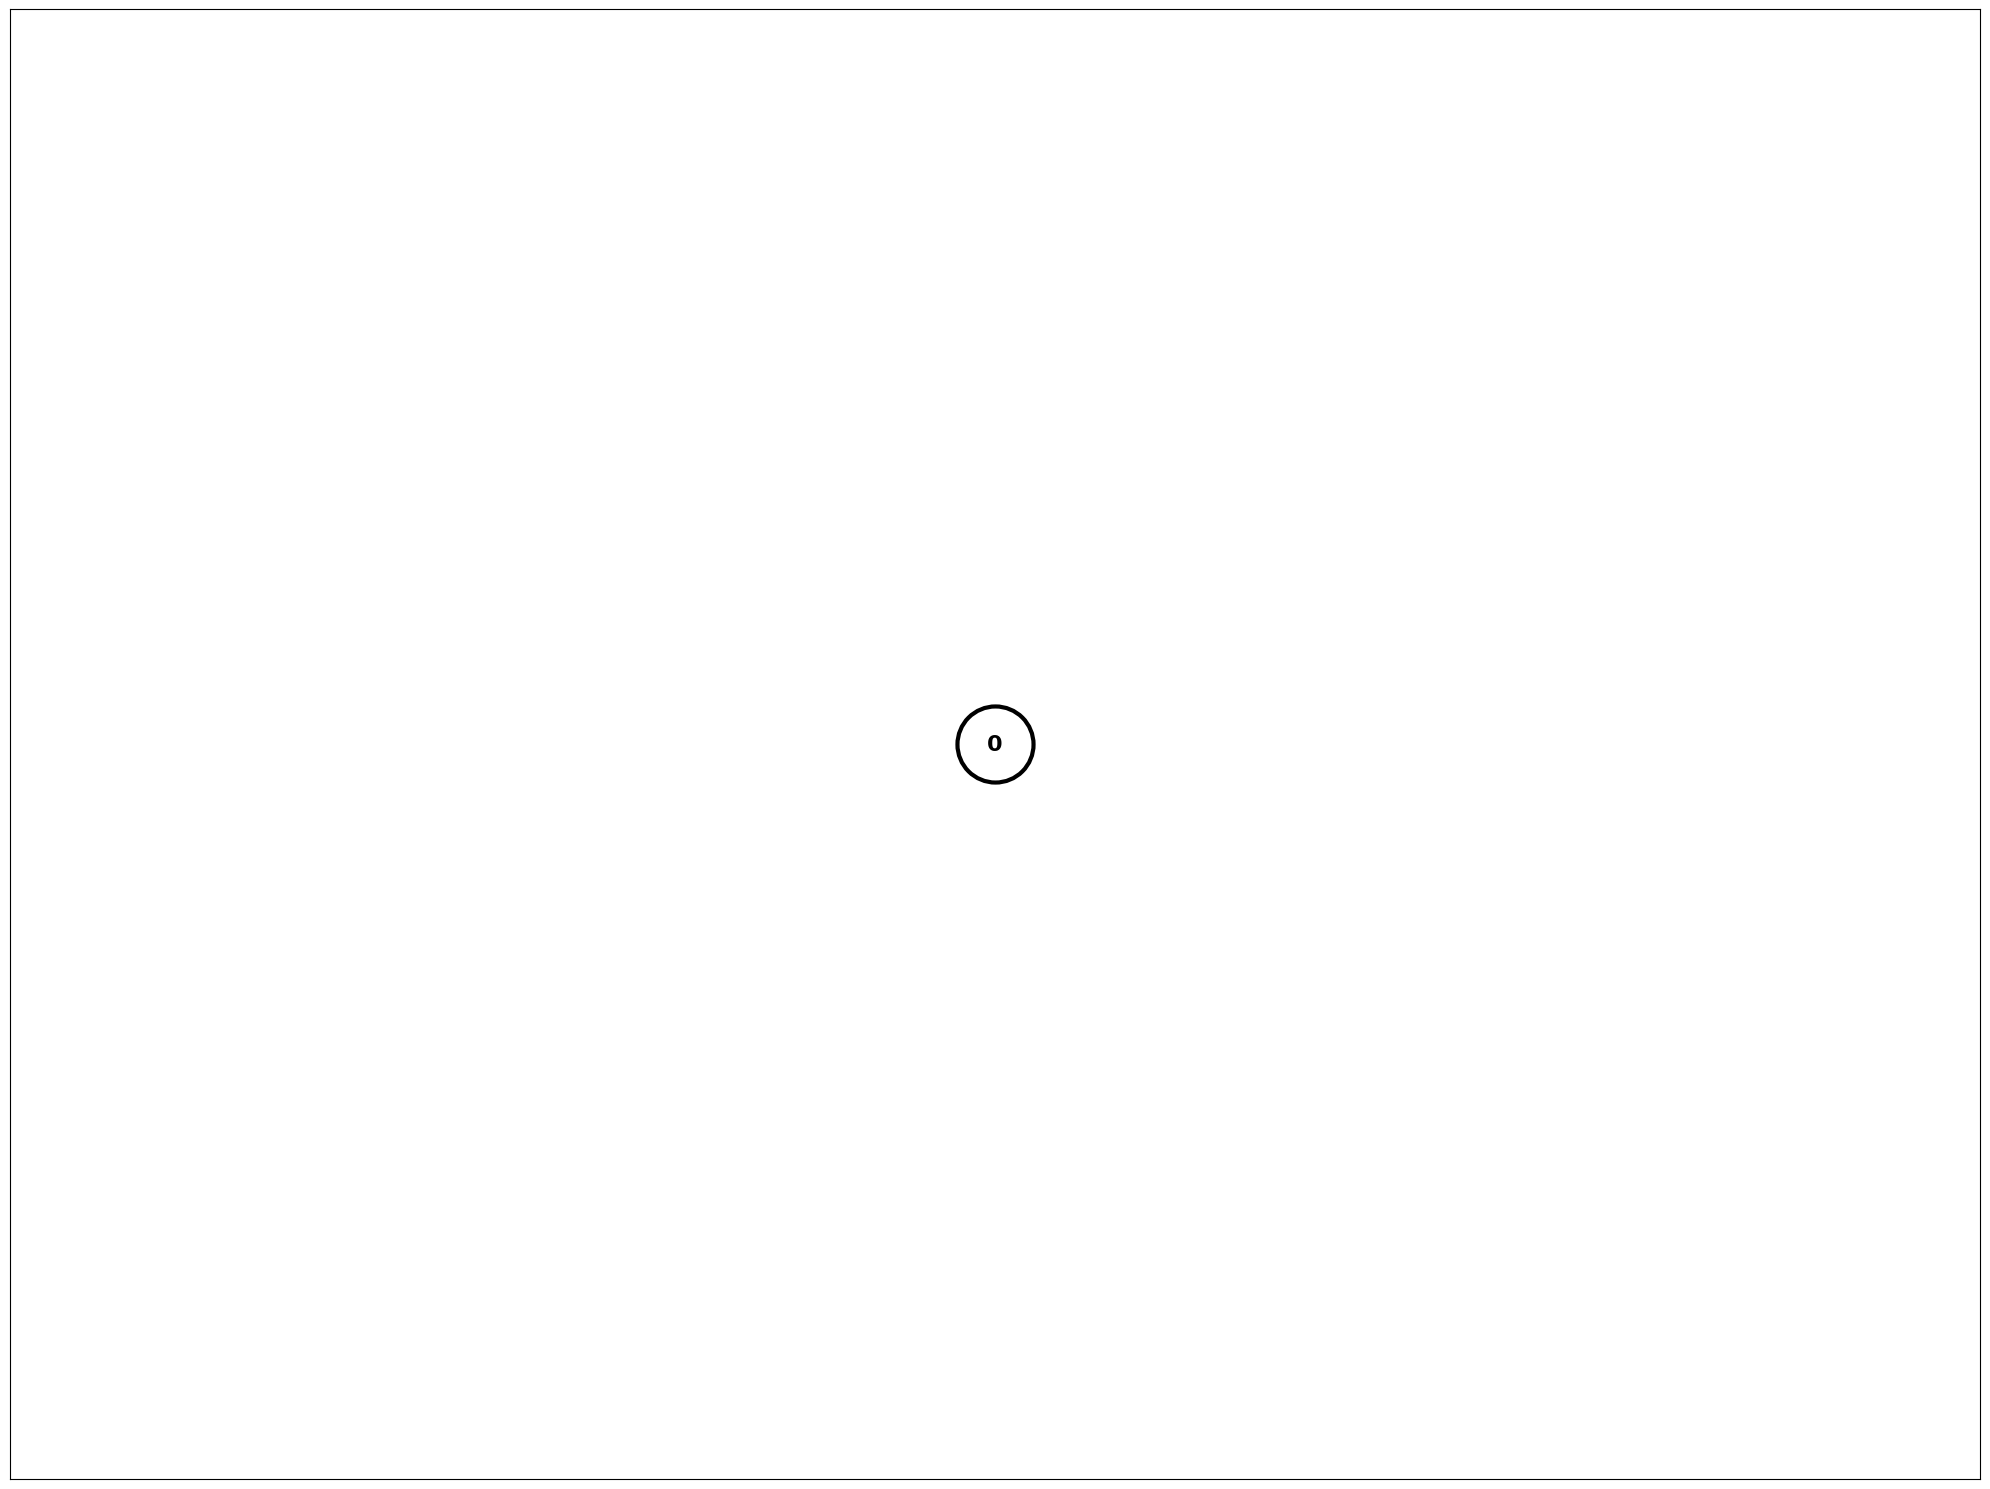

[00:23:54] DoF (model.nv): 7, Actuators (model.nu): 1                                            ]8;id=919542;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=104065;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

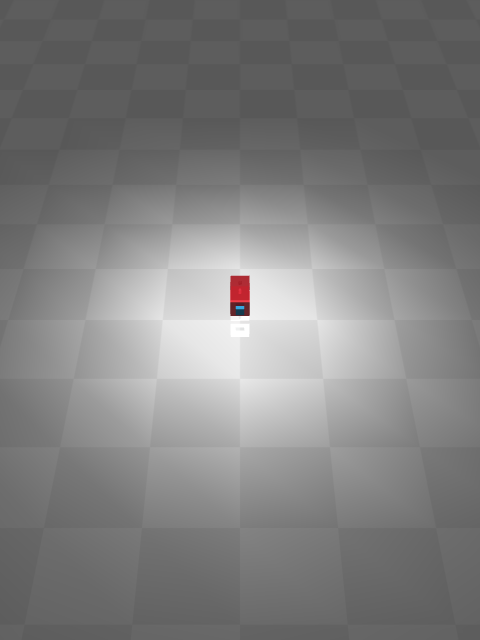

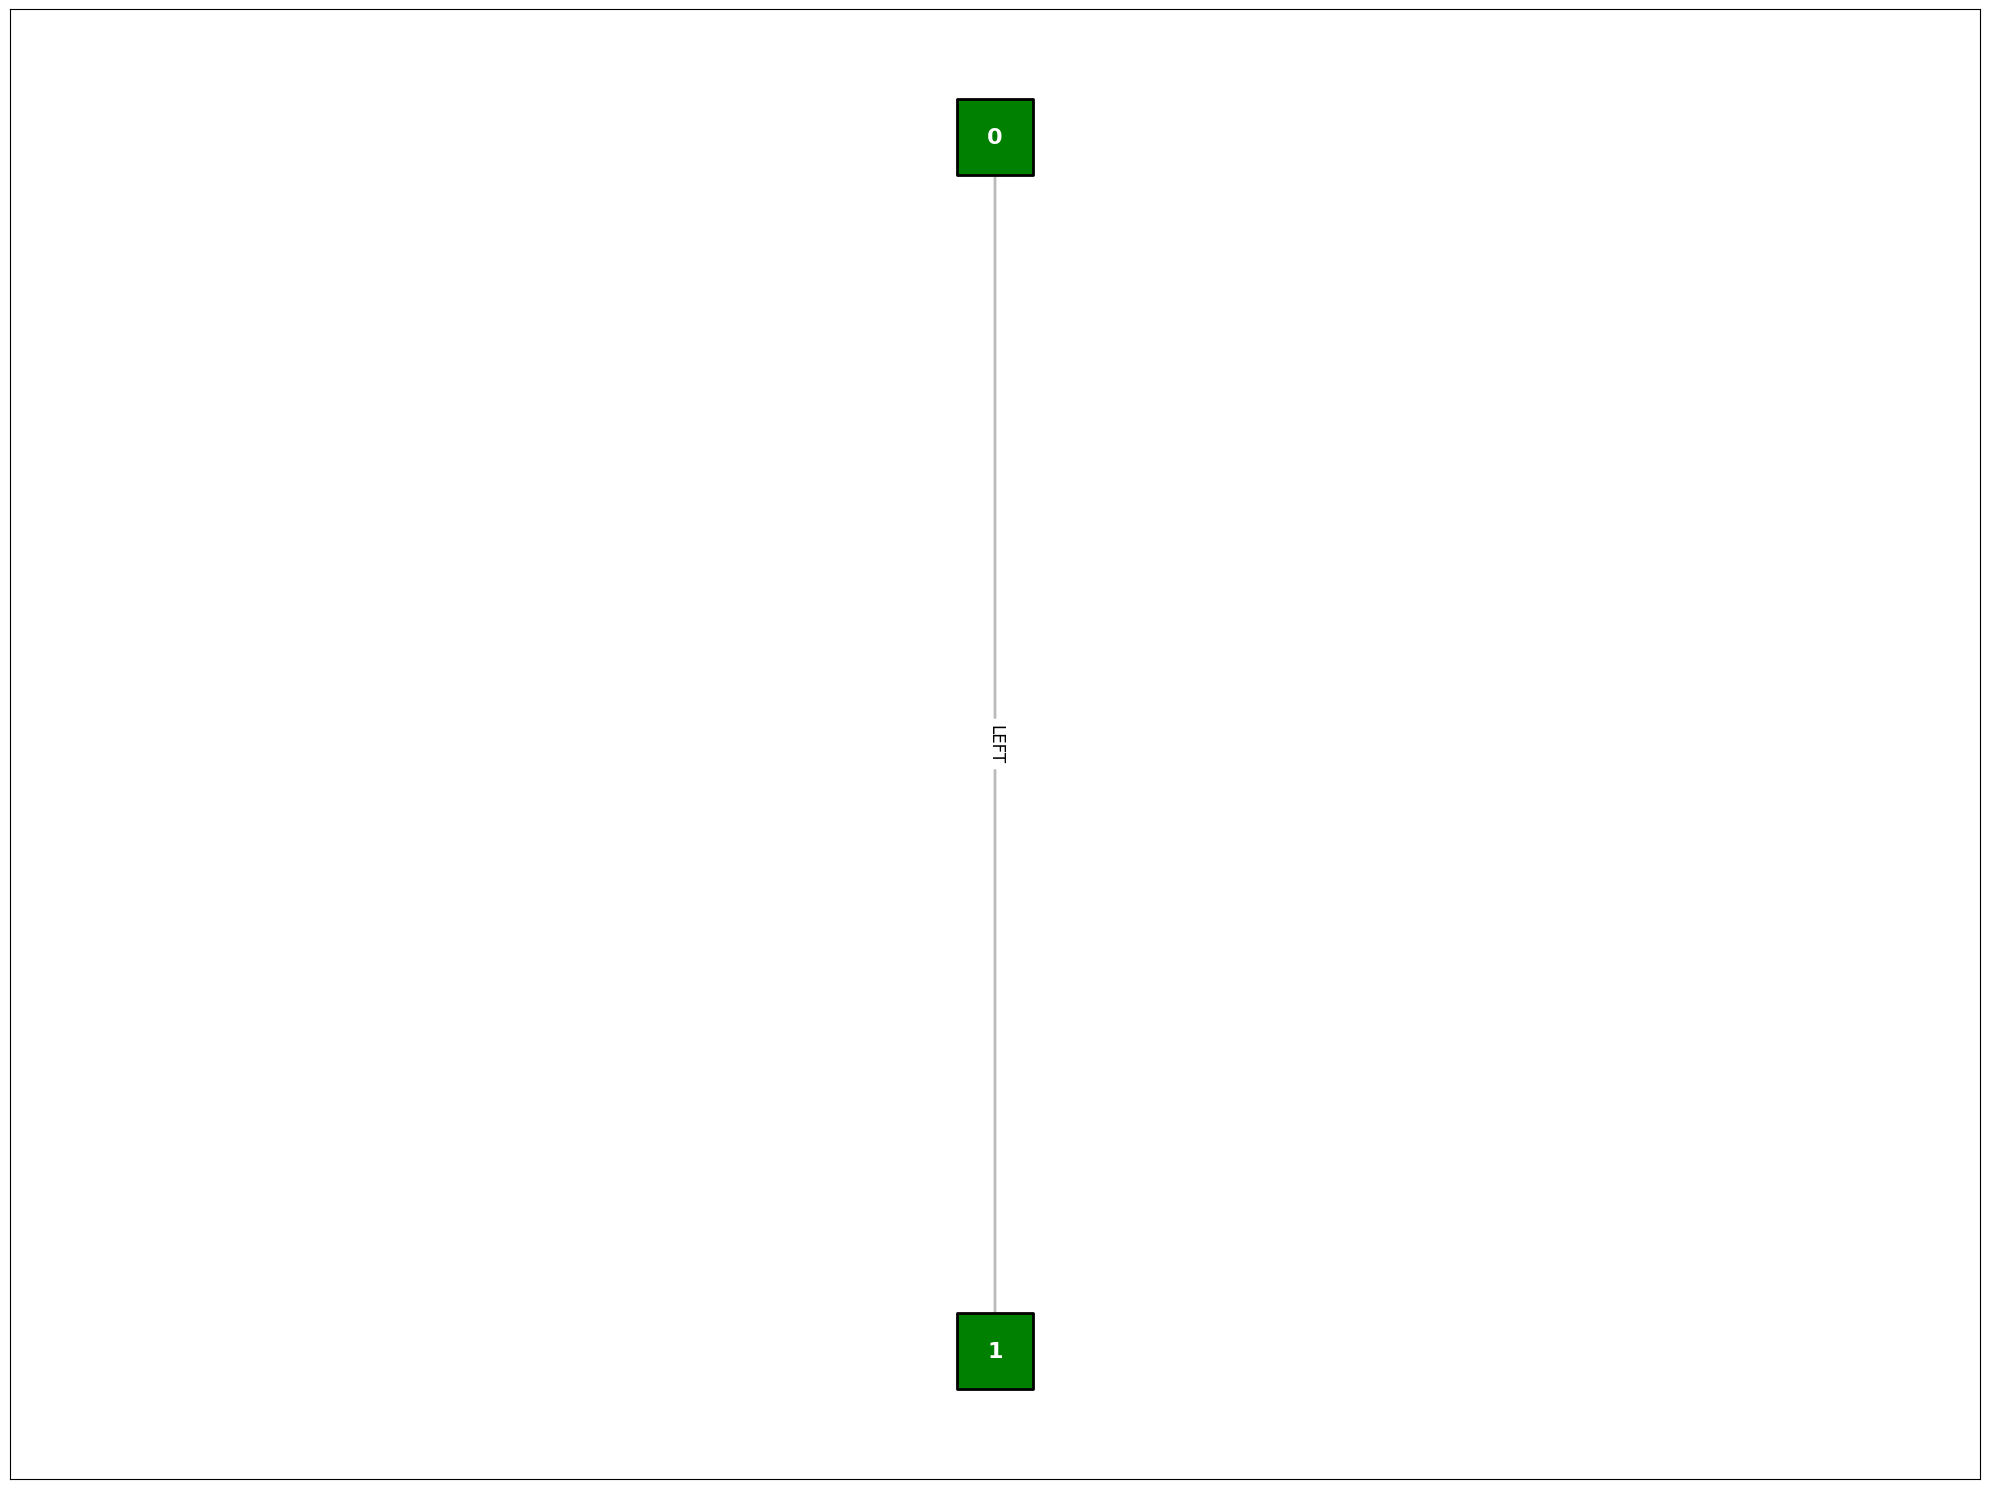

           DoF (model.nv): 6, Actuators (model.nu): 0                                            ]8;id=297191;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=50617;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

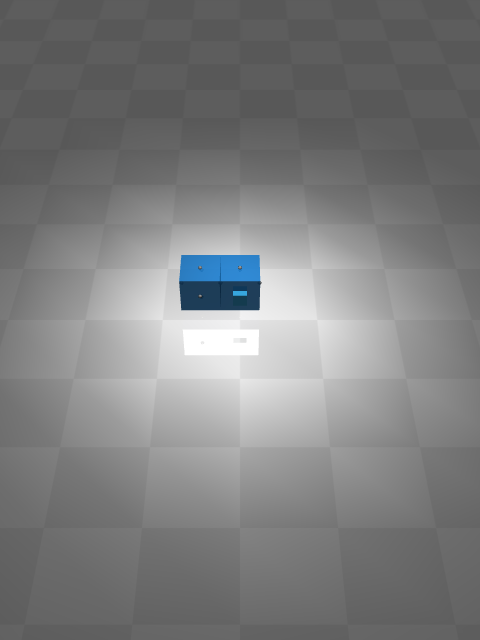

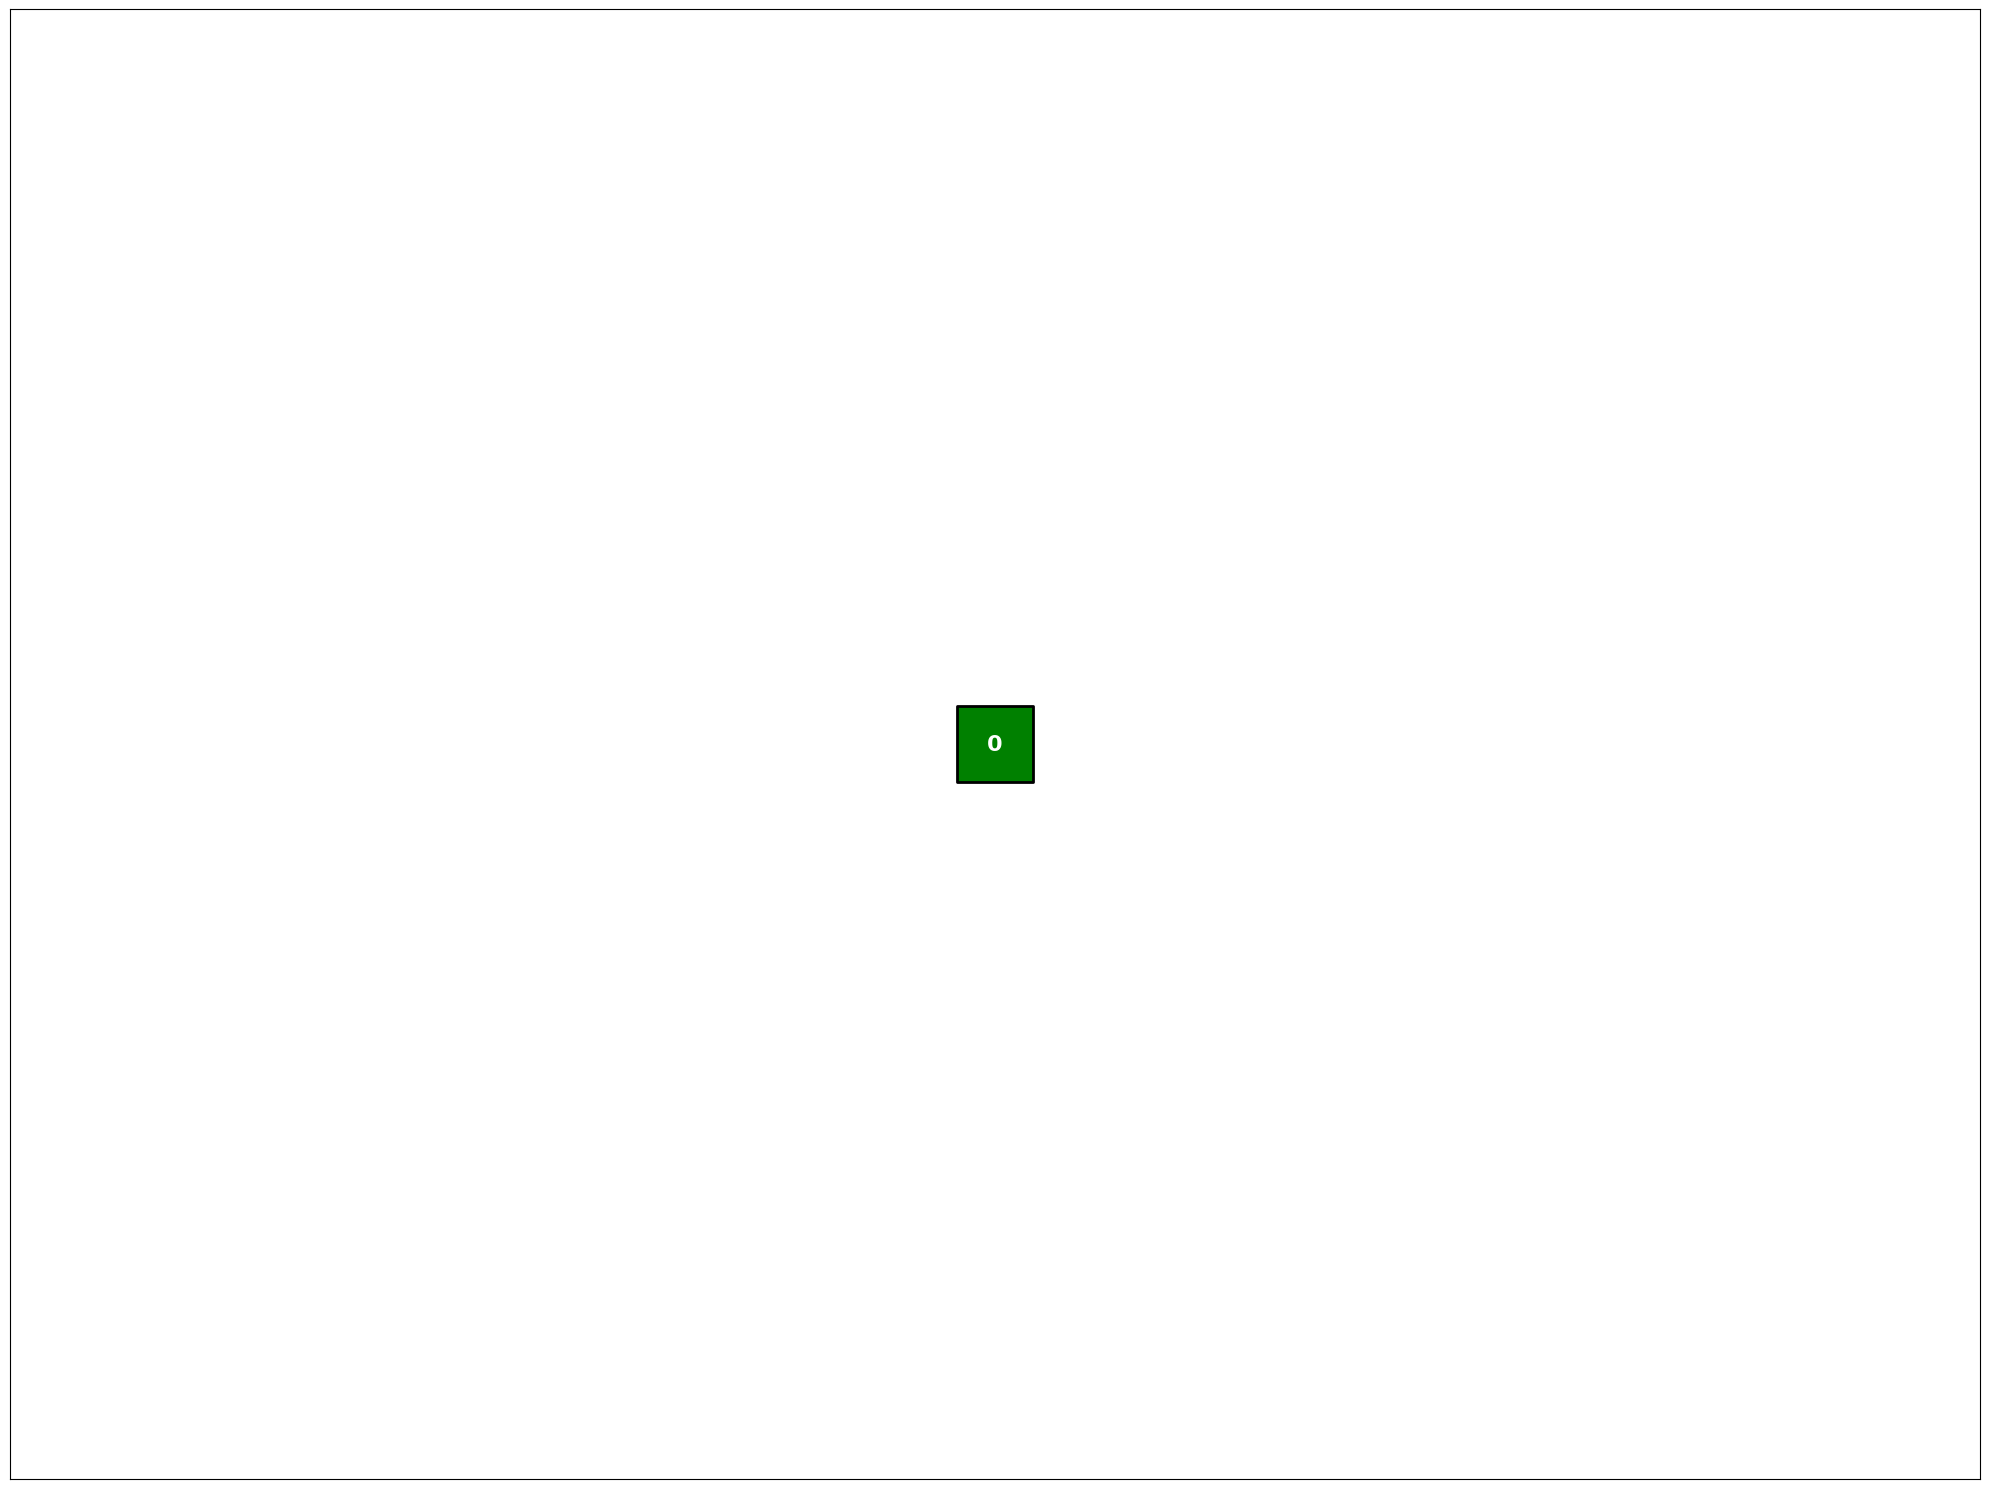

[00:23:55] DoF (model.nv): 6, Actuators (model.nu): 0                                            ]8;id=736799;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=163732;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

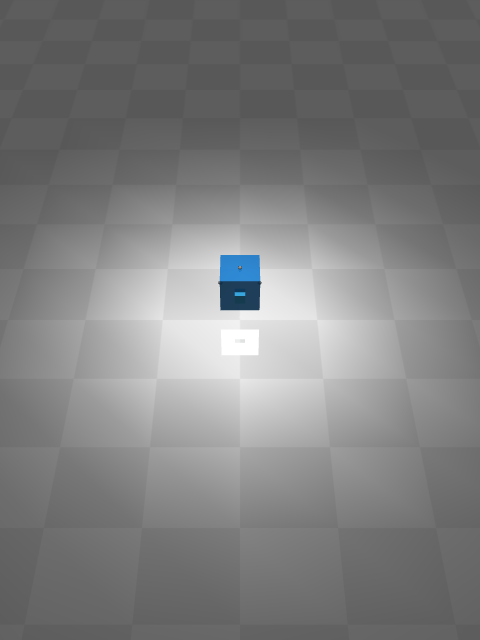

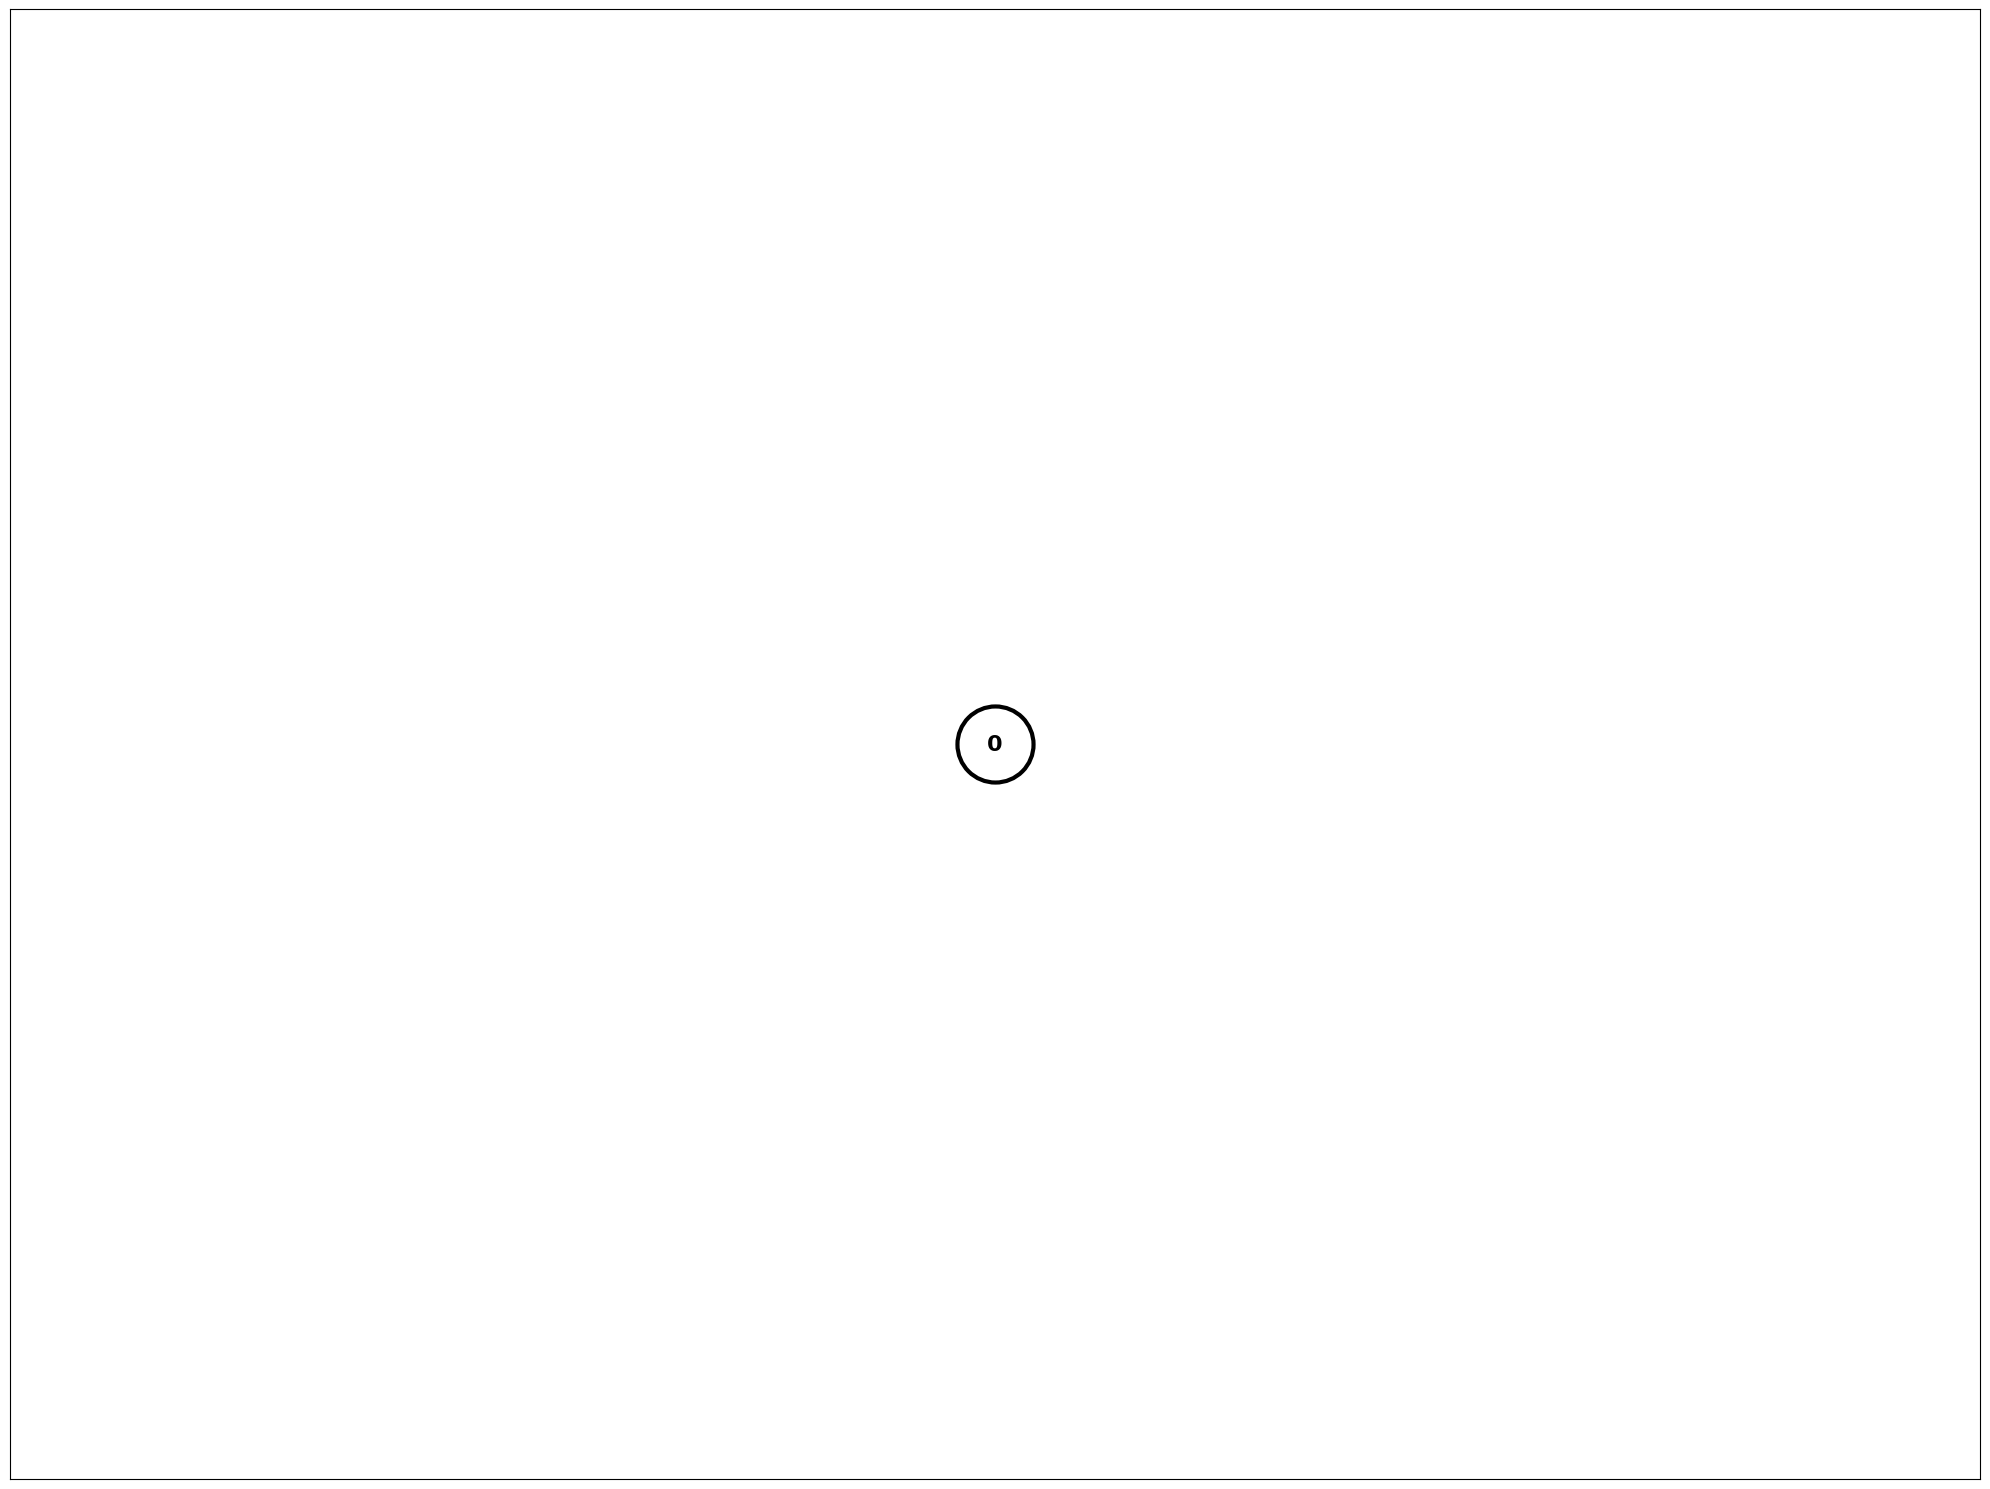

[00:23:56] DoF (model.nv): 7, Actuators (model.nu): 1                                            ]8;id=405247;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=688323;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

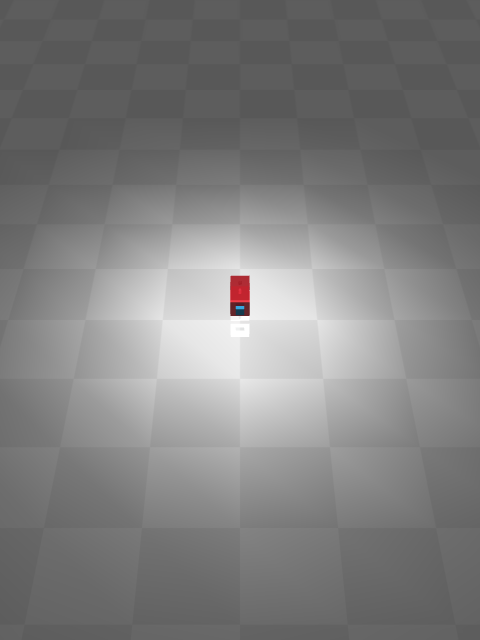

In [31]:
console.rule("STARTING SUBTREES")
for i, graph1 in enumerate(graph_list):
    canonical = CanonicalNode.from_graph(graph1)
    canonical.re_add_id()
    # print(canonical.to_graph())

    visualize_tree_from_graph(graph1)
    # if i == 0:
    view(graph1, with_viewer=False)

Test to build own robot

This shows the symmetry when modules are attached to the radial sides of the core

C{f:B{t:B1{f:B{t:H{}}l:H1{}}}b:B{t:B1{f:B{t:H{}}l:H1{}}}r:B{t:B1{f:B{t:H{}}l:H1{}}}l:B{t:B1{f:B{t:H{}}l:H1{}}}}


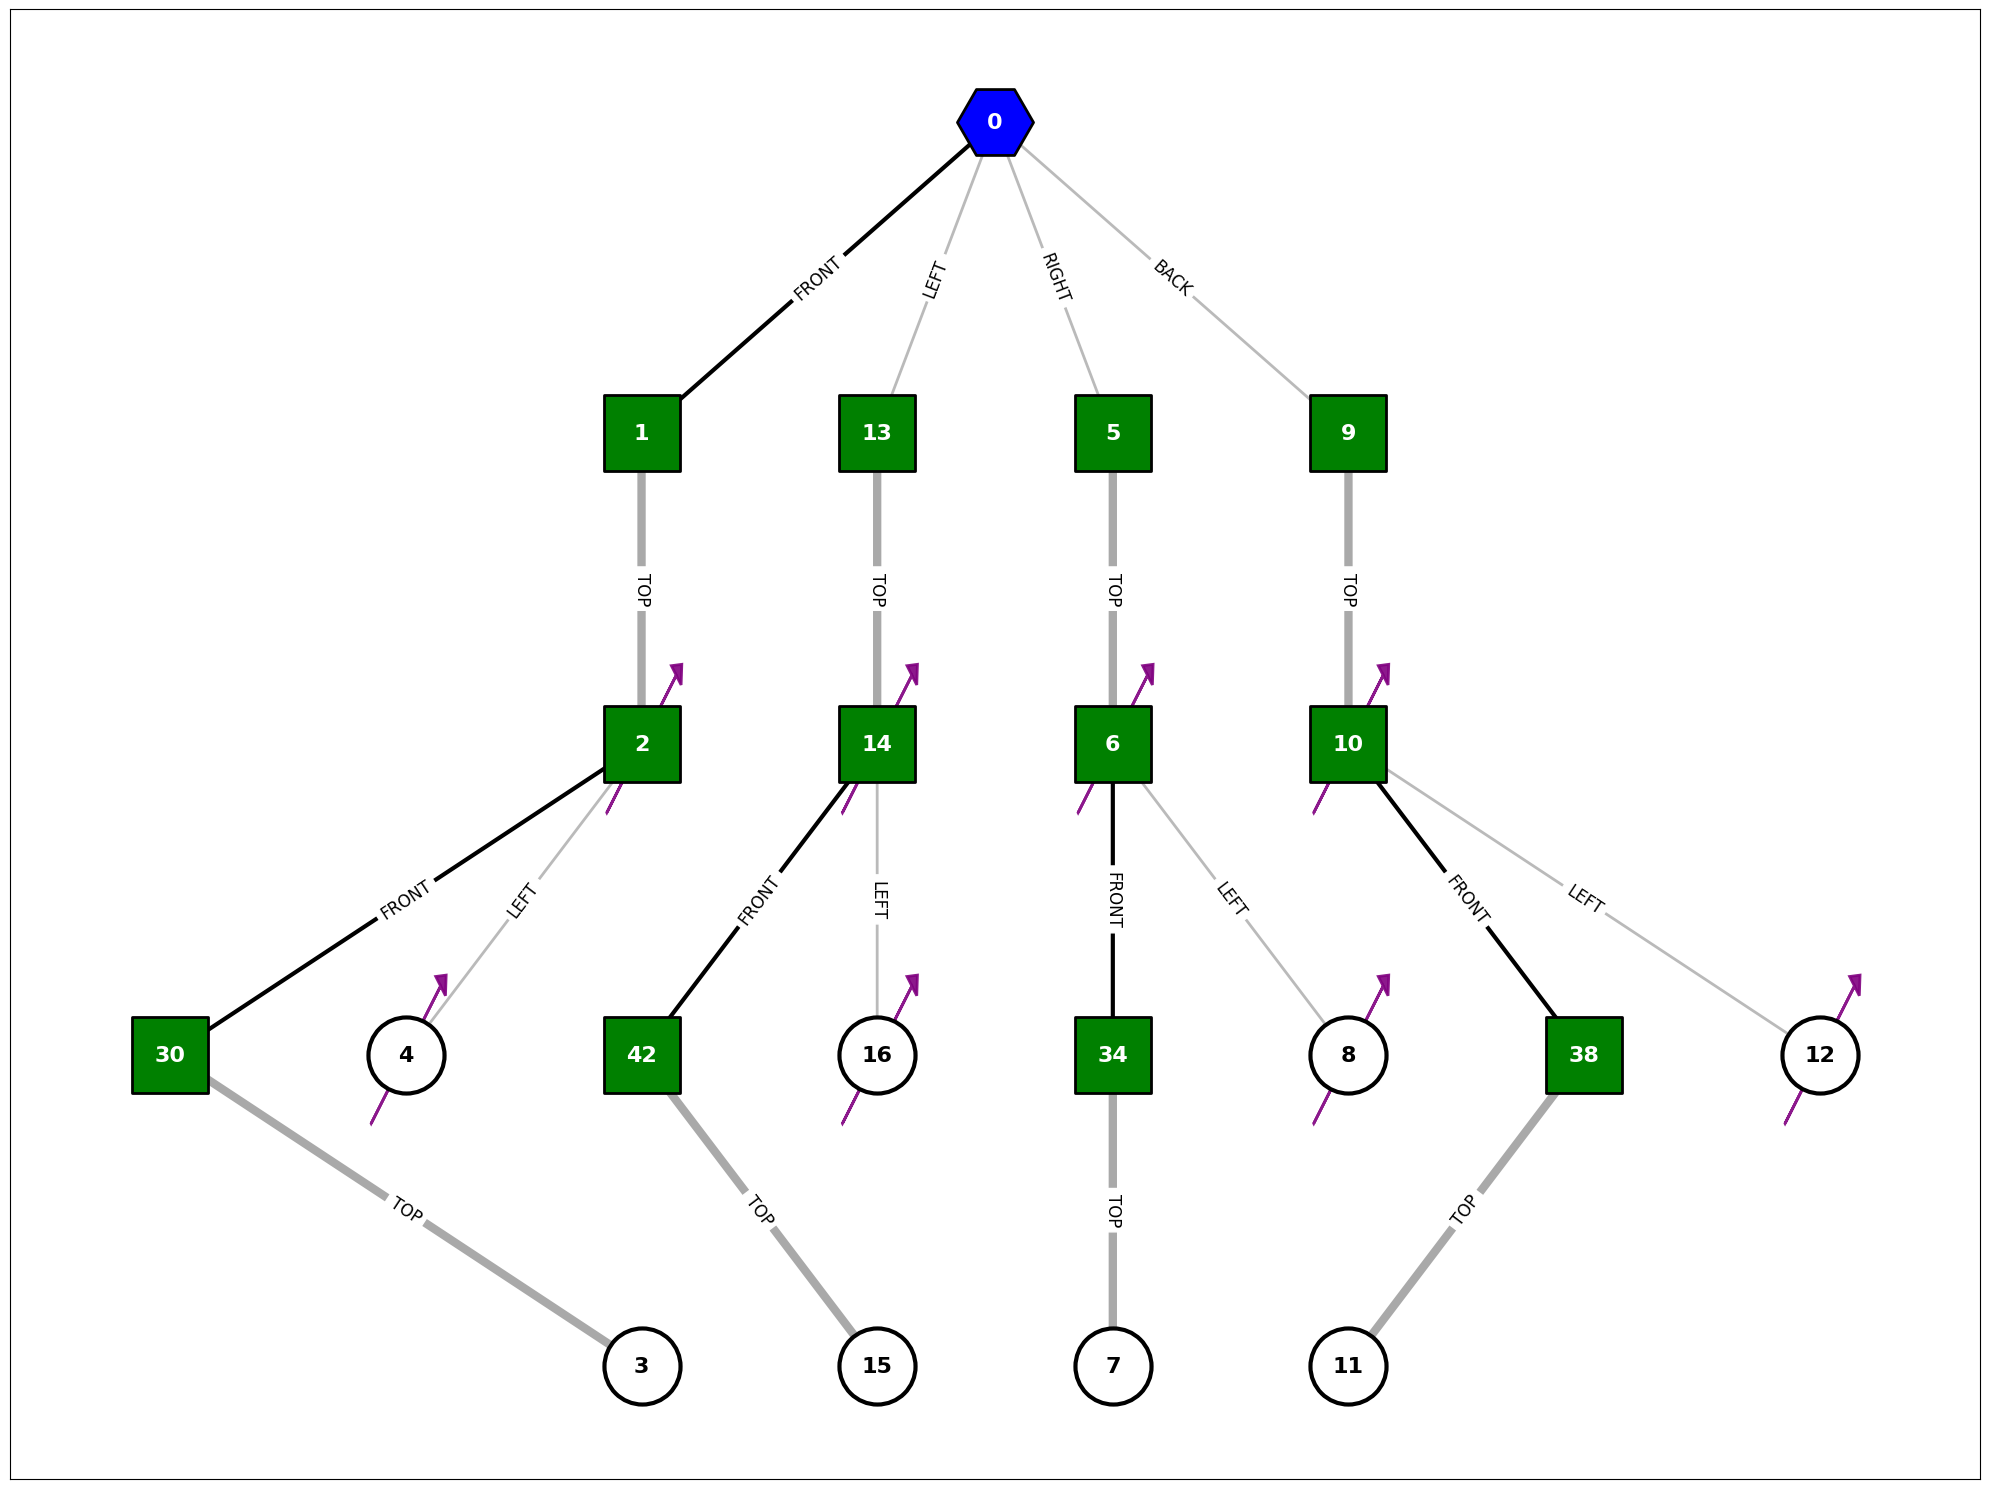

           DoF (model.nv): 14, Actuators (model.nu): 8                                           ]8;id=710828;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=591766;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

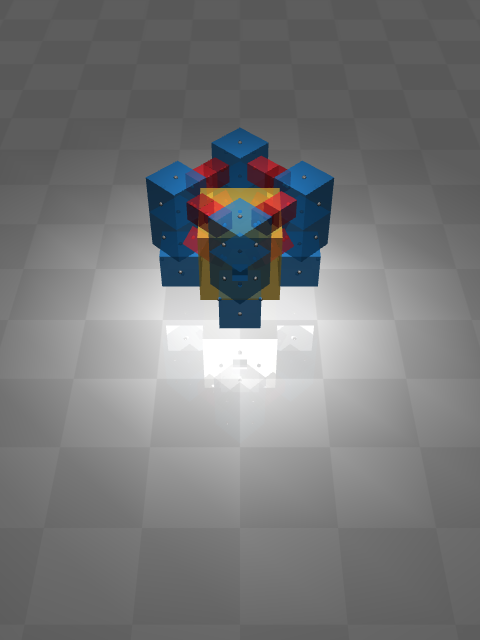

In [32]:
def give_brick(i: int) -> CanonicalNode:
    brick1 = CanonicalNode(i, ModuleType.BRICK)
    brick2 = CanonicalNode(i + 1, ModuleType.BRICK, 1)

    hinge1 = CanonicalNode(i + 2, ModuleType.HINGE)
    hinge2 = CanonicalNode(i + 3, ModuleType.HINGE, 1)

    brick3 = CanonicalNode(i + 29, ModuleType.BRICK)

    brick1.TOP = brick2
    brick2.FRONT = brick3
    brick3.TOP = hinge1
    brick2.LEFT = hinge2

    return brick1


diy_root = CanonicalNode(0, ModuleType.CORE)

diy_root.FRONT = give_brick(1)
diy_root.RIGHT = give_brick(5)
diy_root.BACK = give_brick(9)
diy_root.LEFT = give_brick(13)


diy_graph = diy_root.to_graph()

console.print(repr(diy_root))

visualize_tree_from_graph(diy_graph)
view(diy_graph, with_viewer=False)

C{f:B2{f:B1{f:B{l:H1{}t:H{}}}}b:B2{f:B1{f:B{l:H1{}t:H{}}}}r:B2{f:B1{f:B{l:H1{}t:H{}}}}l:B2{f:B1{f:B{l:H1{}t:H{}}}}}


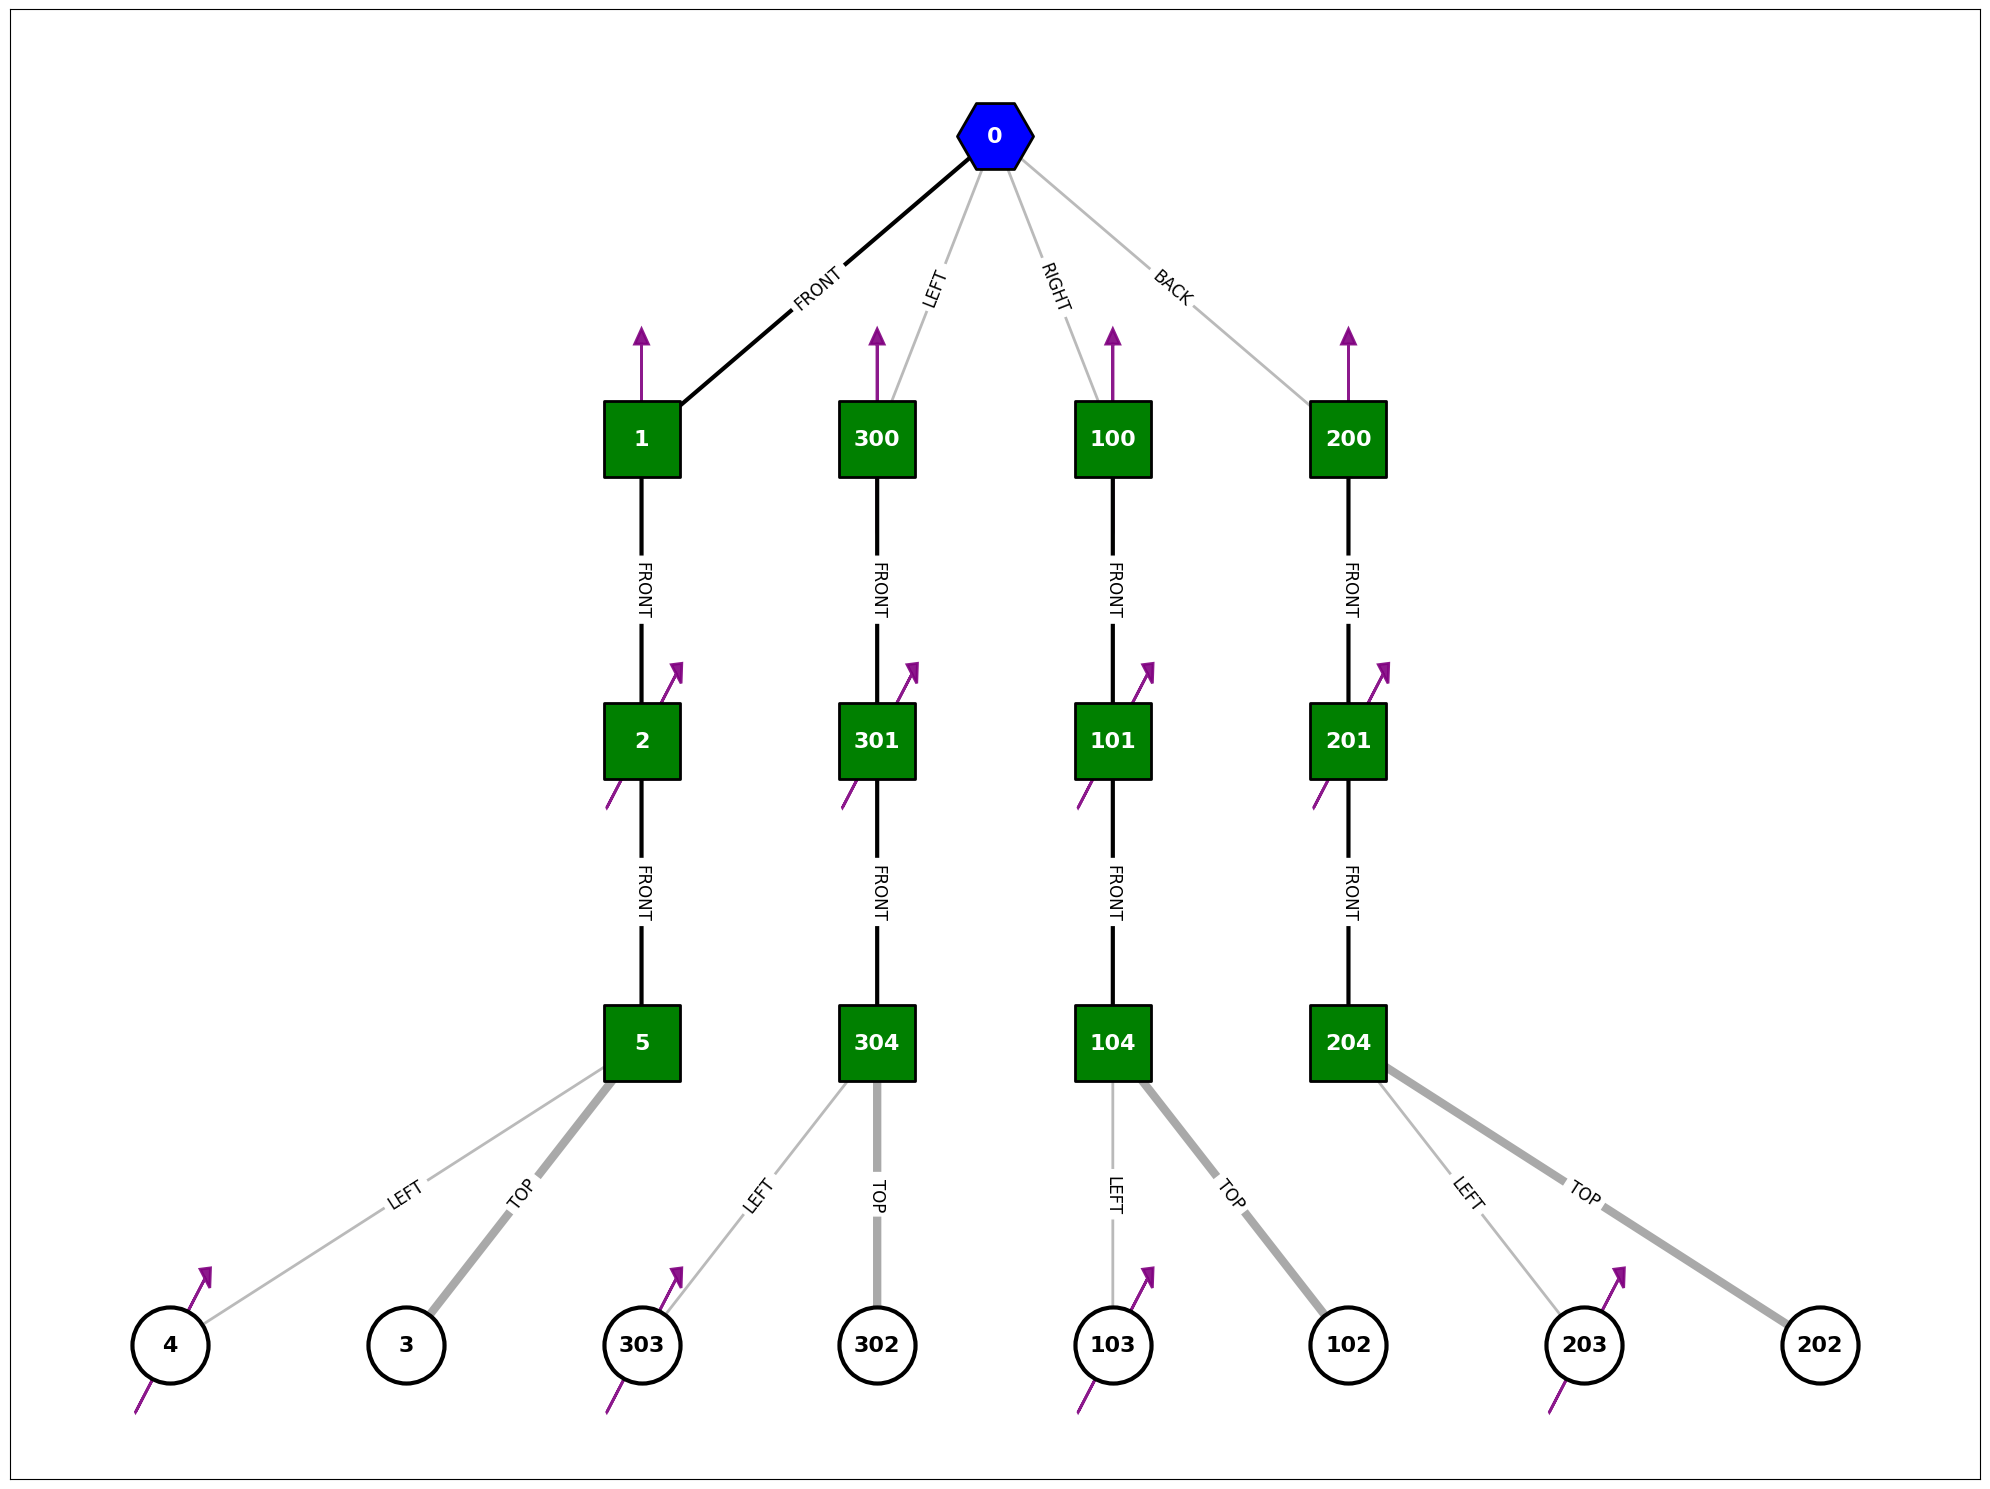

[00:23:57] DoF (model.nv): 14, Actuators (model.nu): 8                                           ]8;id=344154;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=146636;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

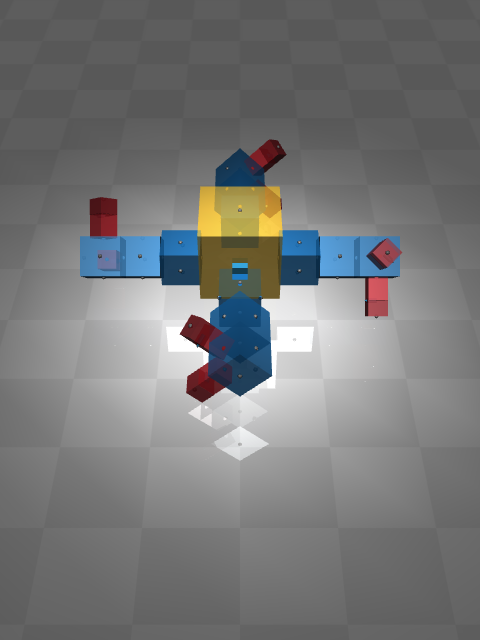

In [33]:
def give_brick(start_id: int, depth: int = 0, max_depth: int = 0) -> tuple[CanonicalNode, int]:    
    brick1 = CanonicalNode(start_id, ModuleType.BRICK, 2)
    brick2 = CanonicalNode(start_id + 1, ModuleType.BRICK, 1)
    hinge1 = CanonicalNode(start_id + 2, ModuleType.HINGE)
    hinge2 = CanonicalNode(start_id + 3, ModuleType.HINGE, 1)
    brick3 = CanonicalNode(start_id + 4, ModuleType.BRICK)
        
    next_id = start_id + 5
    
    brick1.FRONT = brick2
    brick2.FRONT = brick3
    brick3.TOP = hinge1
    brick3.LEFT = hinge2
        
    if depth < max_depth:
        recursive_brick, next_id = give_brick(next_id, depth + 1, max_depth)
        hinge1.FRONT = recursive_brick

    return brick1, next_id


diy_root = CanonicalNode(0, ModuleType.CORE)

# Unpack the tuple to get just the CanonicalNode
front_brick, _ = give_brick(1)
diy_root.FRONT = front_brick

right_brick, _ = give_brick(100)
diy_root.RIGHT = right_brick

back_brick, _ = give_brick(200)
diy_root.BACK = back_brick

left_brick, _ = give_brick(300)
diy_root.LEFT = left_brick


diy_graph = diy_root.to_graph()

console.print(repr(diy_root))

visualize_tree_from_graph(diy_graph)
view(diy_graph, with_viewer=False)

False 300
False 301
False 304
False 200
False 201
False 204
False 100
False 101
False 104
False 1
False 2
False 5


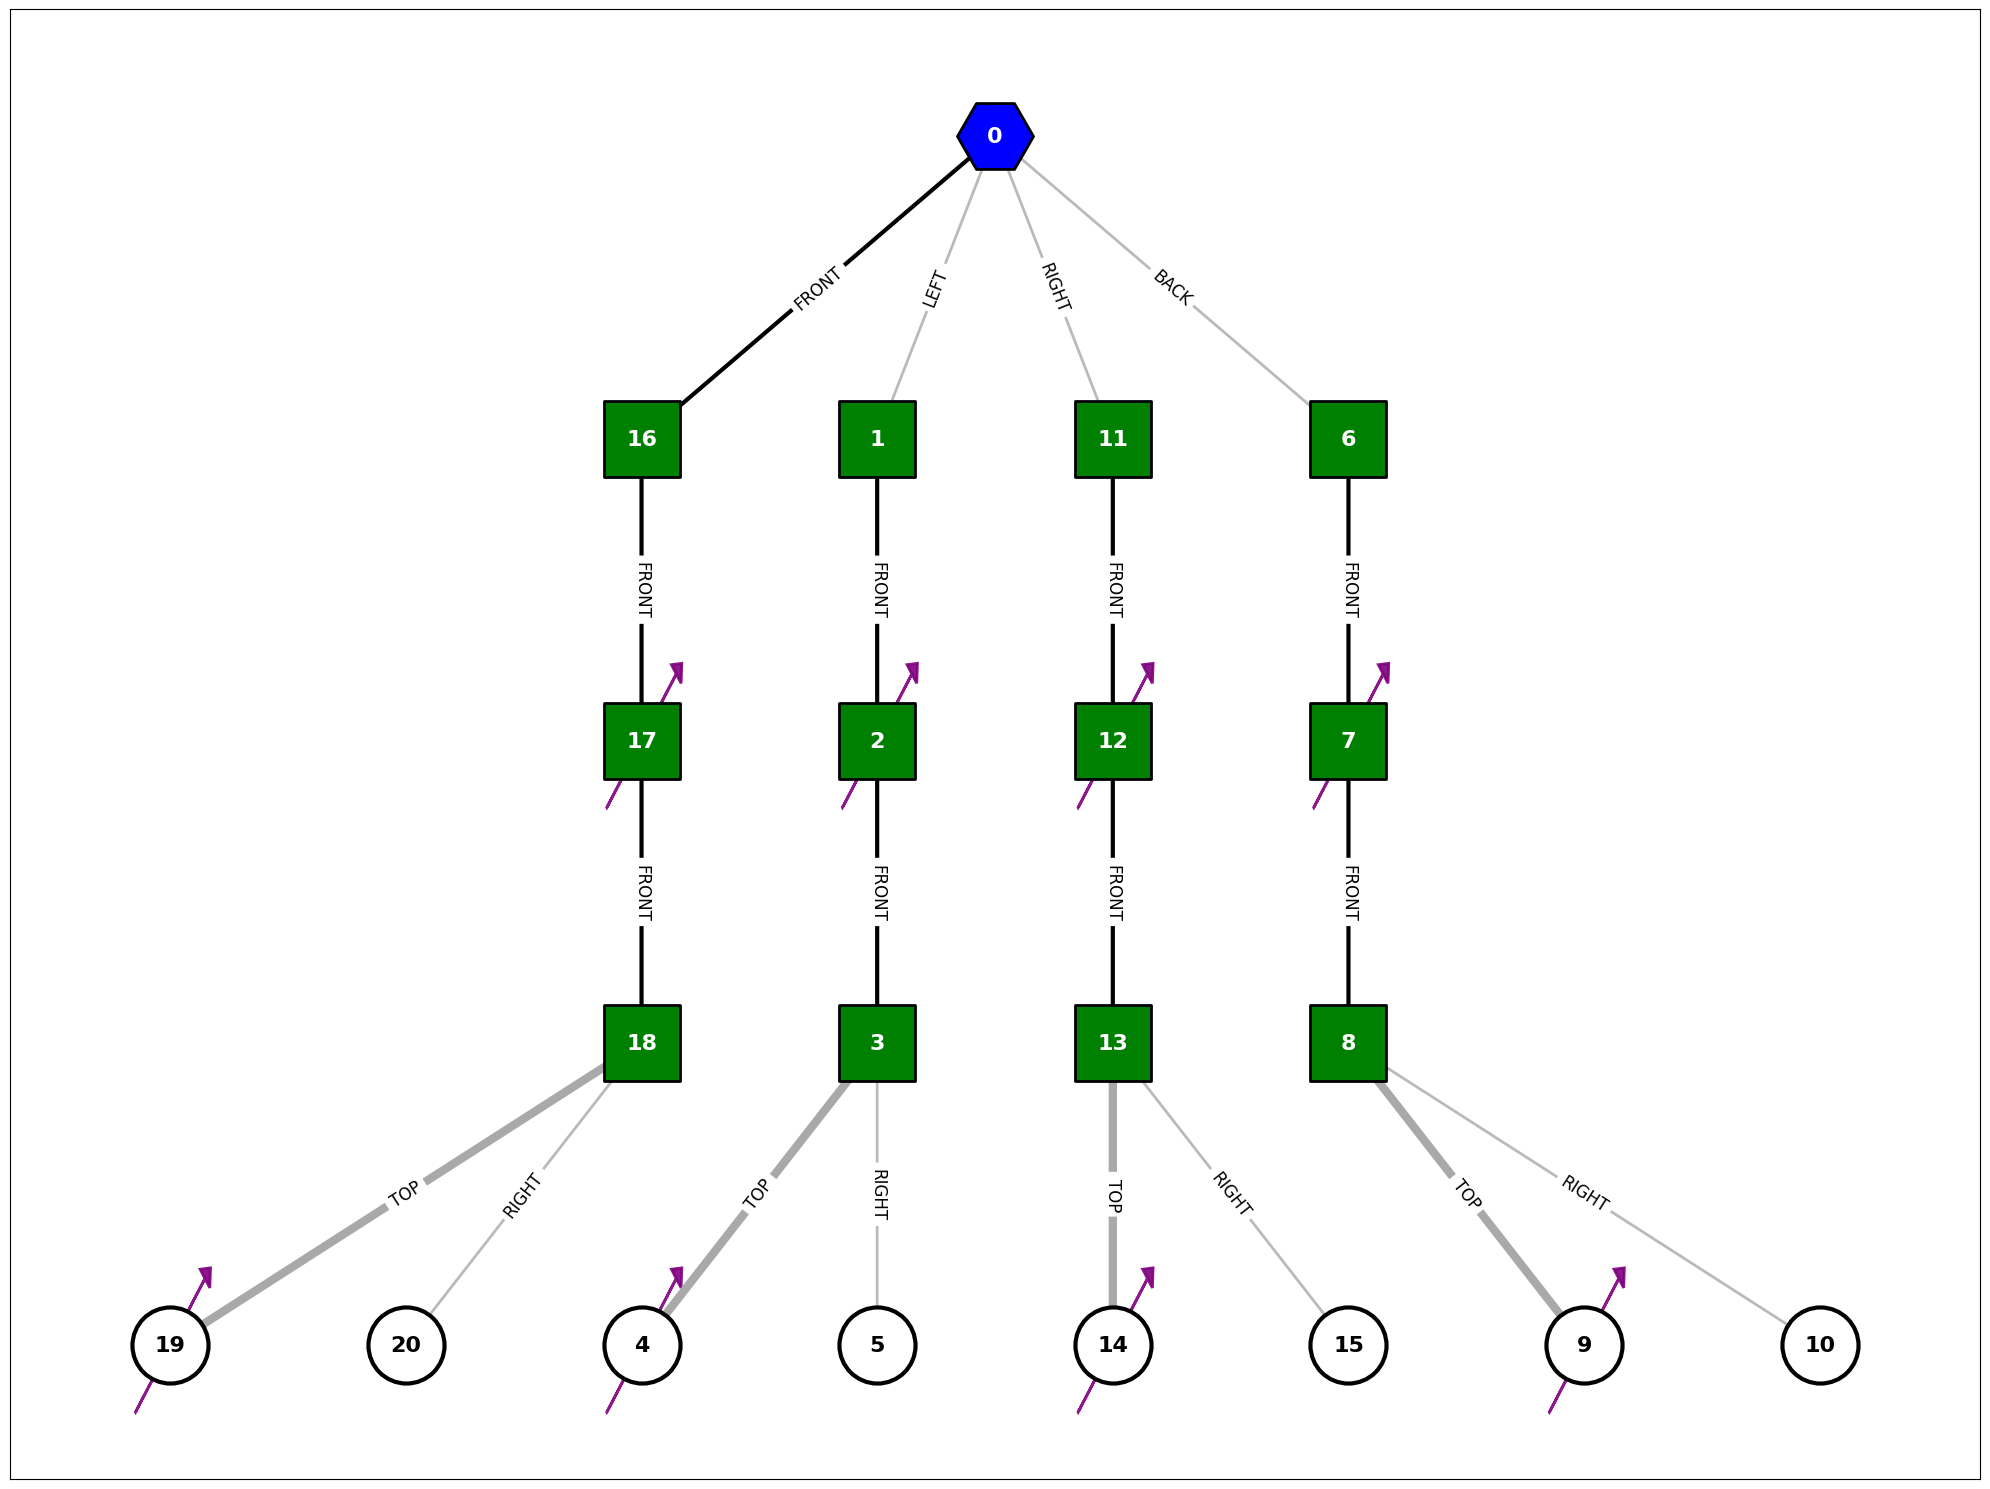

[00:23:58] DoF (model.nv): 14, Actuators (model.nu): 8                                           ]8;id=269450;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=559047;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

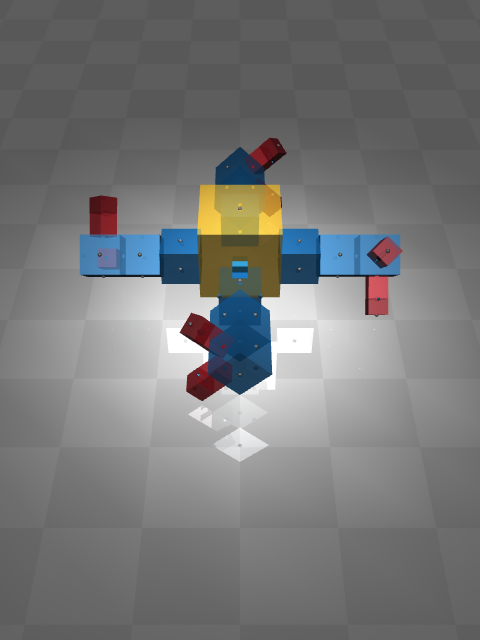

In [34]:
diy1_list = diy_root.depth_first_collect()

visualize_tree_from_graph(diy1_list[0])
view(diy1_list[0], with_viewer=False)

C{t:B2{r:B3{l:H1{}t:H{}b:B{}}}b:B2{r:B3{l:H1{}t:H{}b:B{}}}}


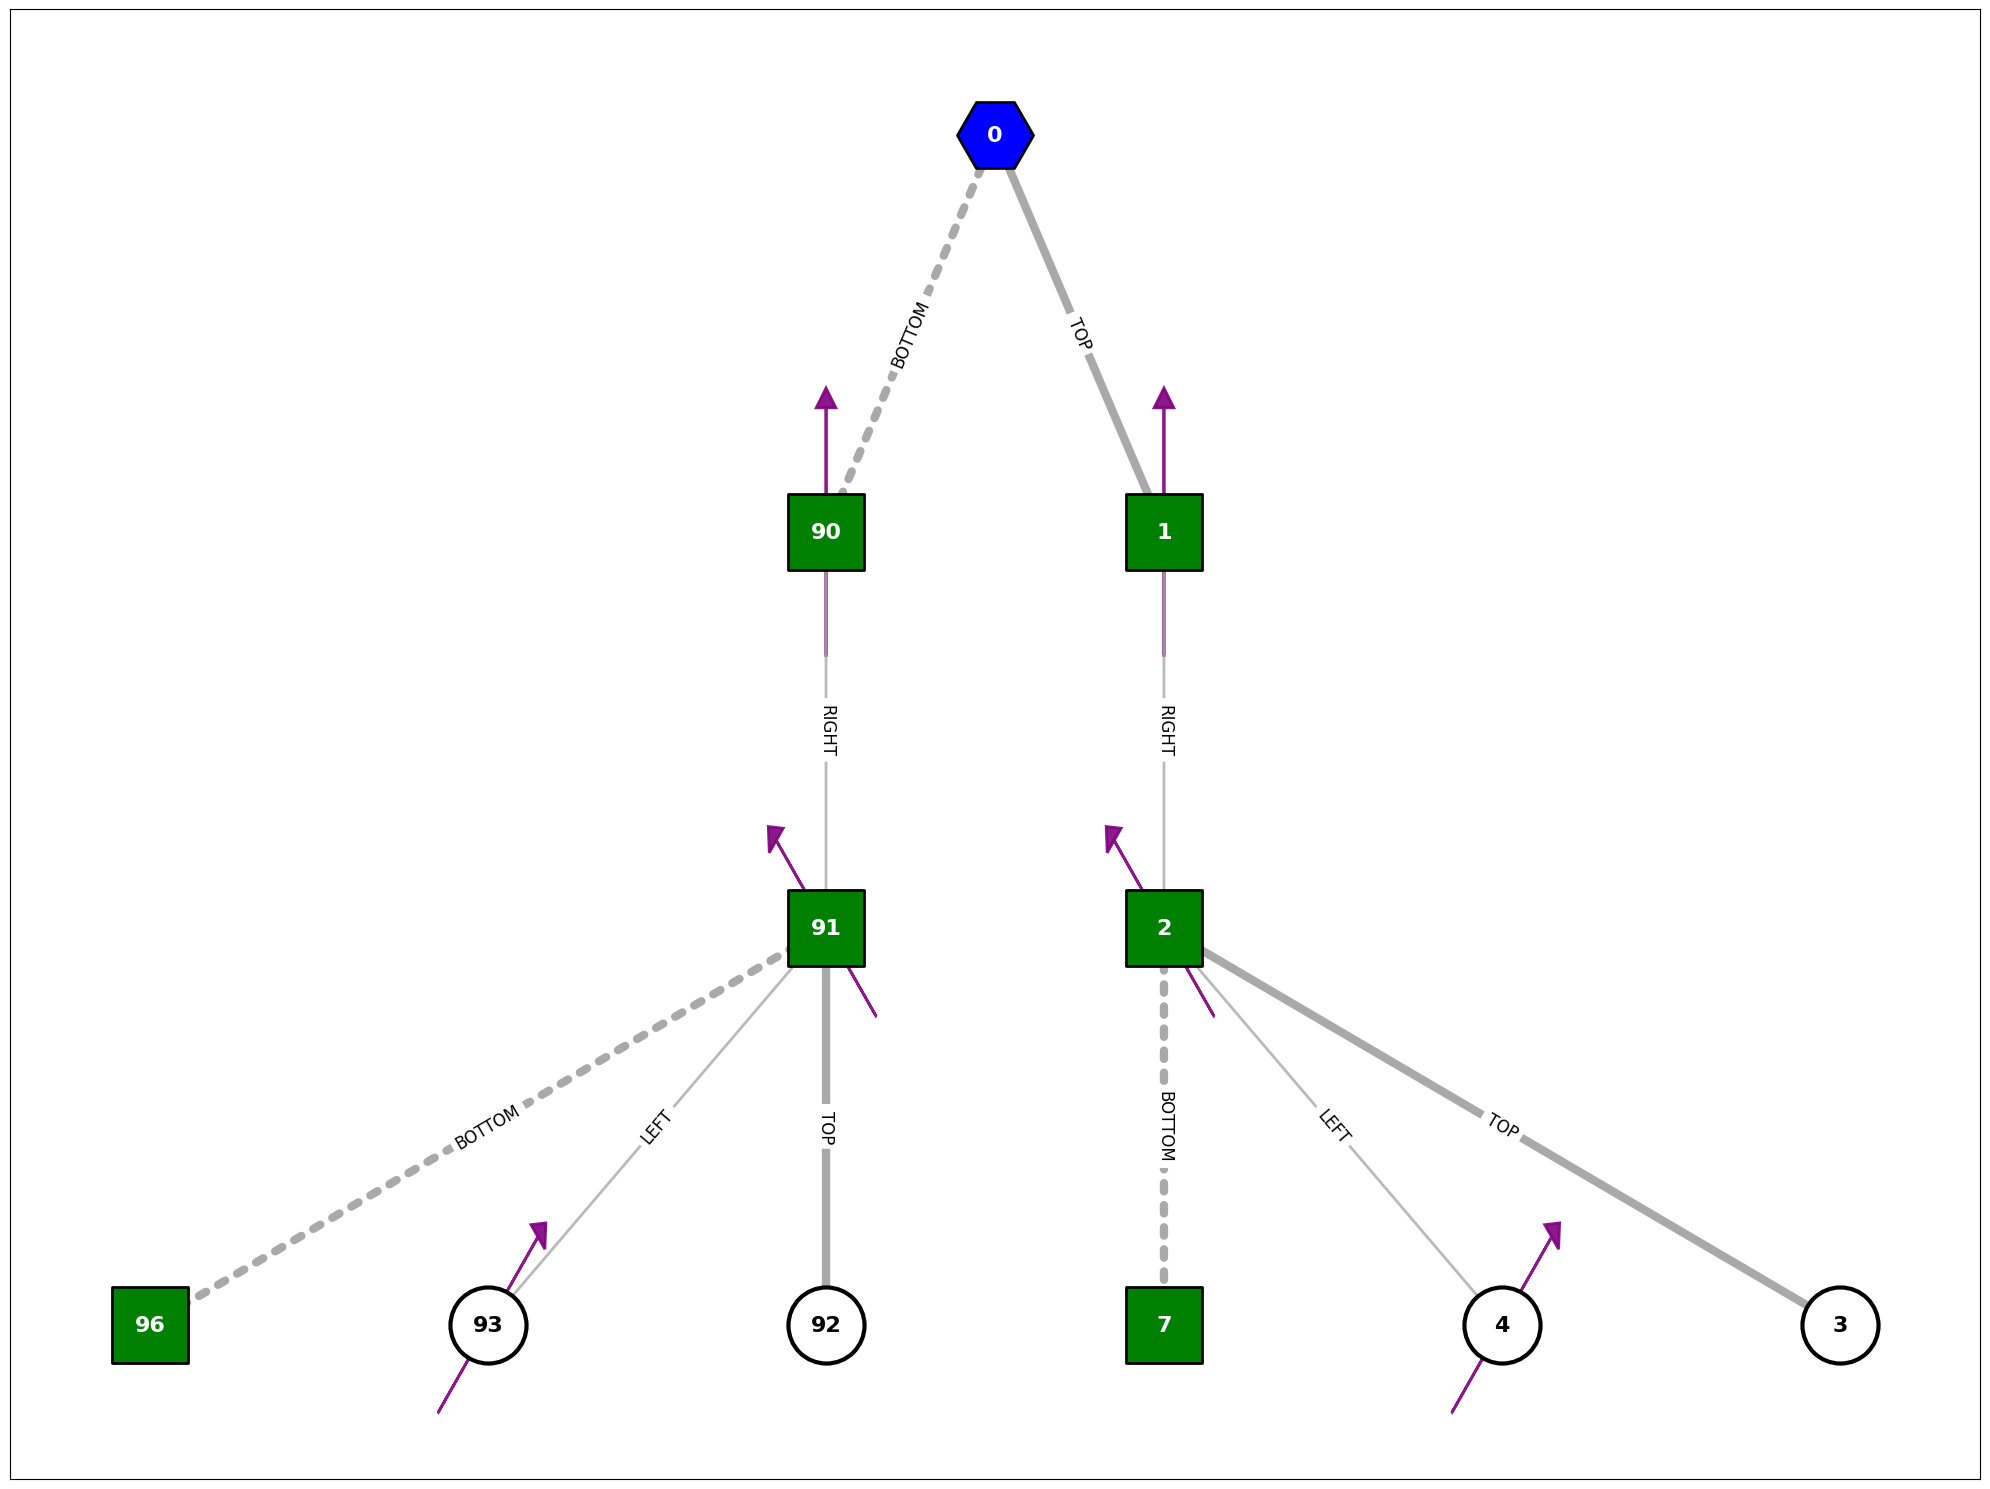

[00:23:59] DoF (model.nv): 10, Actuators (model.nu): 4                                           ]8;id=710554;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=158586;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

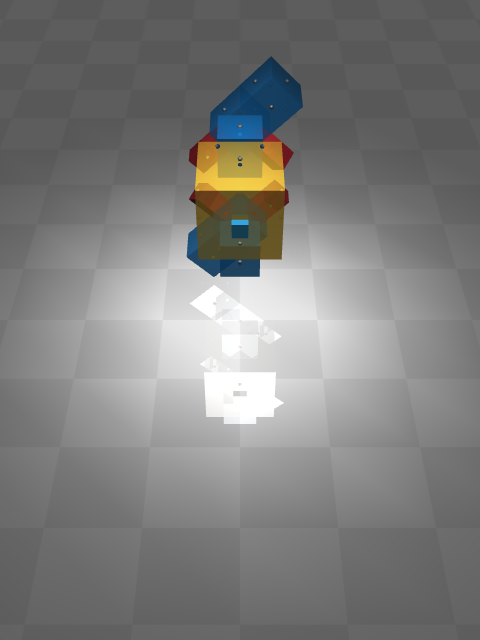

In [35]:
def give_brick(i: int) -> CanonicalNode:
    brick1 = CanonicalNode(i, ModuleType.BRICK, 2)
    brick2 = CanonicalNode(i + 1, ModuleType.BRICK, 3)

    hinge1 = CanonicalNode(i + 2, ModuleType.HINGE)
    hinge2 = CanonicalNode(i + 3, ModuleType.HINGE, 1)

    brick3 = CanonicalNode(i + 6, ModuleType.BRICK)

    brick1.RIGHT = brick2
    brick2.TOP = hinge1
    brick2.LEFT = hinge2
    
    
    brick2.BOTTOM = brick3
    
    # brick3.LEFT = hinge2

    return brick1


diy_root = CanonicalNode(0, ModuleType.CORE)

brickA = give_brick(1) #CanonicalNode(20202, ModuleType.BRICK)
# brickA.FRONT = give_brick(1)

brickB = give_brick(90)    #CanonicalNode(28323, ModuleType.BRICK)
# brickB.FRONT = give_brick(90)

diy_root.TOP = brickA
diy_root.BOTTOM = brickB
# diy_root.BACK = give_brick(9)
# diy_root.LEFT = give_brick(13)


diy_graph = diy_root.to_graph()

console.print(repr(diy_root))

visualize_tree_from_graph(diy_graph)
view(diy_graph, with_viewer=False)

False 1
False 2
False 90
False 91


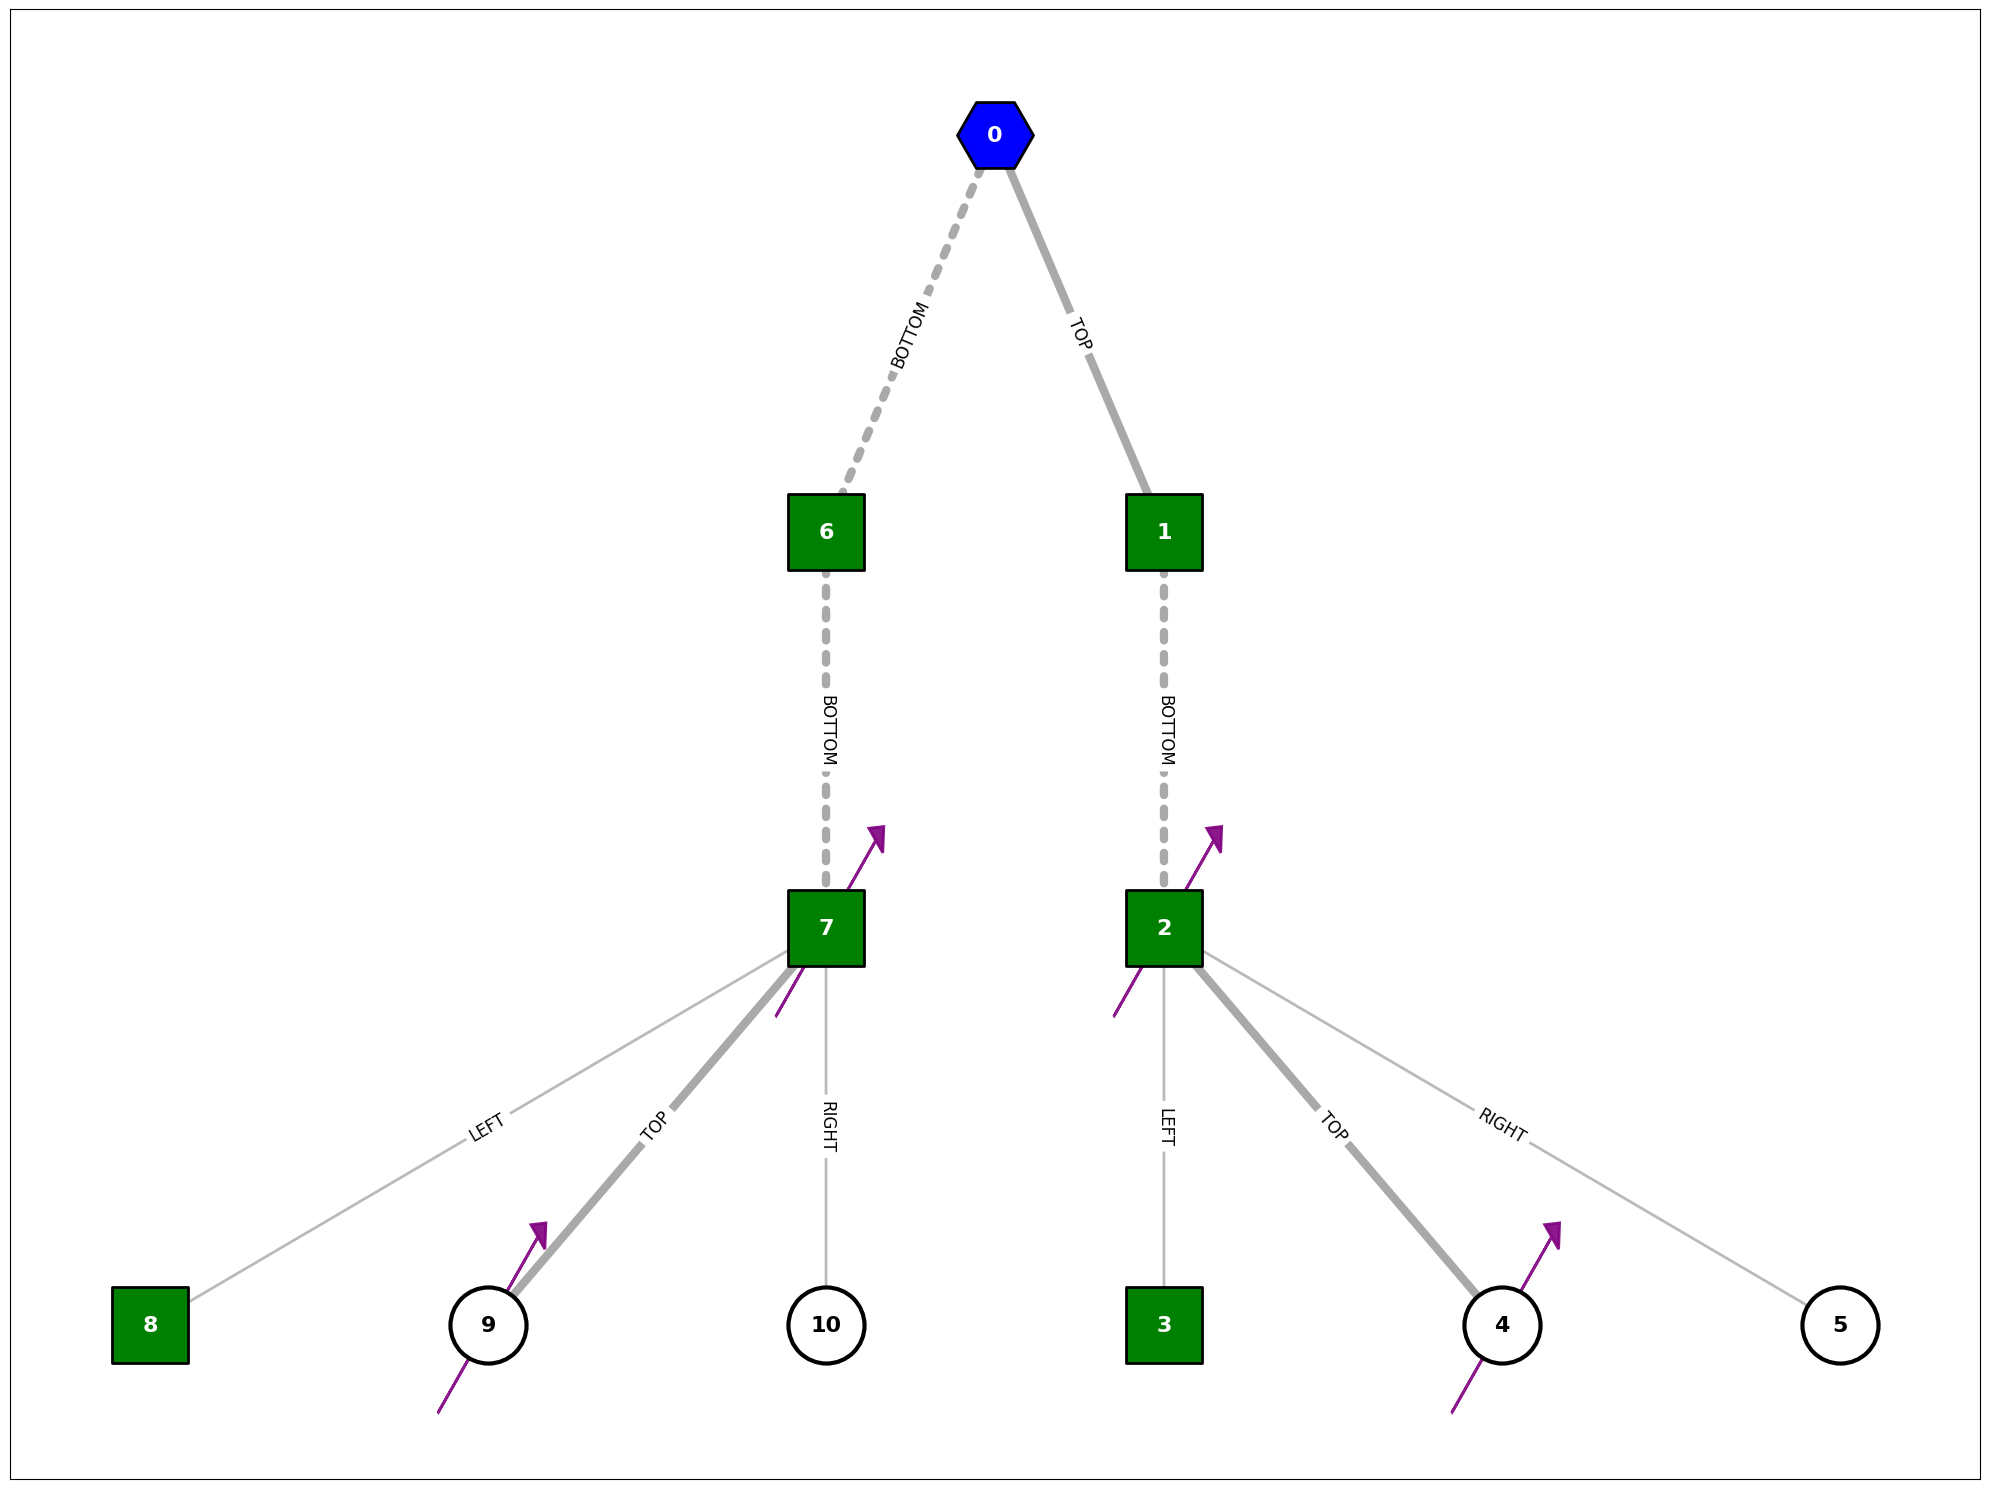

[00:24:00] DoF (model.nv): 10, Actuators (model.nu): 4                                           ]8;id=887629;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=626910;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

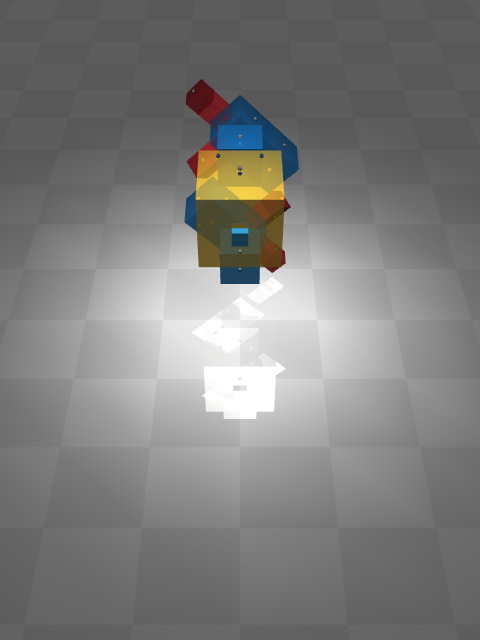

In [36]:
diy1_list = diy_root.depth_first_collect()

visualize_tree_from_graph(diy1_list[0])
view(diy1_list[0], with_viewer=False)

C{t:B{t:B3{r:H{}t:H1{}}}b:B{t:B3{r:H{}t:H1{}}}}


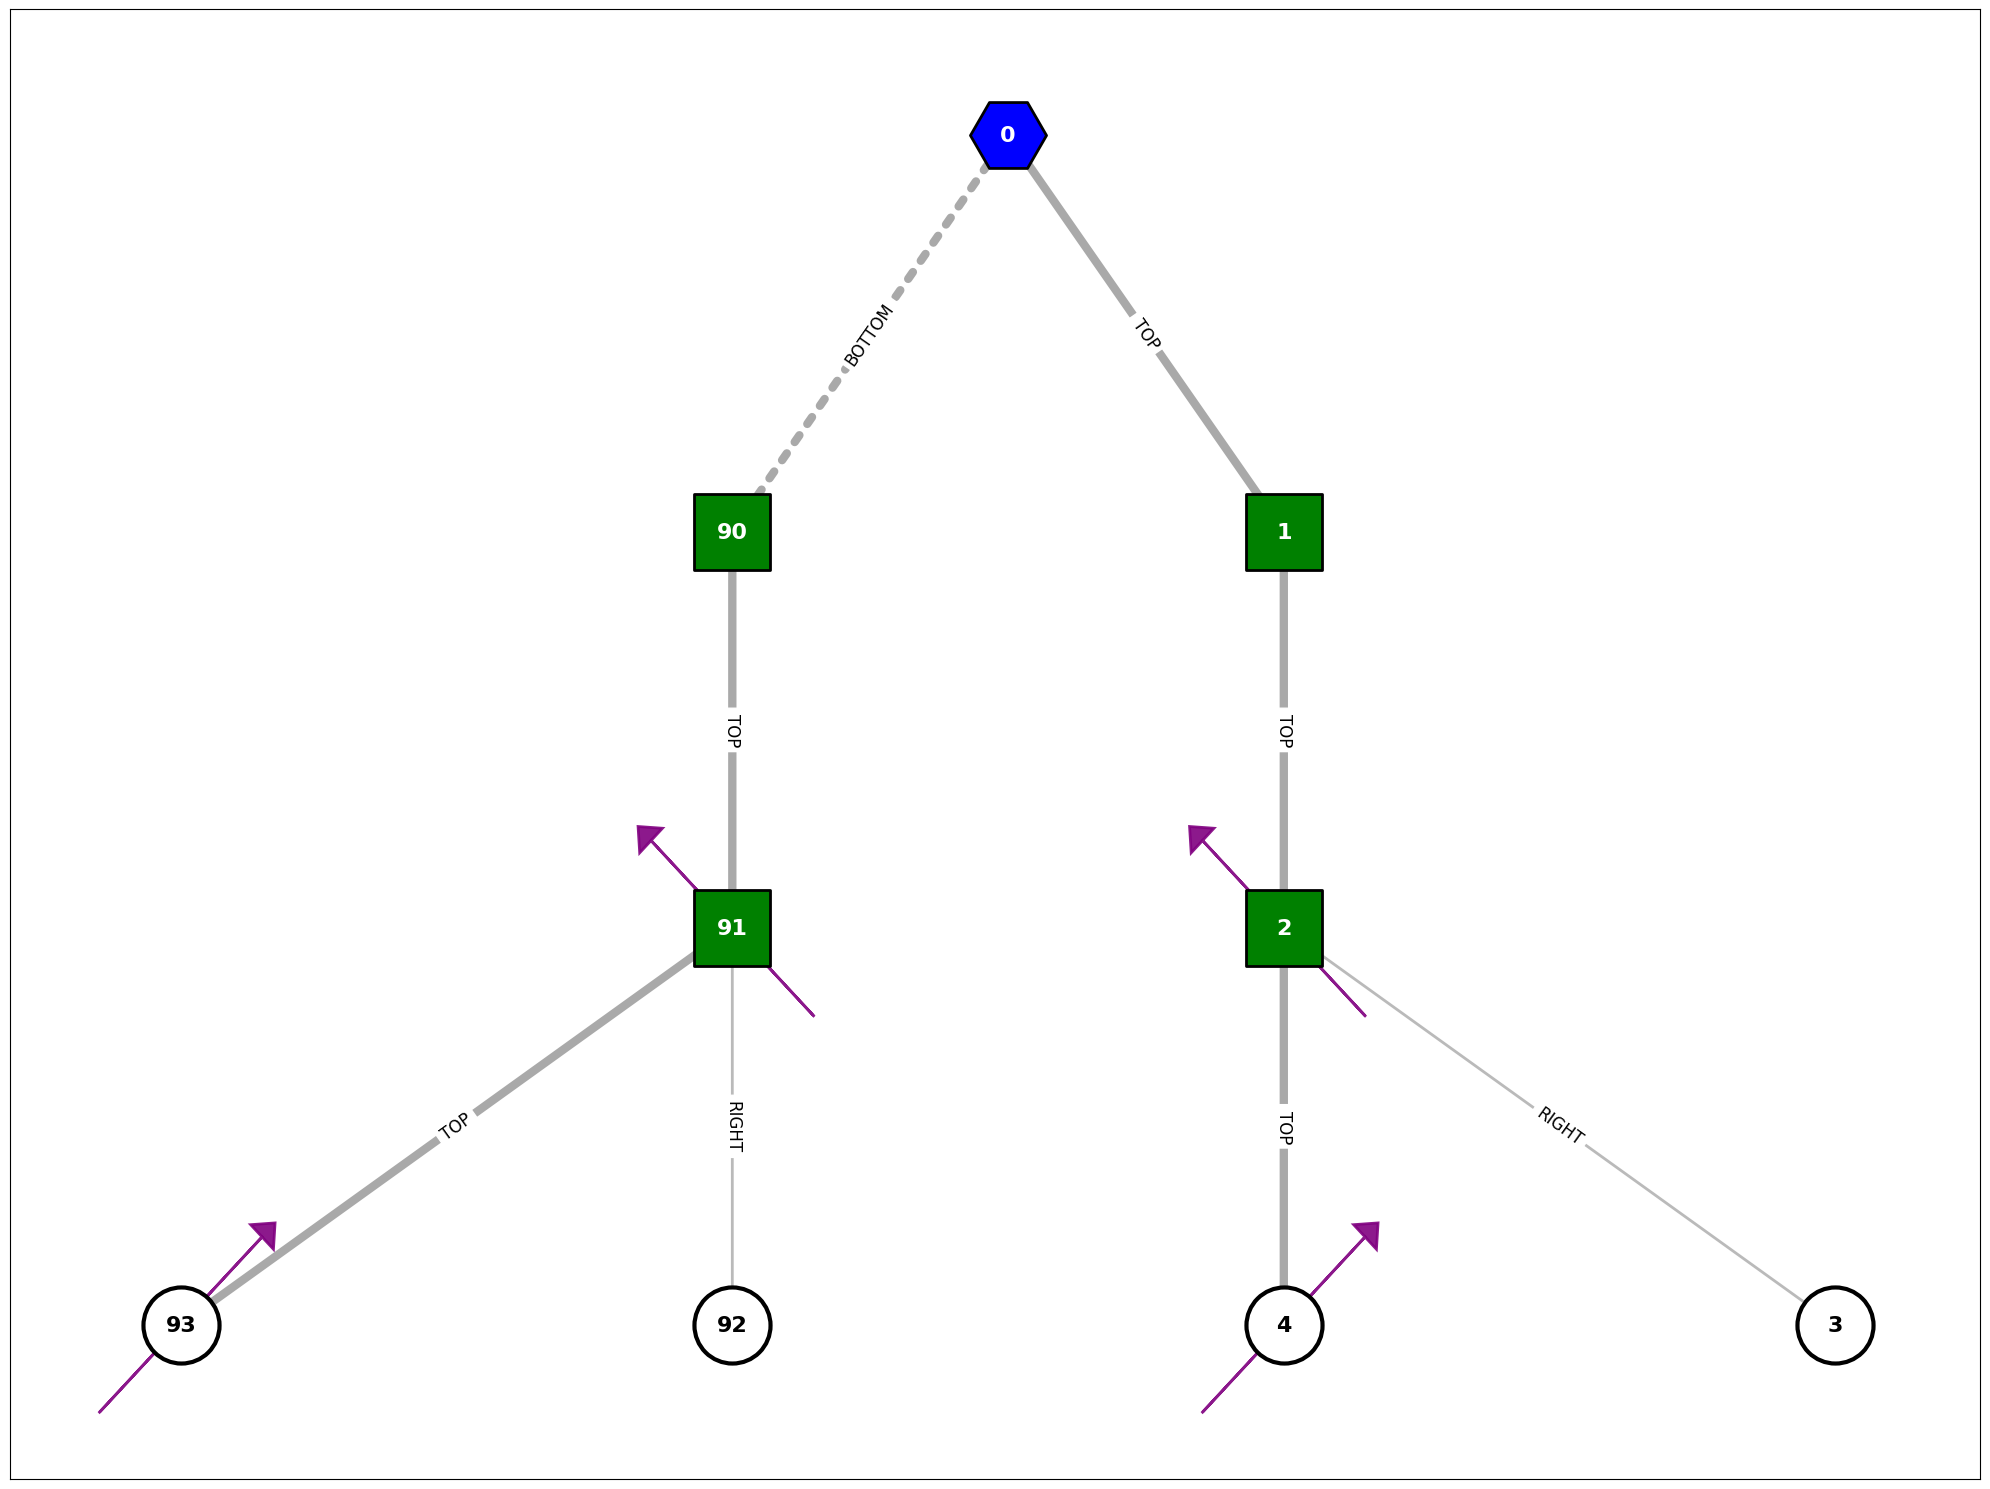

           DoF (model.nv): 10, Actuators (model.nu): 4                                           ]8;id=905034;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=664600;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

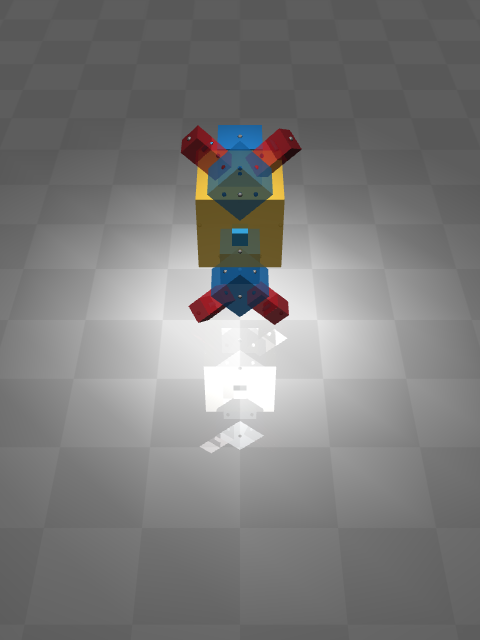

In [37]:
def give_brick(i: int) -> CanonicalNode:
    brick1 = CanonicalNode(i, ModuleType.BRICK, 0)
    brick2 = CanonicalNode(i + 1, ModuleType.BRICK, 3)

    hinge1 = CanonicalNode(i + 2, ModuleType.HINGE)
    hinge2 = CanonicalNode(i + 3, ModuleType.HINGE, 1)

    brick3 = CanonicalNode(i + 6, ModuleType.BRICK)

    brick1.TOP = brick2
    brick2.RIGHT = hinge1
    brick2.TOP = hinge2
    
    # brick3.TOP = hinge1
    
    # brick3.LEFT = hinge2

    return brick1


diy_root = CanonicalNode(0, ModuleType.CORE)

diy_root.TOP = give_brick(1)
diy_root.BOTTOM = give_brick(90)
# diy_root.BACK = give_brick(9)
# diy_root.LEFT = give_brick(13)


diy_graph = diy_root.to_graph()

console.print(repr(diy_root))

visualize_tree_from_graph(diy_graph)
view(diy_graph, with_viewer=True)

C{b:B2{r:B{t:B1{}}}}


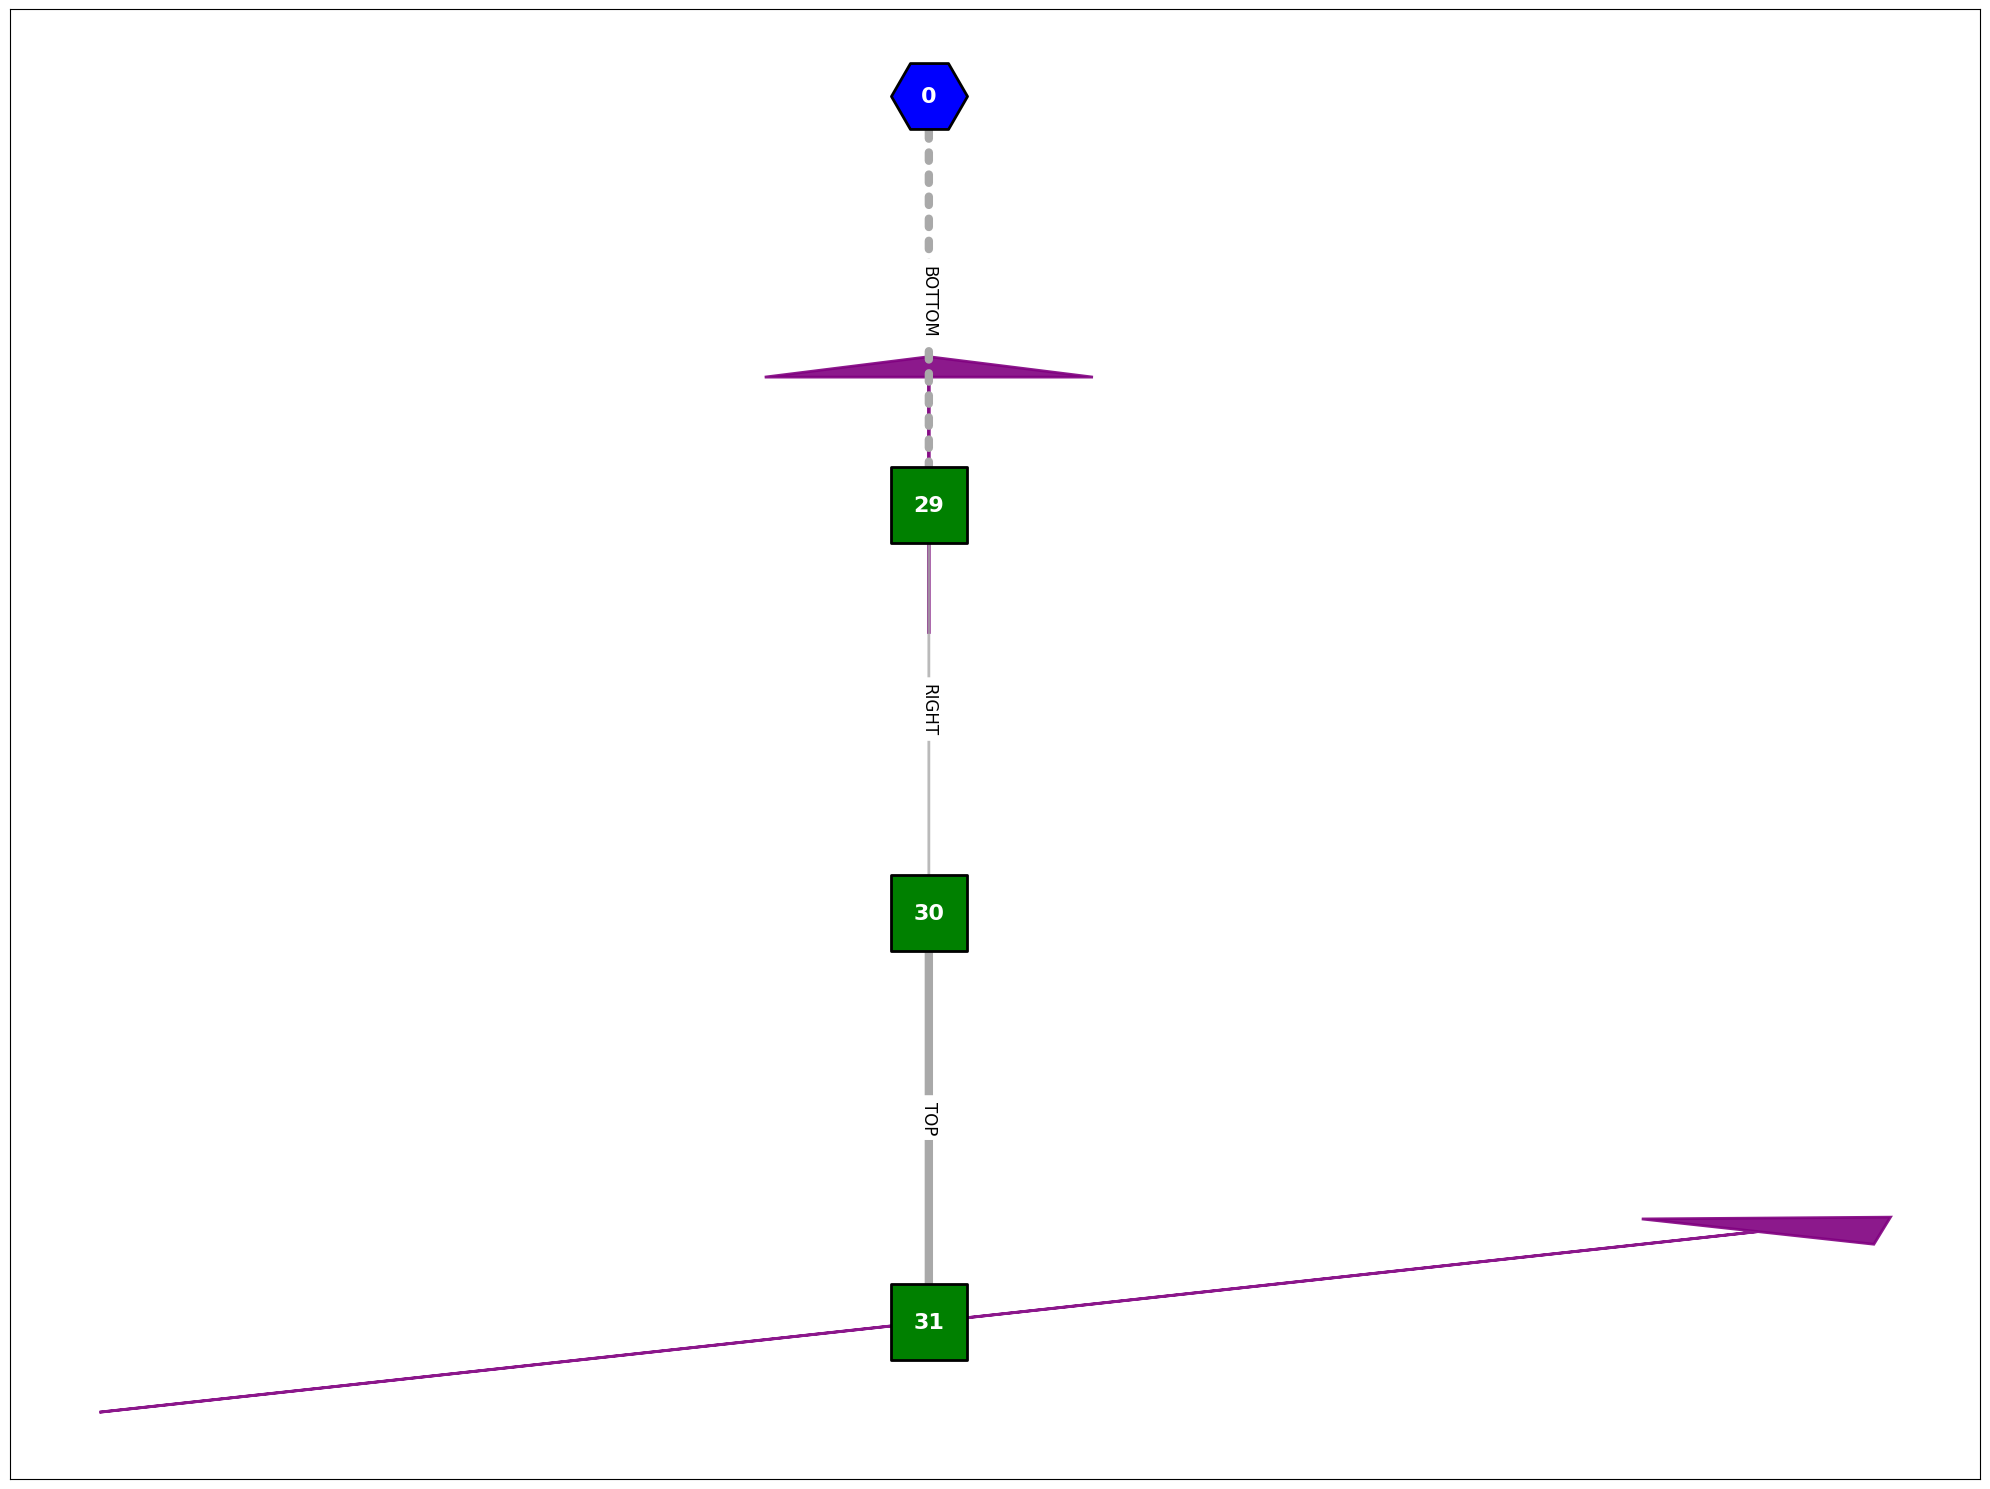

[00:24:05] DoF (model.nv): 6, Actuators (model.nu): 0                                            ]8;id=797114;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=133911;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

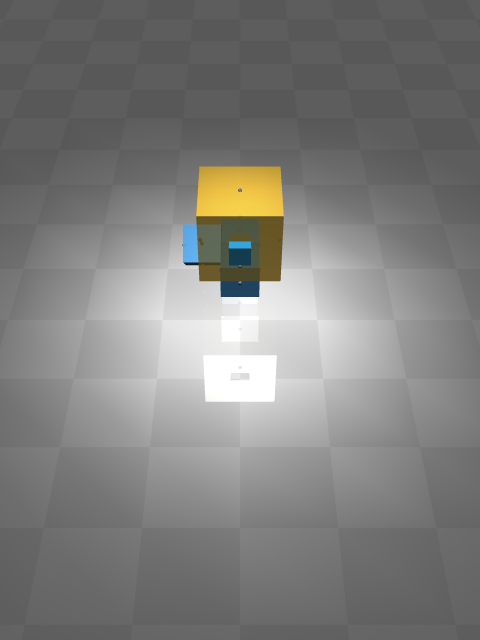

In [38]:
def give_brick(i: int) -> CanonicalNode:
    brick1 = CanonicalNode(i, ModuleType.BRICK, 2)
    brick2 = CanonicalNode(i + 1, ModuleType.BRICK, 0)

    # hinge1 = CanonicalNode(i + 2, ModuleType.HINGE)
    # hinge2 = CanonicalNode(i + 3, ModuleType.HINGE, 1)
    
    brick3 = CanonicalNode(i + 2, ModuleType.BRICK, 1)

    brick1.RIGHT = brick2
    brick2.TOP = brick3
    # brick2.LEFT = hinge2

    return brick1


diy_root = CanonicalNode(0, ModuleType.CORE)

# diy_root.FRONT = give_brick(1)
# diy_root.RIGHT = give_brick(5)
# diy_root.BACK = give_brick(9)
# diy_root.LEFT = give_brick(13)

# diy_root.TOP = CanonicalNode(9, ModuleType.BRICK)
# diy_root.TOP = give_brick(1)

diy_root.BOTTOM = give_brick(29)
# diy_root.RIGHT.BOTTOM = give_brick(20)

diy_graph = diy_root.to_graph()

console.print(repr(diy_root))

visualize_tree_from_graph(diy_graph)
view(diy_graph, with_viewer=True)

False 29


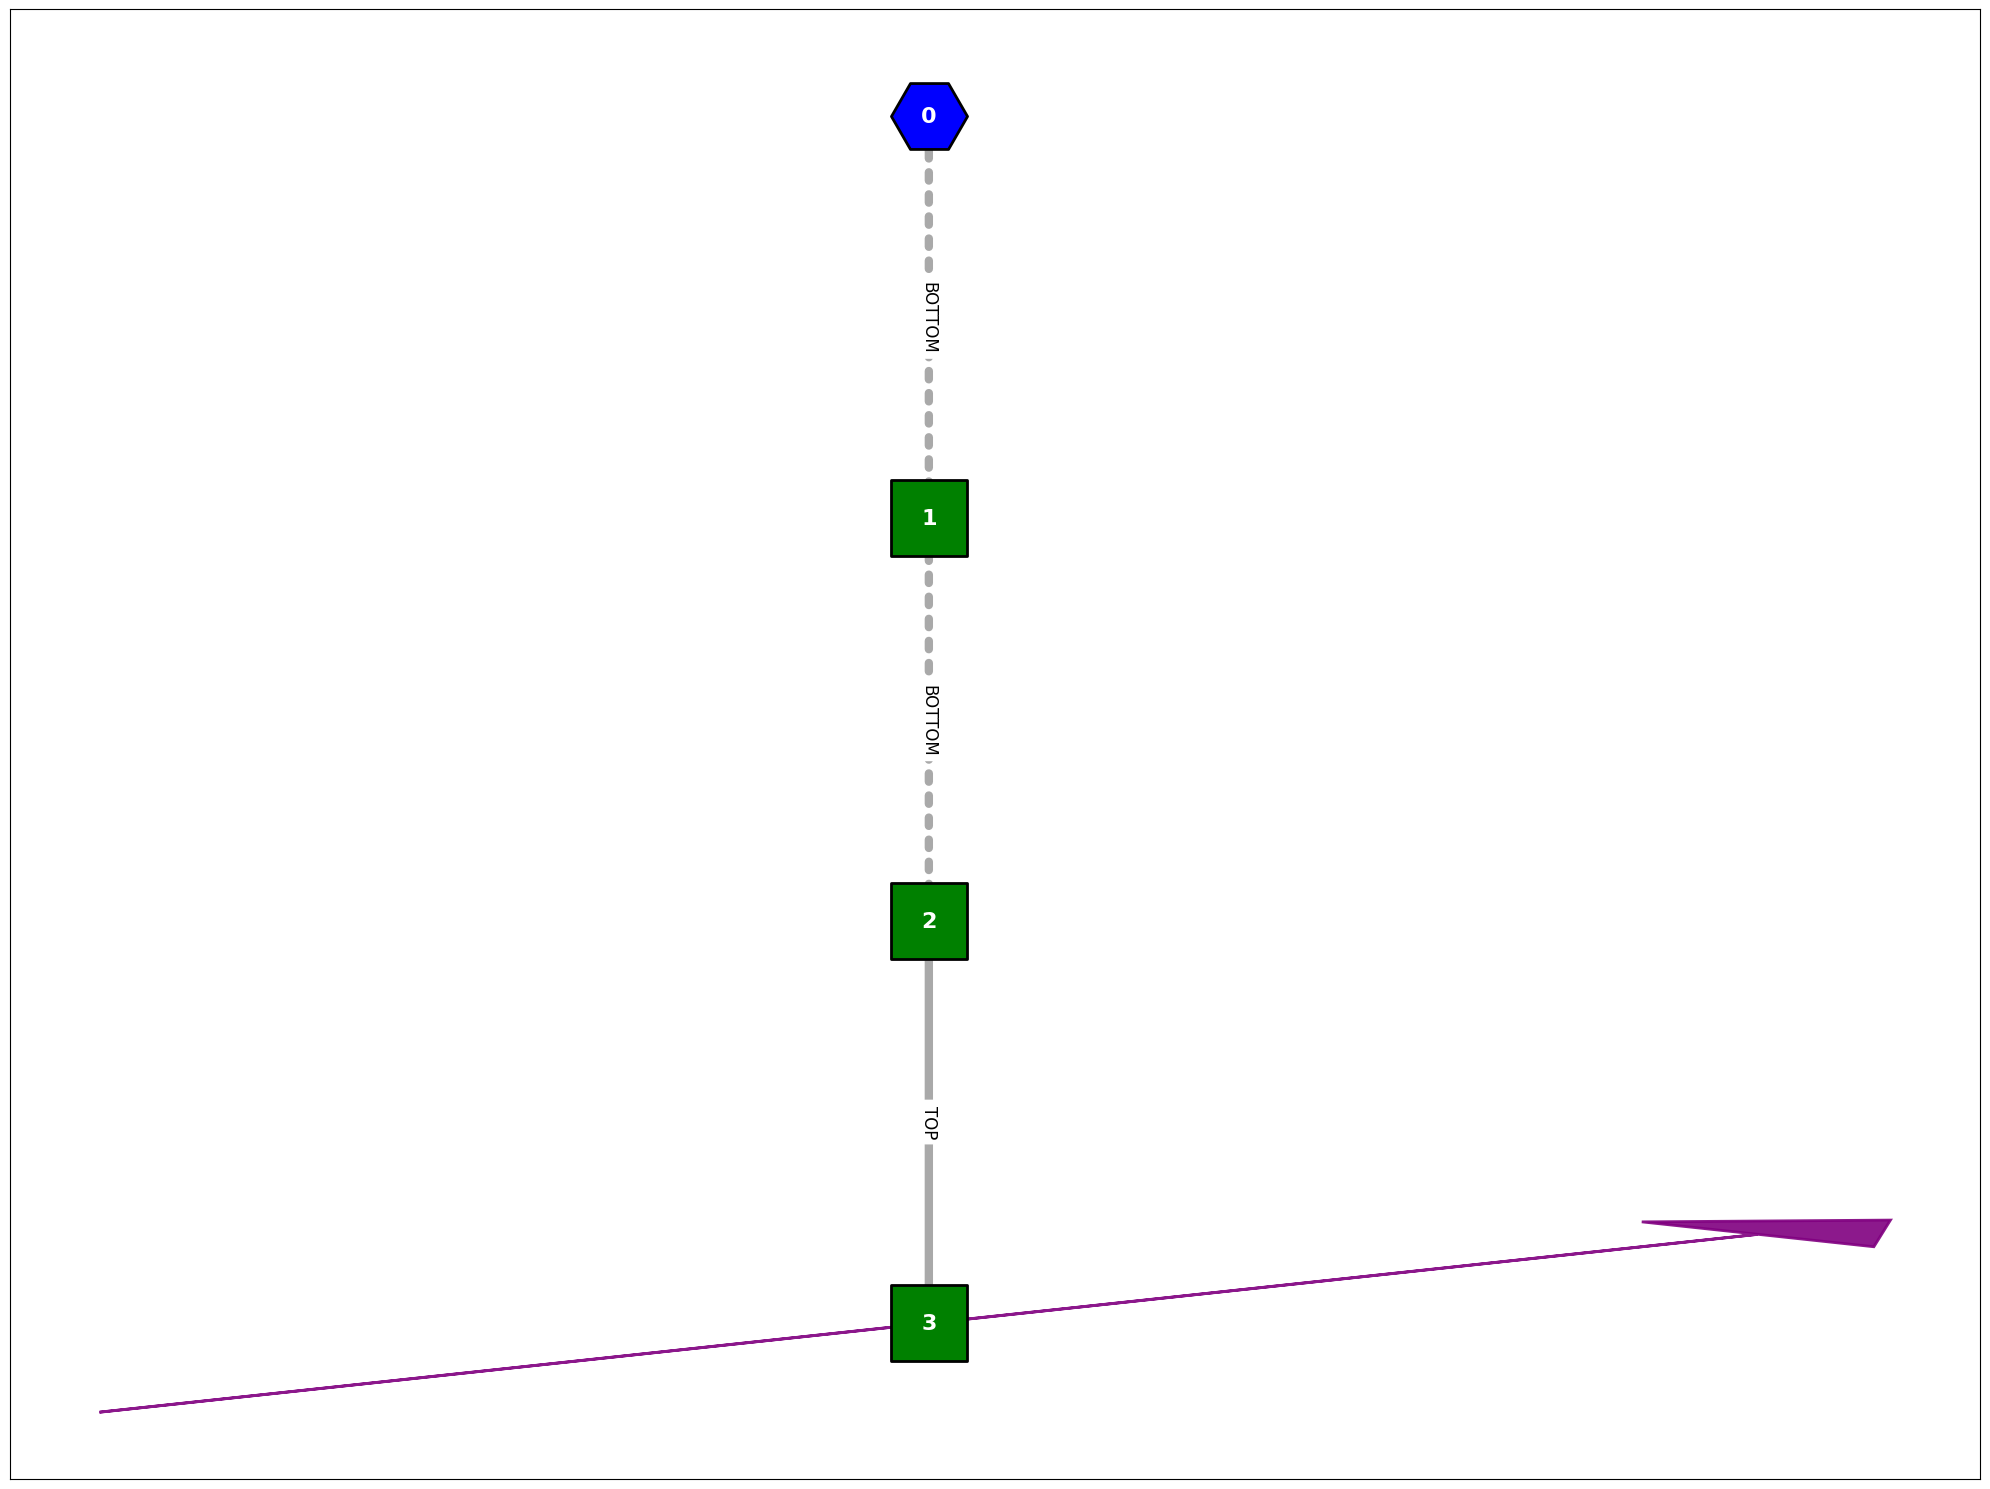

[00:24:06] DoF (model.nv): 6, Actuators (model.nu): 0                                            ]8;id=973664;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=588038;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

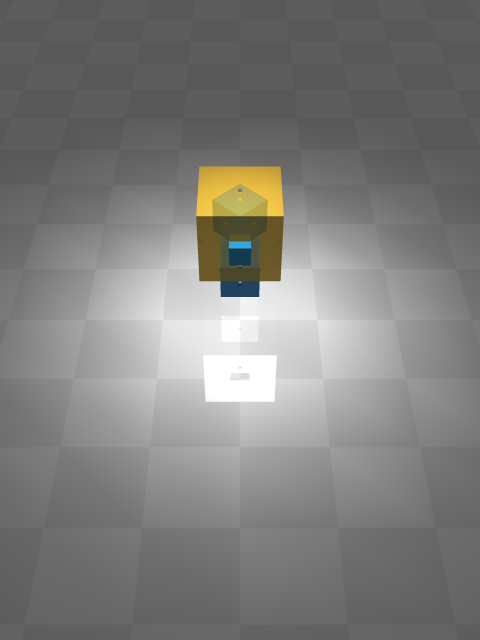

In [39]:
diy1_list = diy_root.depth_first_collect()

visualize_tree_from_graph(diy1_list[0])
view(diy1_list[0], with_viewer=False)

Check if angles still right

In [40]:
fingerprint_list = diy_root.depth_first_collect()

---

try to figure out what is going on with stupid.json

In [41]:
# import stupid.json and check what is wrong with the angles

In [42]:
import json
from networkx.readwrite import json_graph

with open("stupid.json", "r") as f:
    data = json.load(f)

graph = json_graph.node_link_graph(data)

/home/salo/projects/ariel-zoo/.venv/lib/python3.12/site-packages/networkx/readwrite/json_graph/node_link.py:290: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


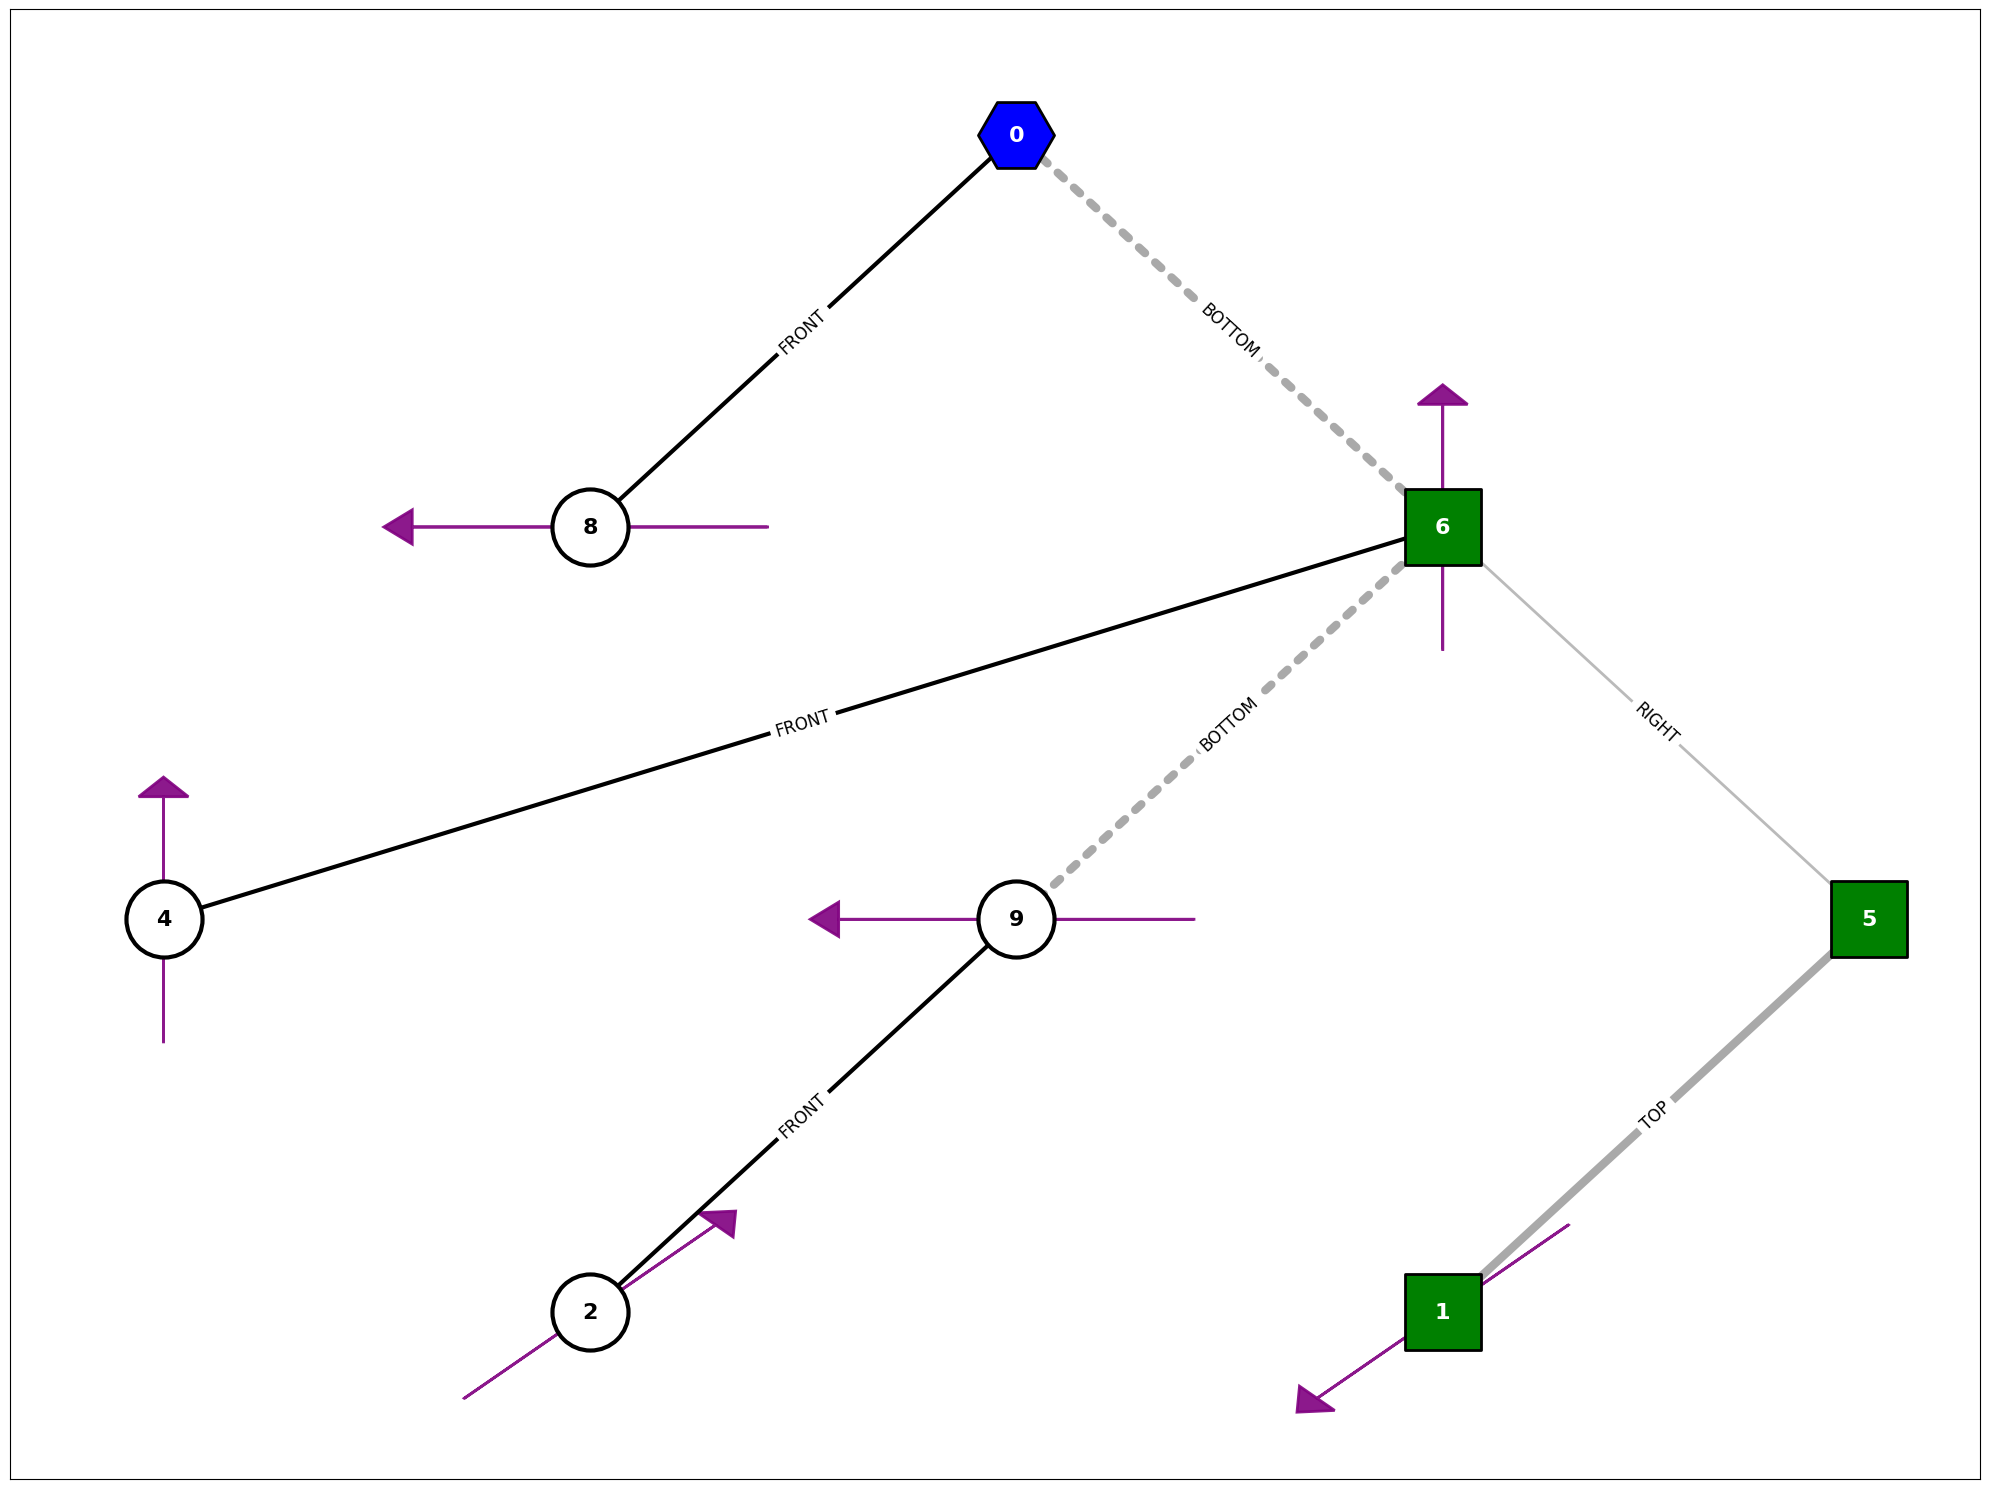

In [43]:
visualize_tree_from_graph(graph)

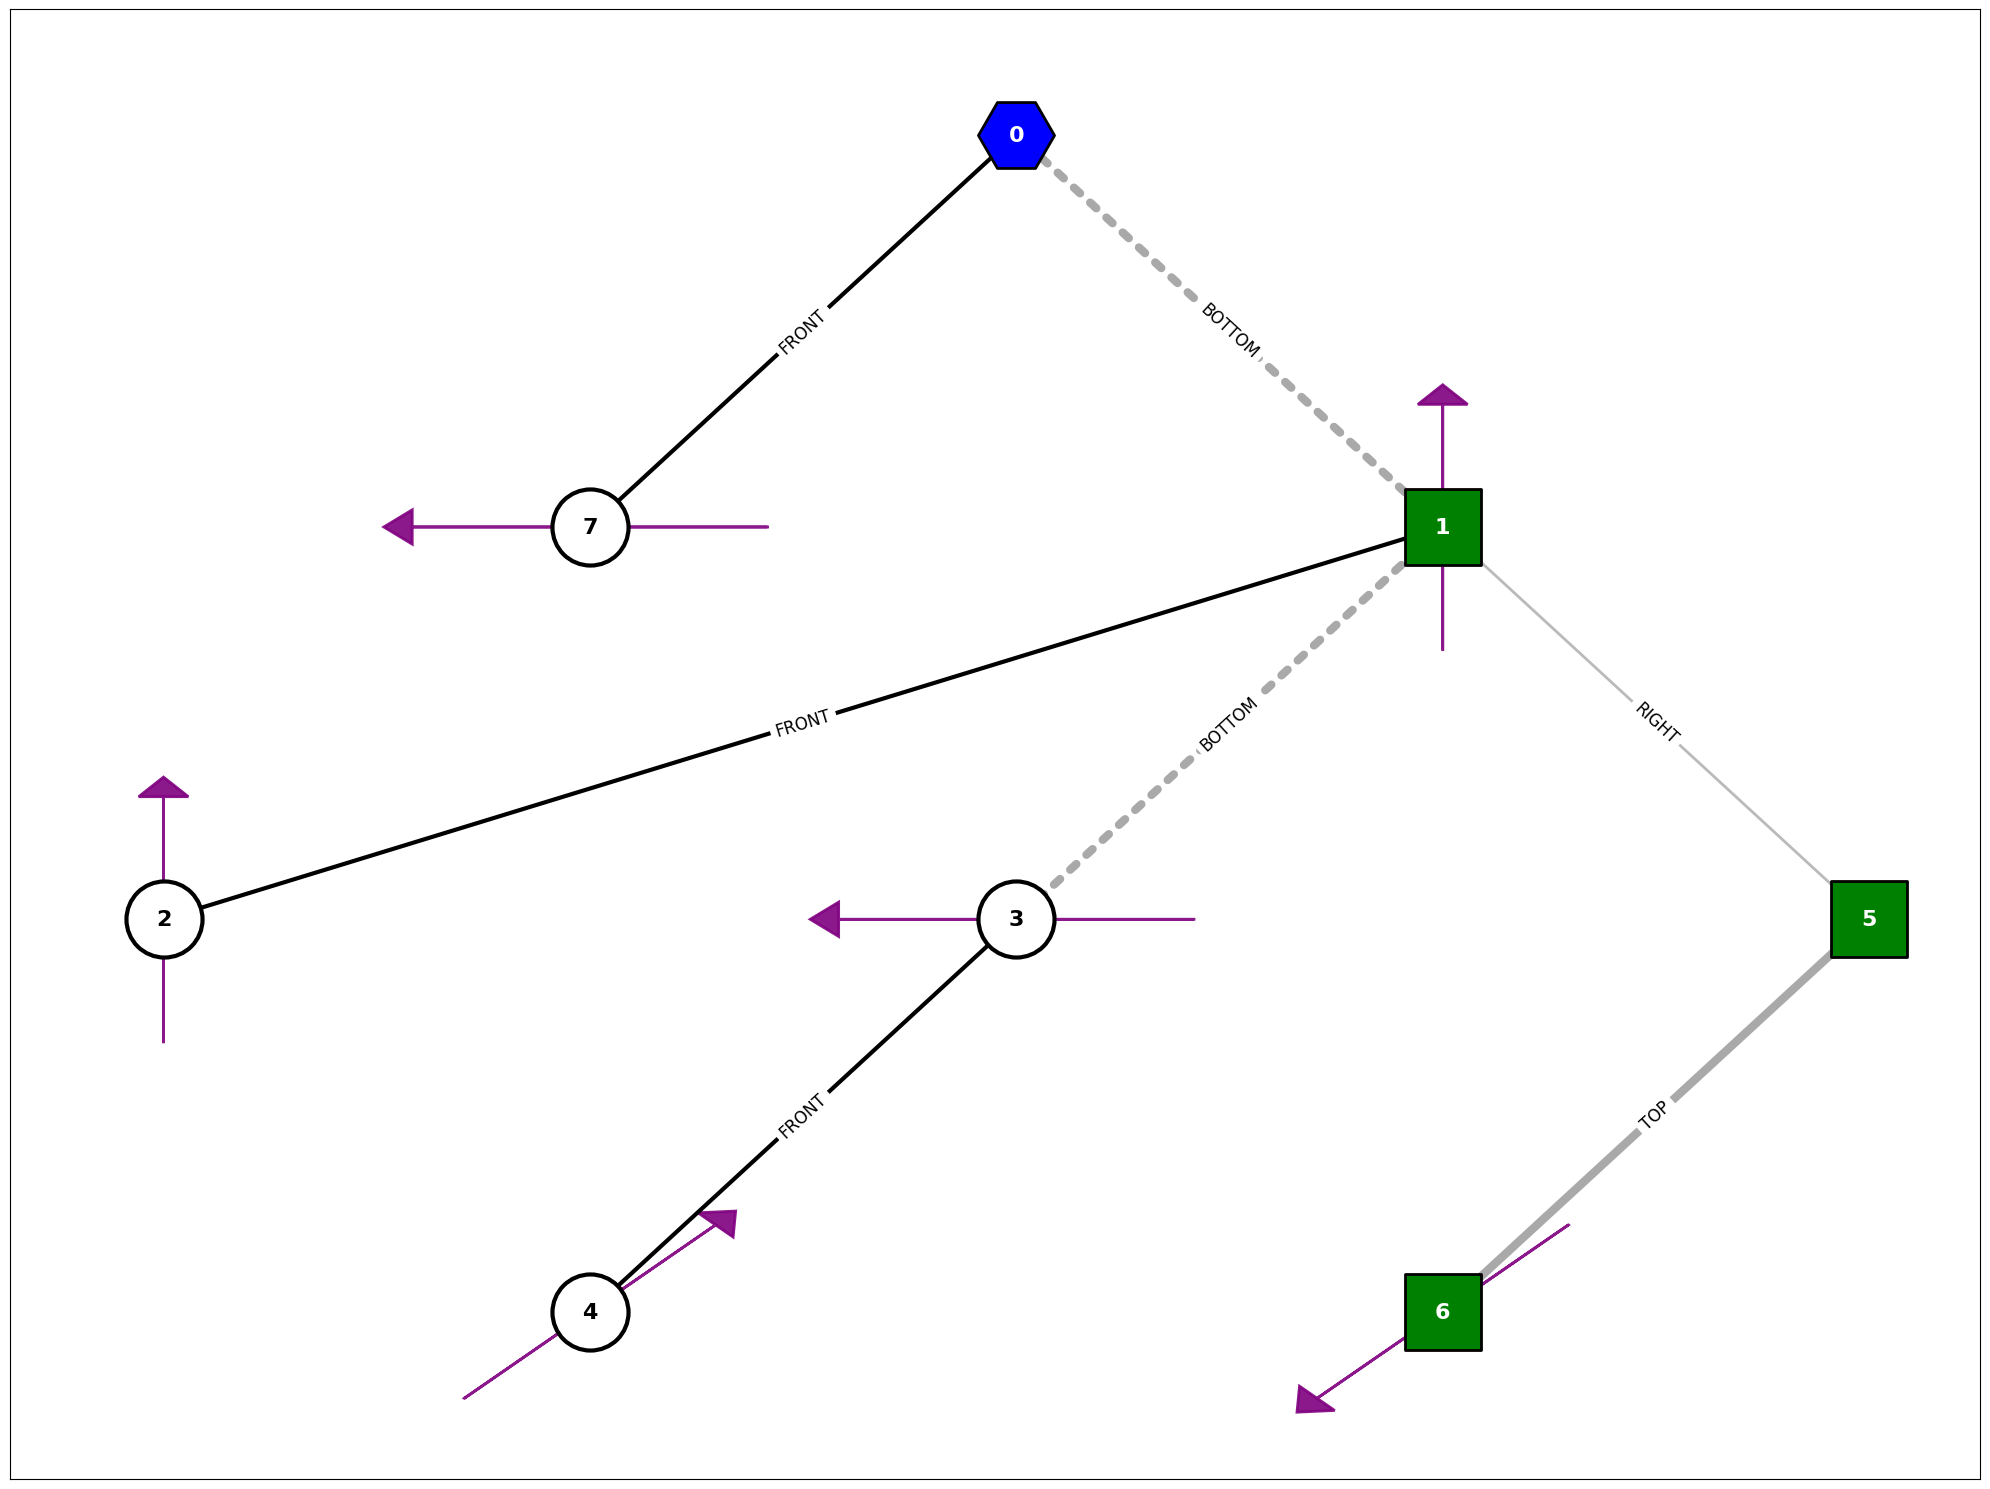

False 1
True 2
False 6
False 6
False 3
False 4
False 7


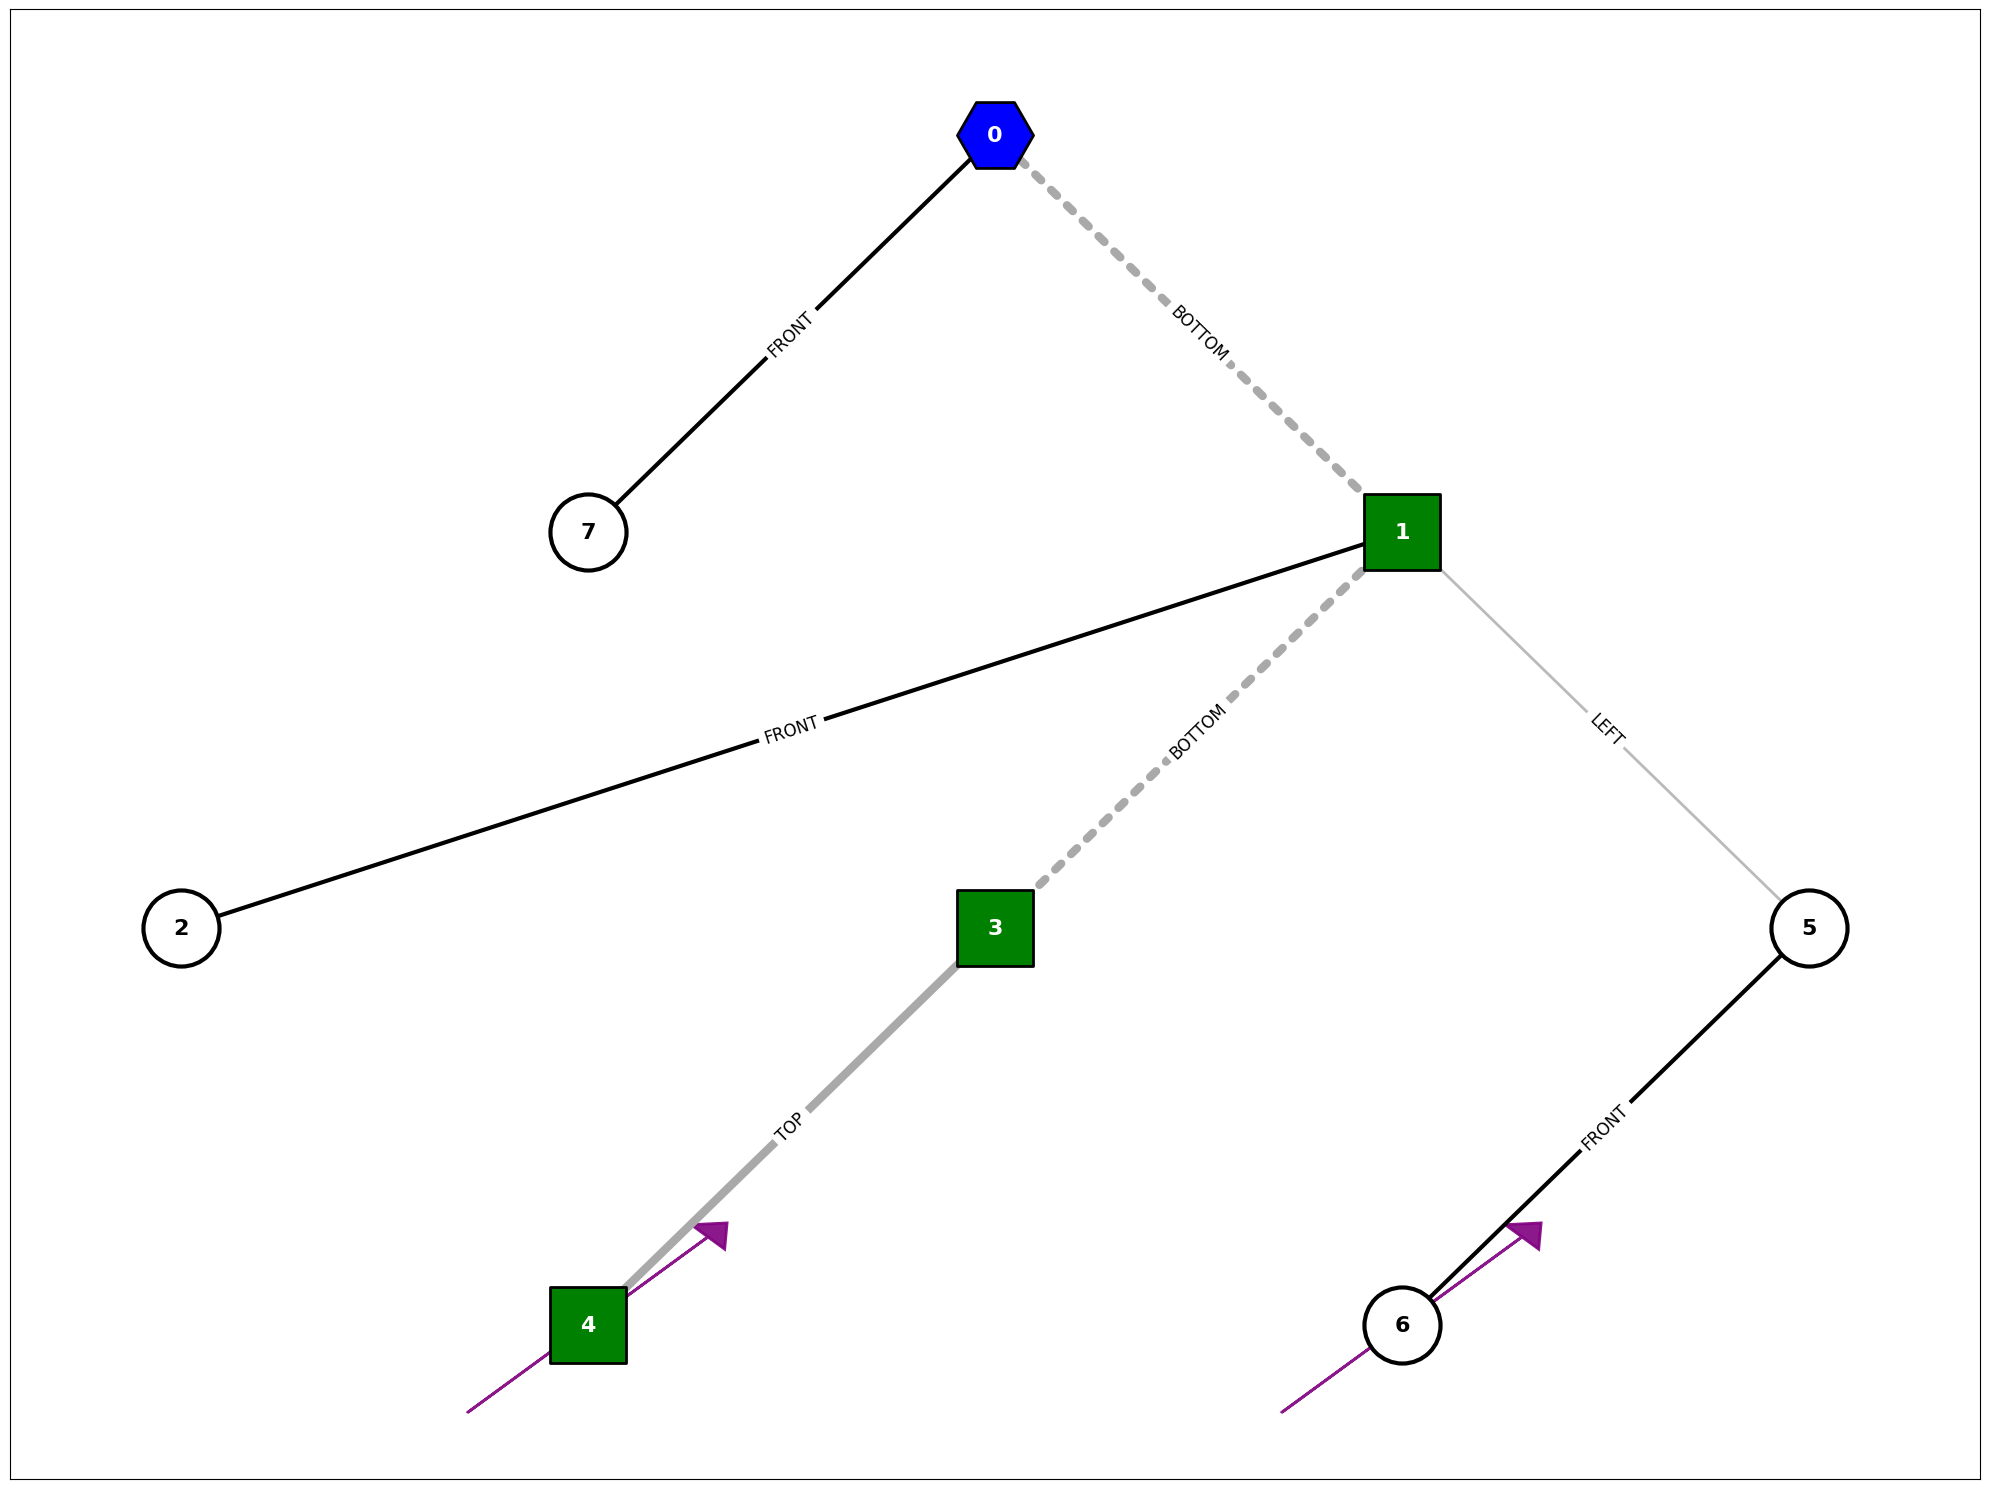

[00:24:07] DoF (model.nv): 10, Actuators (model.nu): 4                                           ]8;id=255253;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=874202;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

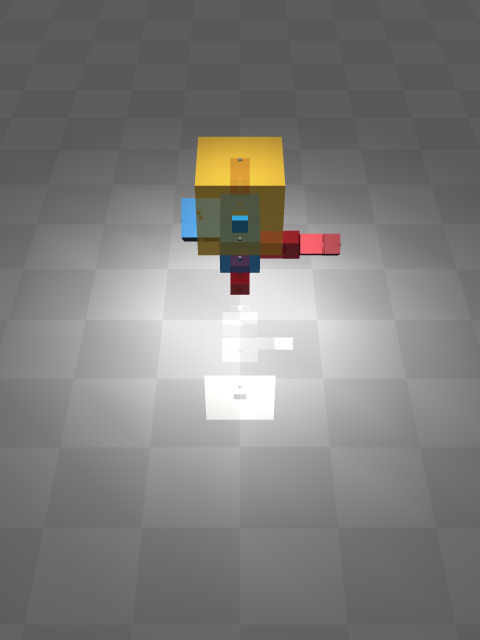

[00:24:10] DoF (model.nv): 10, Actuators (model.nu): 4                                           ]8;id=793640;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py\view_mujoco.py]8;;\:]8;id=529097;file:///home/salo/projects/ariel-zoo/src/ariel_experiments/gui_vis/view_mujoco.py#125\125]8;;\

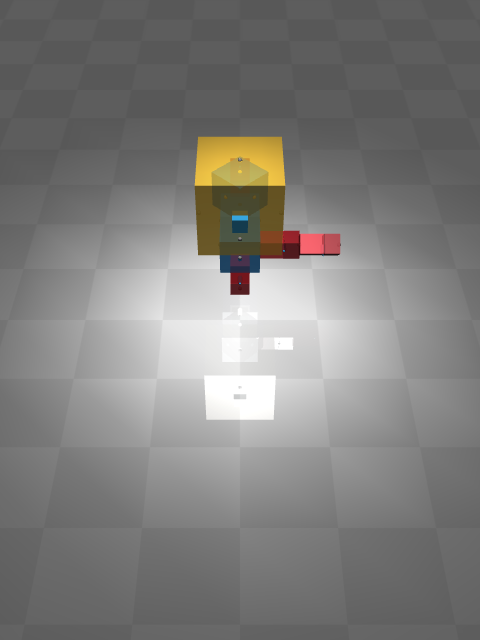

In [44]:
canonical = CanonicalNode.from_graph(graph)
canonical.re_add_id()
visualize_tree_from_graph(canonical.to_graph())

collected = canonical.depth_first_collect()
# canonical = canonical.to_graph()

visualize_tree_from_graph(collected[0])

view(graph, with_viewer=True)
view(collected[0], with_viewer=True)